# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [1.0, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

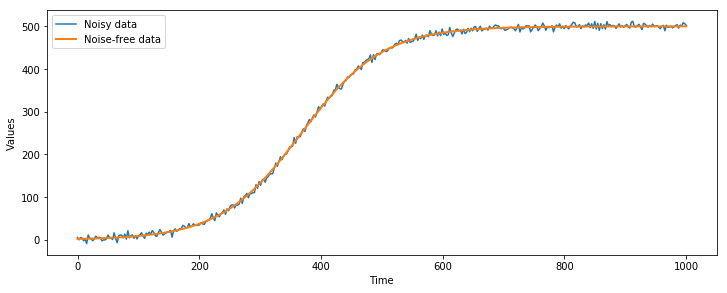

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([-1.0, -1.0], [2.0, 2.0])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[1.01326064 0.82157584]
-52782.88401123674


[1.04930172 0.98208373]
-60157.94268194609
accepted


[1.12843638 1.1149498 ]
-143036.1466281823
accepted


1     6      0         0.5       0.5        0:00.0
[0.96729514 0.6967101 ]
-95991.51690526478


[0.90795437 0.95890247]
-20564.226423097254
accepted


[1.16205183 1.02737628]
-109701.13033891308
accepted


2     9      0         0.667     0.667      0:00.0
[0.91292832 0.84961586]
-31042.885237423234


[0.76908748 0.99914979]
-1642.966849970334
accepted


[0.86786406 1.14807787]
-54550.784959618926
accepted


3     12     0         0.75      0.75       0:00.0
[0.98051549 0.66057892]
-118848.92613010888


[0.64797835 0.95014074]
-23460.467679211855


[0.75906671 1.19458108]
-41089.04209979231
accepted


[0.83138399 1.06812042]
-18023.589726541


[0.70236013 1.18024039]
-28053.974739914265


[0.78216895 0.95561198]
-3368.828981129302


[0.87823418 1.16293902]
-65158.66945045647


[0.69157593 1.0677386 ]
-7098.387355327694


[0.63565364 1.07466284]
-19915.576614351754


[0.78822749 0.9327762 ]
-5642.857861884848


[0.79833904 0.98679969]
-3540.5633892585306


[0.56829223 1.05181785]
-55752.613557818135


[0.7973154  1.10936823]
-20724.88385718307


[0.7367688  1.10069424]
-10346.614285482256


[0.89598412 1.04231342]
-28610.912640517316


[0.74128094 0.85726176]
-23276.97761999969


[0.75113573 0.93476561]
-5592.594786725079


[0.80774123 1.14245121]
-33487.24518074617


[0.74608086 0.97318363]
-2082.931762712183


[0.95656589 0.83412185]
-40799.247462592066


[0.61611888 0.97832325]
-33221.61098983558


[0.79050227 0.86115861]
-19201.462320928596


[0.78775582 0.84623035]
-23470.214308619128


[0.73855542 1.03653263]
-2337.351067462428


[0.84245393 0.94615281]
-9185.344480627502


[0.74001322 1.12101361]
-14857.386301645796



-21463.911821971058


[0.79421191 0.84882902]
-22598.289170549124


[0.83814115 1.11315413]
-31889.874949029043


[0.93648605 0.93665091]
-26108.44208982204


[0.76859595 0.93467143]
-5151.187089823844


[0.86456348 0.99415994]
-13810.375865935433


[0.64357875 0.93063637]
-28869.665486573893


[0.67044184 0.94209754]
-17332.036353438834


[0.61070285 0.91083847]
-49548.163278941356


[0.85777028 1.08083096]
-27684.929645169974


[0.75488672 0.93199471]
-5808.267226714039


[0.57063584 0.97558191]
-62680.47652654197


[0.57460422 0.91283505]
-73272.57467212509


[0.75600263 1.15481427]
-26217.77753024853


[0.70945487 1.06843588]
-5648.814519690161


[0.94898688 0.99597186]
-34190.21574194893


[0.68803218 1.06242138]
-7152.364492775268


[0.72309432 0.91173122]
-11961.260169543953


[0.68853346 0.92620418]
-15461.688138386917


[0.78116103 1.12182103]
-20922.644215981378


[0.75004887 0.82879421]
-31642.30964846651


[0.6177786  1.09678928]
-27631.004369818125


[0.68862001 0.94383517

[0.74918167 1.01267374]
-1356.2262938551628
accepted


220   663    0.0317    0.0317    0.0633     0:00.6
[0.75230725 1.00214389]
-1227.9193760018172


[0.75129317 0.99703022]
-1226.225875630541


[0.75428756 1.01866586]
-1639.3061453577016


[0.75140786 0.99915768]
-1218.1035067727348
accepted


[0.74785973 1.00341088]
-1222.5913519457497
accepted


[0.73637776 1.00642122]
-1416.1257552944378


[0.75172747 0.99991316]
-1218.6347904351335
accepted


[0.74455906 1.00429736]
-1246.9463165026627


[0.74466314 1.0099542 ]
-1296.1858303118797
accepted


[0.75455449 0.99890192]
-1239.0504678095776


[0.74448904 1.00333064]
-1245.7008699956145


[0.74473453 1.01077692]
-1308.5738302751893


[0.75104647 1.00299429]
-1224.6222521165332


[0.7483744  1.00207354]
-1217.4627770445686
accepted


[0.74157618 1.01055224]
-1332.5019416859984


[0.75081242 1.00027306]
-1215.6948921024737
accepted


[0.7428774  1.00298818]
-1267.4921345075768


[0.73869221 1.00838039]
-1362.0083310028913


[0.74941157 1

[0.74976918 0.99968747]
-1215.4984607235551
accepted


[0.74984137 1.00034855]
-1214.6291812533998
accepted


[0.74917573 1.00386686]
-1223.9546135221117


[0.74970987 0.99895035]
-1217.5924667055124


[0.75023962 1.00020871]
-1214.8380216007786
accepted


[0.7500989  1.00210254]
-1217.213384947488
accepted


[0.75011798 0.999088  ]
-1216.7333350052713
accepted


[0.74950523 1.00014624]
-1215.0179804127865


[0.75054997 1.00263856]
-1220.5935023505317


[0.75002386 0.99884364]
-1217.576122157812


[0.75087787 1.00052486]
-1215.949317316964


[0.75075893 0.9998401 ]
-1215.748928647845
accepted


[0.74989523 1.00068199]
-1214.568621872949
accepted


[0.75067089 1.00078746]
-1215.6557364109133


[0.74962285 1.00116431]
-1214.7861691082853
accepted


[0.74936216 1.0010549 ]
-1214.8012094078758
accepted


[0.75087158 0.99967904]
-1216.1105947660958


[0.74997812 1.00163525]
-1215.7510699771954
accepted


[0.74847423 1.00118259]
-1216.4243559092158


[0.7490208  1.00132876]
-1215.32686779709


[0.74970697 1.00263291]
-1218.4505758252894


[0.75004831 1.00177838]
-1216.189533949019


[0.7509366  0.99937404]
-1216.646523567441


[0.75066431 1.00393852]
-1228.972334182688


[0.74736548 1.00067255]
-1221.885994053587


[0.75247679 0.99905299]
-1222.6341410011773


[0.74910245 1.00109594]
-1215.0873560013051
accepted


[0.7475968  1.00287748]
-1221.6117850359688


[0.75021303 0.99969503]
-1215.3634215308507
accepted


[0.74919383 1.00177412]
-1215.7327060712437


[0.75082567 1.00441318]
-1233.629663269757


[0.74806354 0.99927368]
-1222.1563999812433


[0.74883102 1.00053814]
-1215.7921378304384
accepted


[0.74884167 1.00330748]
-1220.8011596132446


[0.75060316 0.99907525]
-1216.8397228832027


[0.74904706 0.9995176 ]
-1217.2210995472237


[0.74735309 1.00171704]
-1221.0252433781488


[0.75051931 0.99798532]
-1220.8281331795463


[0.74955207 1.00118821]
-1214.8122008490052
accepted


[0.75014704 1.00197318]
-1216.9064753099074


[0.74722194 0.99997685]
-1224.7175132936325


[0

[0.74666268 1.00235653]
-1225.4246785328055


[0.74807908 1.00123247]
-1217.7395362704199


[0.7503887 1.0003628]
-1214.9454432770617
accepted


[0.75149591 1.00028035]
-1217.8279925543848


[0.75041335 0.99939726]
-1215.983975917482
accepted


[0.74914852 1.00040852]
-1215.241690039234
accepted


[0.74811767 1.00353452]
-1222.553353162531


[0.75032457 0.99760916]
-1222.9634842436512


[0.74907017 1.0011224 ]
-1215.1414328043093
accepted


[0.74722133 1.00419648]
-1228.1248013740317


[0.75194701 0.99676191]
-1228.845628599298


[0.74947105 1.0014747 ]
-1215.1571700186983
accepted


[0.75352012 0.99834346]
-1230.2247662457412


[0.75128918 0.99877891]
-1218.6116080698182


[0.74994148 1.0021593 ]
-1217.10949899906


[0.74962776 1.00075704]
-1214.5782439753425
accepted


[0.75015866 1.00061318]
-1214.7145716149341
accepted


[0.74936458 1.00240211]
-1217.301144237876
accepted


[0.75050479 1.00226155]
-1218.8227239200125


[0.75028638 1.00139167]
-1215.7401783490782


[0.74827846 1.003

-1222.5468649308777


[0.75032566 0.99861615]
-1218.2085683668656


[0.7443454  0.99910267]
-1261.465428944903


[0.74694032 1.00032748]
-1225.6242898190796


[0.74970658 0.99787333]
-1222.5734232543423


[0.7523886  0.99885855]
-1222.4210711879591


[0.75073315 0.99833144]
-1219.3230778321524


[0.74885269 1.00270662]
-1218.3752606218707


[0.74895694 1.00166814]
-1215.7751957917908
accepted


[0.75040513 1.00148642]
-1216.1823434739586
accepted


[0.74994125 1.00074649]
-1214.6026335044432
accepted


[0.74634358 1.00196289]
-1227.5398042646088


[0.7499133  1.00092676]
-1214.6795346220474
accepted


[0.74827146 1.00255781]
-1218.759155686113


[0.74876065 1.00086248]
-1215.734565525823
accepted


[0.74964729 1.00181711]
-1215.836594508302


[0.75076829 0.99861573]
-1218.3118435219237


[0.74688996 1.00153146]
-1223.8137023870704


[0.74850023 1.00099313]
-1216.3819500903933
accepted


[0.74981447 1.00003712]
-1214.9130971242525
accepted


[0.74893614 1.00116922]
-1215.3672361222295
a

-1220.315414036622


[0.75135766 0.99717306]
-1225.433688259746


[0.74746333 1.00134364]
-1220.506124236927


580   1743   0.238     0.229     0.258      0:01.5
[0.7502414  1.00217936]
-1217.7863896828649


[0.74773214 1.00368828]
-1224.1062643631833


[0.75027936 0.9983865 ]
-1219.1369501244856


[0.74981392 1.00147978]
-1215.2782391067906
accepted


[0.75234285 0.99757813]
-1225.8347454422892


[0.75020121 1.00157102]
-1215.956913614109
accepted


[0.74793219 1.00060315]
-1218.9454941690808
accepted


[0.7491224  1.00006545]
-1215.7636879815113
accepted


[0.75101704 1.00058298]
-1216.3884585980227


[0.74826778 0.99710543]
-1234.6548687797263


[0.74850779 1.00147747]
-1216.4284643358667


[0.75108168 0.99710251]
-1225.6646832704337


[0.74729006 0.9982662 ]
-1233.0772480260264


[0.7498557  0.99733708]
-1225.5244316831545


[0.74964002 1.00272219]
-1218.717782836948


[0.74711601 1.00094459]
-1222.9762543570118


[0.74761036 0.99870742]
-1227.82586892876


[0.74995721 1.0010603 ]



[0.74788609 1.00366074]
-1223.6001095730232


[0.75137196 1.00191237]
-1221.0019300197253


[0.7479615  0.99957609]
-1221.521058512997


[0.75101484 0.99883365]
-1217.9478379577977


[0.75059006 1.00318234]
-1223.6130363261957


660   1983   0.236     0.224     0.26       0:01.7
[0.74928264 0.99889149]
-1218.7330003072177


[0.74868187 1.00186425]
-1216.4796006813806


[0.74937473 1.00236522]
-1217.187286790851


[0.75242842 1.00057856]
-1223.13074677026


[0.74890768 1.00291417]
-1219.1077467555747


[0.75154805 0.99788153]
-1222.2022710495673


[0.75187666 1.0004147 ]
-1219.6707789218685


[0.74954318 1.00017581]
-1214.942210197959
accepted


[0.75000261 1.00013871]
-1214.7790835237931
accepted


[0.75566591 1.00113044]
-1260.0708724296494


[0.74895974 0.99923799]
-1218.3878292101197


[0.7487703  0.99874371]
-1221.12861976016


[0.75012986 0.99972186]
-1215.304704460949
accepted


[0.74899749 1.00107871]
-1215.2383093612686


[0.7524637  0.99793044]
-1225.0156538346707


[0.753646

[0.7505053  0.99983313]
-1215.3876425639803
accepted


[0.7473831  1.00090745]
-1221.3808660662307


[0.7500054  0.99938916]
-1215.990888448493


[0.75150303 0.99908765]
-1218.5015781716115


[0.7523862  1.00065786]
-1223.0237846719315


[0.75068734 1.00173739]
-1217.5992260682815


[0.75107411 0.99657396]
-1229.2076361853415


[0.74908837 0.99730561]
-1228.4536579073672


[0.75128756 1.00377602]
-1231.2703858930875


[0.75218855 1.00010684]
-1220.9881941761732


[0.74997986 1.00009766]
-1214.8144511222442
accepted


740   2223   0.227     0.227     0.262      0:01.9
[0.74802644 1.00130113]
-1217.9310048724683


[0.74849717 1.00086066]
-1216.4564833197583
accepted


[0.75123967 1.00096552]
-1217.6858979719625


[0.74949098 1.00056841]
-1214.6829418428458
accepted


[0.74835746 0.99915478]
-1221.1423705618265


[0.74903021 0.9998083 ]
-1216.504681852611


[0.74871604 0.99856235]
-1222.2528481753804


[0.75138529 0.99986188]
-1217.3402956044843
accepted


[0.75188321 0.99753317]
-1224.53

[0.75085972 1.00288106]
-1223.0814616705252


[0.75351076 1.0017209 ]
-1236.350740530159


[0.75072486 0.99796338]
-1220.909747457806


[0.7503532  1.00135049]
-1215.7907348748943
accepted


[0.75167166 1.00339202]
-1230.9934119289692


[0.75323795 0.99633054]
-1236.1117460543908


[0.74998775 1.00388313]
-1225.8235949380344


[0.75310583 1.00180656]
-1232.875417914388


[0.75084466 0.99690226]
-1226.9729222081676


[0.74989321 1.00139698]
-1215.205466857127
accepted


[0.75121264 1.00168974]
-1219.4458528522553
accepted


[0.75045011 1.00013638]
-1215.0870014176185
accepted


[0.74956851 1.00025105]
-1214.837900353646
accepted


[0.7522729 1.0027496]
-1231.1405567074096


[0.75074895 0.99698637]
-1226.4576890361805


[0.74958924 0.99878655]
-1218.422726611217


[0.74979968 1.00194797]
-1216.2922706510042
accepted


[0.75160388 0.99945741]
-1218.3368918420915


[0.74980958 1.00041549]
-1214.5991467145952
accepted


[0.75126591 1.0006315 ]
-1217.2751974193723


[0.75073097 1.0025038 ]
-



[0.74688858 0.99973053]
-1228.1929312893276


[0.75124897 1.00033049]
-1216.9493136601384


[0.74642357 1.00019446]
-1230.2992378989197


[0.75012372 1.00235407]
-1218.1456511634342


[0.75281076 0.99935951]
-1224.4367214944202


[0.74391481 1.00243278]
-1252.90333352255


[0.75027395 1.00075086]
-1214.9018688840763


[0.74965412 0.99890067]
-1217.8647071335565


[0.74818135 1.00386066]
-1224.034717082257


880   2643   0.237     0.233     0.258      0:02.2
[0.75042887 0.99944788]
-1215.8933316317834


[0.75009781 0.99936306]
-1216.0173900501636


[0.74927116 1.00243451]
-1217.3780284413506
accepted


[0.7488017  1.00070256]
-1215.7238356698138
accepted


[0.75147195 1.00292218]
-1226.5799721844642


[0.75092251 1.00301334]
-1224.1177598813606


[0.75040951 1.0026101 ]
-1219.9869900573938


[0.74712667 1.00355859]
-1225.6862365710313


[0.7462176  1.00247778]
-1228.6497251142002


[0.74947196 1.00308044]
-1220.0780482736232


[0.74985894 1.00139016]
-1215.1655259435397
accepted


[0.

[0.747391   1.00136981]
-1220.8817648232941


[0.75056711 0.99759645]
-1222.8276723460763


[0.74673826 1.00177839]
-1224.728460948565


[0.74888102 1.0012313 ]
-1215.4886520711702
accepted


[0.75237763 1.00079738]
-1223.291476513495


[0.7508547  1.00422683]
-1232.2355466654196


[0.74908799 1.00363118]
-1222.5108632245926


[0.74929615 1.00383196]
-1223.8970488975976


[0.74745431 1.00073557]
-1221.2400981537946


[0.75146224 1.00134554]
-1219.539460247457


[0.75065173 0.99976036]
-1215.6538790140626
accepted


[0.74793815 1.00337841]
-1222.265775001515


[0.75098566 0.99864439]
-1218.4513908260792


[0.75186671 0.99920508]
-1219.6001214972016


[0.74730788 1.00153693]
-1221.2759424999947


[0.75014065 0.99527036]
-1242.5987635153876


[0.75156457 0.99538236]
-1239.0488387310702


[0.74615502 1.00199958]
-1229.0160493106036


[0.74753969 1.00227687]
-1220.5842408120554


960   2883   0.236     0.23      0.249      0:02.4
[0.75132301 0.99823348]
-1220.3763785315546


[0.75193952 0.9

[0.75051331 0.99960063]
-1215.6972505743838
accepted


[0.75012728 1.00156744]
-1215.8221727982875


[0.751263  0.9982694]
-1220.138210762704


[0.74966861 1.00028   ]
-1214.737940250659
accepted


[0.74924346 1.0030088 ]
-1219.5439526953646


[0.74828045 1.00056913]
-1217.503589298476


[0.75109521 1.00024112]
-1216.4250176345597


[0.74872601 1.0046809 ]
-1228.9924068979751


[0.74914961 0.99721767]
-1228.8351109916116


[0.74939711 1.00156775]
-1215.3077158934566
accepted


[0.74811583 1.00312121]
-1220.873073992416


[0.75125418 1.00065487]
-1217.2604134057856


[0.75023753 0.99973206]
-1215.3146139563066
accepted


[0.75028829 1.00083976]
-1214.9850464840235
accepted


[0.74931502 1.00277168]
-1218.601630426869


[0.75171971 0.9970167 ]
-1226.8651332371471


[0.74992282 1.00162509]
-1215.6612492339461


[0.74916543 1.00152731]
-1215.3710286647777
accepted


[0.74789559 0.99722839]
-1236.2774227747277


[0.75093763 1.00079585]
-1216.3779074491295


[0.74936537 1.00201911]
-1216.213



[0.74917938 0.99954172]
-1216.8068902590328
accepted


[0.74778157 0.99948292]
-1222.9158474305477


[0.75015248 0.99614513]
-1234.0099178709079


[0.74845069 1.00050138]
-1216.9732167322345
accepted


[0.74841188 0.99985003]
-1218.4743342746076


[0.74946311 1.00126361]
-1214.9033569502576
accepted


[0.74787025 1.0008991 ]
-1218.8367228667764
accepted


[0.75227249 1.00258205]
-1230.1001964167035


[0.74710613 1.00447335]
-1230.0110227179935


[0.74605175 1.00348213]
-1231.5923724987747


[0.75006705 1.00197178]
-1216.74968520452


[0.7503611  1.00577115]
-1244.1891010712964


[0.748682   1.00015632]
-1216.772692084917
accepted


[0.75151913 1.00131151]
-1219.7185900936204


[0.75011822 0.99946836]
-1215.7770814825146


[0.74915719 0.99913143]
-1218.1694780443197
accepted


[0.75013359 0.998491  ]
-1218.8147917481767


[0.74989869 0.99820958]
-1220.3879123064723


[0.74866511 0.998187  ]
-1224.5650265532172


[0.74850914 1.00411853]
-1225.201489848398


[0.7491739  0.99935527]
-121

[0.75121144 0.99939338]
-1217.2160942016799


[0.75079813 1.00094786]
-1216.1802235490575


[0.75171182 1.0015862 ]
-1221.5949145470572


[0.75161737 0.99813447]
-1221.3760071638858


[0.74872125 1.00196974]
-1216.591856354571
accepted


[0.74914113 0.99938624]
-1217.3592952024412


[0.75158298 0.99976361]
-1218.0717212378795


[0.75108147 0.99869857]
-1218.4317791210105


[0.75108474 1.0034544 ]
-1227.7361250740487


[0.74859458 1.00261772]
-1218.34727093642


[0.74782944 0.99969628]
-1221.8266328419859


[0.75203495 1.00045845]
-1220.5604561442685


[0.75069623 0.99994237]
-1215.5625277294434
accepted


[0.74950253 0.99846384]
-1220.0128610770794


[0.74930208 1.00490781]
-1231.6341884483281


[0.74762865 0.99845738]
-1229.1922099553922


[0.74986819 1.00202604]
-1216.5933749248275
accepted


[0.75011198 1.00207839]
-1217.1620517083113


[0.75083218 0.99976436]
-1215.950022821154
accepted


[0.75067561 1.00126703]
-1216.3936383913933
accepted


[0.74987718 1.00145794]
-1215.293217634

[0.75201929 0.99976272]
-1219.9479056120222


[0.74753597 1.0015804 ]
-1220.0803917683509


[0.75027603 0.99457843]
-1249.9413154338672


[0.74968273 1.00071615]
-1214.561231545444
accepted


[0.74962807 1.00202517]
-1216.3386247544431


[0.75001746 1.00643894]
-1249.9290589623051


[0.74902651 1.00026464]
-1215.6610588280057


[0.74955113 1.00048152]
-1214.6773739465443
accepted


[0.74702595 0.99733884]
-1242.8283401900899


[0.74968054 0.99856281]
-1219.1664798713452


[0.75019375 0.99936788]
-1215.991340196446


[0.75081807 0.99674324]
-1228.0904730675736


[0.75181715 0.99721806]
-1225.9426422620886


[0.75076574 1.00019661]
-1215.5940484859052


[0.75001928 0.99772784]
-1222.7348494377047


[0.75105802 0.99979288]
-1216.4201160171726


[0.7512552  1.00073911]
-1217.375570133994


[0.75170121 0.99639964]
-1230.817043888269


[0.74952547 1.00183733]
-1215.8235511195644


[0.7472269  1.00297836]
-1223.402549724886


[0.75073968 0.99850468]
-1218.675395713515


[0.74879288 1.00292426

[0.75079642 0.99847997]
-1218.80246762387


[0.75047624 1.00226099]
-1218.7317772351378


[0.74802992 1.00577301]
-1237.7144732285021


[0.75062531 1.00185798]
-1217.7750089533288


[0.74783739 1.00215318]
-1219.2135581197224


[0.74912193 1.00079403]
-1215.04357117692
accepted


[0.75071366 0.99844905]
-1218.8636039324874


[0.75071061 1.00171331]
-1217.6020460407249


[0.74765971 0.99812087]
-1231.173116939831


[0.74794167 1.00402232]
-1225.2745735446892


[0.74611069 0.99943642]
-1236.7911600730117


[0.75091071 0.99371474]
-1258.7185764953936


[0.74881479 1.00436899]
-1226.851397695778


[0.74890133 1.00024681]
-1215.9866883773384


[0.74844521 1.00321028]
-1220.6570303784713


[0.74797852 1.00498524]
-1231.3223513584066


[0.746604   0.99990075]
-1229.864741915553


[0.74677665 0.99734821]
-1245.2415590334272


[0.74941026 0.99948145]
-1216.4692242094736


[0.75005375 1.00181801]
-1216.3001617498062
accepted


[0.74748908 1.00019117]
-1222.275714225053


[0.7487477  1.00228469]


accepted


[0.74708357 1.00088617]
-1223.2873498774243


[0.74982405 1.0037031 ]
-1224.172835043771


[0.75031601 1.00122673]
-1215.5011967477274


[0.75038829 1.00391747]
-1227.5519957527838


[0.74863453 1.00264801]
-1218.388367120041


[0.74817509 1.00162586]
-1217.486871163611


[0.74596161 1.00319245]
-1231.579499377608


[0.75279422 1.00190245]
-1230.5976654929875


[0.75014063 1.00008679]
-1214.8613850553209


[0.75165343 1.00392947]
-1235.0072290901046


[0.74930228 1.0026138 ]
-1217.9993973188778


[0.75141269 1.00255705]
-1224.169142841007


[0.75249177 1.0006303 ]
-1223.6610225324769


[0.75316392 0.99631927]
-1235.8152044757599


[0.74945399 1.00019443]
-1215.0186420413947
accepted


[0.74729349 1.00254325]
-1222.132682984665


[0.74925554 1.00514412]
-1233.5323981214171


[0.750606   0.99682874]
-1227.6654028068733


[0.74735401 1.00198594]
-1221.138409995241


[0.7495766  1.00122345]
-1214.8437083162628
accepted


[0.74796169 1.00272464]
-1219.9982006209618


[0.74942918 

-1216.6543566590192
accepted


[0.74816441 1.00171151]
-1217.5850645703608
accepted


[0.75422463 0.99977471]
-1236.643265564685


[0.74809891 1.00200614]
-1218.1163983813012


[0.74710947 1.0013744 ]
-1222.516003914752


[0.74927307 1.0011916 ]
-1214.9507884811978
accepted


[0.74928909 1.00046111]
-1214.9694427501177
accepted


[0.75063115 1.00424347]
-1231.1662470952174


[0.74848162 1.00227875]
-1217.6402259699048


[0.75129828 0.99943015]
-1217.3985226248078


[0.74519993 1.00778   ]
-1265.7403788521613


[0.74934574 1.00233402]
-1217.0799984634996


[0.749432   1.00057245]
-1214.7329590821314
accepted


1480  4443   0.231     0.238     0.246      0:03.7
[0.75264759 1.0049727 ]
-1254.1815587786537


[0.74922695 1.00414112]
-1225.7651755080515


[0.75154211 0.99880781]
-1219.1840180971017


[0.74838597 1.001398  ]
-1216.7197696316894
accepted


[0.74917416 1.00149048]
-1215.3177868710954


[0.75172634 1.00017267]
-1218.727860446588


[0.75048169 1.00020145]
-1215.1017415952522
acce



[0.75034441 0.99955583]
-1215.6478283934725
accepted


[0.74749334 1.00091144]
-1220.74482489068


[0.75053068 0.99980928]
-1215.4425405999327
accepted


[0.75022125 1.00044293]
-1214.755830242236
accepted


[0.74897502 1.00152293]
-1215.5698418789934
accepted


[0.74979831 1.00492232]
-1233.2284820717691


[0.75272    0.99823577]
-1225.3736129440258


[0.74877221 1.00025384]
-1216.3262918021665
accepted


[0.7495432  0.99853997]
-1219.564754837712


[0.74966832 0.99928269]
-1216.5924182118135


[0.74656808 0.99717662]
-1249.0891114336719


[0.75057668 0.99914259]
-1216.6537189948774


[0.75070374 1.00044806]
-1215.49504432909
accepted


[0.74884292 1.00330085]
-1220.7702642414085


[0.75141056 0.99761297]
-1223.1628526440375


[0.74933209 1.00365132]
-1222.8784554374904


[0.74456939 1.00186065]
-1245.3304640221784


[0.74955846 1.00064966]
-1214.6129927713064
accepted


[0.7511673 0.9993991]
-1217.098851434254


[0.75024522 0.99871166]
-1217.8928985923474
accepted


[0.7485086  1.0

[0.74816228 1.00096754]
-1217.5414860251212


[0.75412358 0.99716478]
-1237.8568745617506


[0.7473404  1.00014978]
-1223.346823580104


[0.74950208 1.00444028]
-1228.4248394808608


[0.75398999 0.99836196]
-1233.934828733007


[0.75335121 0.99897508]
-1228.315345240122


[0.75284228 0.99831912]
-1225.84888149432


[0.75149113 0.99972034]
-1217.7556707565018
accepted


[0.75177522 1.00039861]
-1219.1549253901271


[0.7496092 0.9996425]
-1215.7604947195268
accepted


[0.7508212  1.00132414]
-1216.9444072007282
accepted


[0.7478673  1.00331968]
-1222.212417537633


[0.74914409 0.99636053]
-1236.0511038886673


[0.75380004 0.99830927]
-1232.4316963644983


[0.74987373 1.00144634]
-1215.2702152615007
accepted


[0.75120343 0.99802768]
-1220.9882802738157


[0.74978622 1.00359983]
-1223.4421882522083


[0.74912261 1.00070322]
-1215.0733720077899
accepted


[0.74993327 1.00138213]
-1215.2189222513205
accepted


[0.75322867 1.00114816]
-1231.0263092749738


[0.74738789 1.00048436]
-1222.1490

[0.74866709 1.0019113 ]
-1216.5814503355111
accepted


1700  5103   0.232     0.243     0.243      0:04.3
[0.7529461  0.99789733]
-1227.5361556651387


[0.75248662 1.00170788]
-1227.1926918453116


[0.74726236 0.99775956]
-1237.0772438181807


[0.7537699  0.99880139]
-1231.7110474494402


[0.75204965 1.0017739 ]
-1224.374317368221


[0.750108   1.00572367]
-1242.3154040029501


[0.75175419 0.99759263]
-1223.937431407613


[0.74742416 1.00114489]
-1220.862034637879


[0.7462603  1.00430141]
-1233.1702935266173


[0.74933158 1.00032983]
-1215.0284871418703


[0.74727757 1.00079613]
-1222.1979378188312


[0.7486948  1.00157002]
-1216.0809384141462
accepted


[0.75325232 0.99845027]
-1228.1553086420643


[0.74783742 1.00286959]
-1220.7763589906776


[0.74563168 1.00040213]
-1237.2927707619842


[0.7461062  1.00240587]
-1229.4622574463187


[0.74834546 1.00162501]
-1216.968888519705


[0.74786902 1.00274143]
-1220.3207939472668


[0.74830764 1.0038882 ]
-1224.028156991862


[0.75118689 1.00

-1220.2230712423107


[0.74911888 1.00112423]
-1215.076709227487
accepted


[0.7482865  1.00198895]
-1217.5479083736343


[0.75224654 0.99737534]
-1226.376802645467


[0.75051353 0.99778713]
-1221.8267756298753


[0.75027319 1.00182149]
-1216.7313886218672


[0.75151835 1.00109201]
-1219.1503064323356


[0.74822869 1.00089811]
-1217.3416095495897


[0.75147004 1.00080267]
-1218.3440422749559


[0.74862739 1.00231093]
-1217.4624259937598


[0.74961788 0.99931004]
-1216.5882667381843


[0.7516406  0.99963608]
-1218.3427667686728


[0.75047351 0.99952606]
-1215.7832696214227
accepted


[0.75247613 1.00388176]
-1241.5116788319954


[0.74857422 1.0005829 ]
-1216.463031656865


[0.75160579 0.99920715]
-1218.6376335521368


[0.74736685 1.00273892]
-1222.1942683689113


[0.75051382 1.00008638]
-1215.1956620947067
accepted


[0.75079084 0.99912378]
-1216.911604527772


[0.7473192  1.00305911]
-1223.218916465875


[0.75134265 1.00176756]
-1220.3160180144864


[0.75258726 0.9991685 ]
-1223.149830

[0.74970776 0.99945409]
-1216.0809101864731
accepted


[0.74861114 1.00105592]
-1216.0573440286034
accepted


[0.75216326 1.00057995]
-1221.4889337376226


[0.74799459 0.99954096]
-1221.4705763834556


[0.74914841 1.00079593]
-1215.003069458959
accepted


[0.75192467 1.00242516]
-1226.6596238911889


[0.75096501 0.9998137 ]
-1216.1850529575415


[0.74829348 1.00058488]
-1217.4318462188999


[0.74930975 1.00333679]
-1221.14809656035


[0.75012995 0.99890984]
-1217.2756773509789


[0.7492441 1.0014821]
-1215.2547352186907
accepted


[0.75354755 0.99992861]
-1230.4756412968952


[0.750275   0.99852789]
-1218.5657410034419


[0.74971961 1.00221316]
-1216.9718685691078


[0.74722703 1.00268664]
-1222.723145637852


[0.7495636 0.9994252]
-1216.3535790619776
accepted


[0.7485248 1.0022937]
-1217.5934089283708


[0.75048385 1.00025311]
-1215.0904829224603
accepted


[0.75020758 0.9993616 ]
-1216.0053436261705
accepted


[0.74898448 1.00078146]
-1215.284765267425
accepted


[0.75117818 0.99854

[0.74951375 1.00141825]
-1215.0756580674838
accepted


[0.75378375 0.99637888]
-1238.9510491546546


[0.75072657 1.00076285]
-1215.7639589921998
accepted


1920  5763   0.227     0.239     0.237      0:04.9
[0.75050351 1.00193895]
-1217.6697914485767


[0.75176217 0.99760345]
-1223.9069535663334


[0.74892317 1.00327476]
-1220.6431649904714


[0.75291151 0.99906076]
-1225.2032307542963


[0.75288496 0.99618753]
-1235.4100197178298


[0.75233117 0.99812681]
-1223.814399988095


[0.74795839 1.00088476]
-1218.453172168445


[0.75153832 0.99968648]
-1217.9393272871912
accepted


[0.75165144 1.00360856]
-1232.4495792360776


[0.74996488 1.00110484]
-1214.8721822377292
accepted


[0.75129456 0.99986901]
-1217.0442422657216
accepted


[0.7504884  1.00048539]
-1215.1011820053357
accepted


[0.74852302 1.00144911]
-1216.3726536463391


[0.75048519 1.00141924]
-1216.221004855766
accepted


[0.74937432 0.99861824]
-1219.64084302042


[0.74931607 1.00100417]
-1214.817405837947
accepted


[0.751413

[0.74929958 1.00112391]
-1214.8861466830153
accepted


[0.74879238 0.99951154]
-1218.0327327653774


[0.75150552 1.00127489]
-1219.551702289839


[0.74929363 1.00204352]
-1216.2733764941927


[0.75134425 0.99909636]
-1218.0399846448306


[0.7451913 1.0053333]
-1245.769636254284


[0.74898672 1.00205243]
-1216.4355896494853


[0.74796787 1.0001726 ]
-1219.6524933062292


[0.74905206 1.00061215]
-1215.2471076742443


[0.75016542 1.00103343]
-1215.0050684861285
accepted


[0.75061639 1.00003146]
-1215.376439334451
accepted


[0.74790575 1.00332294]
-1222.1259444021969


[0.75192993 0.9966246 ]
-1229.6739145654676


[0.75132369 0.99963156]
-1217.2680194975062


[0.74752449 1.00357441]
-1224.236084287192


[0.75018896 1.00180581]
-1216.512524925038


[0.7467361  1.00286366]
-1225.6984368757046


[0.74966923 1.00240067]
-1217.5345130354544


[0.74797489 1.00113359]
-1218.1916736810354


[0.75117221 1.0005234 ]
-1216.8312951226674


[0.7491759  1.00092274]
-1214.954478333229


[0.75268662 0.9

[0.75201545 0.99833466]
-1221.9507678605246


[0.74584754 1.00232463]
-1231.5691004300431


[0.75141929 0.99850563]
-1219.6691142861466


[0.74870901 1.00431769]
-1226.4562995230212


[0.74983331 0.99926817]
-1216.4320825549248


[0.7477393  0.99961543]
-1222.652756122475


[0.75033255 0.99812239]
-1220.2759081467243


[0.7476169  1.00168671]
-1219.7137515293289


[0.74944821 1.00158858]
-1215.3338920042909
accepted


[0.74824759 0.99953405]
-1220.201239072784


[0.74917097 1.00244728]
-1217.4117623055117


[0.74903063 0.9999037 ]
-1216.290445283724
accepted


[0.7496724  0.99946154]
-1216.1054847793262
accepted


[0.7500971 1.003236 ]
-1222.1779194599146


[0.75055058 0.99910623]
-1216.7251122807813
accepted


[0.74908324 0.99704342]
-1230.4837265036654


[0.74786836 1.00000474]
-1220.6172727077226


[0.75255677 0.99847937]
-1223.9594691482982


[0.7501245  0.99941211]
-1215.898768547195
accepted


[0.74853582 1.00360436]
-1222.3609557825482


[0.74967483 0.9984415 ]
-1219.71910719068

[0.75184215 1.00014558]
-1219.2410449912304


[0.75008988 1.00147148]
-1215.5681628494838


[0.74894455 0.99874293]
-1220.4513073282537


[0.75051205 0.99776165]
-1221.9615034119342


[0.75056723 0.99939761]
-1216.0961175848195


[0.74937633 1.00105635]
-1214.7918942387348
accepted


[0.74933635 1.00142258]
-1215.128097286342
accepted


[0.75139862 1.00003146]
-1217.3697516388966


[0.74844151 1.00129443]
-1216.5298089083585


[0.74859247 1.00026562]
-1216.863309704102


[0.74804268 1.00050915]
-1218.5926795148764


[0.75014515 1.0004599 ]
-1214.6910385126105
accepted


[0.74751054 1.00272376]
-1221.5549411296333


[0.75109069 1.00075203]
-1216.8086364162718


[0.74961469 0.99961813]
-1215.807430912982
accepted


[0.74729535 1.00450572]
-1229.5608789215319


[0.75157065 1.00113851]
-1219.5128745687584


[0.74983913 1.00323992]
-1221.5251262266847


[0.74992164 1.00288298]
-1219.9250658151225


[0.74994576 0.99967997]
-1215.4040753929385


[0.75044742 1.00091201]
-1215.3164391985867
acc

[0.746172   1.00032065]
-1232.1430157562545


[0.74847812 1.00140057]
-1216.4638024883482
accepted


[0.75041495 1.0021753 ]
-1218.2287094646285


[0.74892528 1.00266071]
-1218.1777420457474
accepted


[0.74918299 1.0022898 ]
-1216.9373792409226


[0.75217035 0.99956004]
-1220.7144889201645


[0.75205601 1.0001318 ]
-1220.295143061835


[0.74697659 1.0006587 ]
-1224.4826094204557


[0.7503836  0.99964487]
-1215.5235144602786
accepted


[0.75060822 1.0015527 ]
-1216.854311545309
accepted


[0.74747257 1.00254995]
-1221.3389895862877


[0.75072413 1.00060097]
-1215.6201694555666
accepted


[0.75120897 1.00175766]
-1219.6591582436324
accepted


[0.74974473 1.00261097]
-1218.4196196274224


[0.75145348 1.00145311]
-1219.8120030975028


[0.751796   1.00099541]
-1220.3114119285754
accepted


[0.74760246 1.00291466]
-1221.6938901566778


[0.75177859 1.00009794]
-1218.918449645837


[0.75228481 1.00019725]
-1221.6294385809342
accepted


[0.74738066 1.00522874]
-1234.0699689254782


[0.75084248


[0.75105573 1.00034866]
-1216.3469822605628


[0.74939664 0.99842489]
-1220.4803120167815


[0.74992553 0.99873954]
-1218.0574194978922
accepted


[0.7504806  1.00167471]
-1216.8267374483642
accepted


[0.74683803 1.00096566]
-1224.846689118225


[0.75393705 0.99437808]
-1254.6597234954418


[0.75076128 0.99996537]
-1215.6643972960815
accepted


[0.74999026 1.00052539]
-1214.5958786712822
accepted


[0.75220652 1.00051254]
-1221.623817008333


[0.74924827 0.9991594 ]
-1217.82403209909


[0.7503886  1.00277096]
-1220.671851530218


[0.7517822  0.99894366]
-1219.6775308227584
accepted


[0.74866185 1.00098684]
-1215.9391858082254
accepted


[0.75081025 1.00176572]
-1218.095036538647


[0.74815488 1.00351086]
-1222.3811601717236


[0.75026525 1.00173657]
-1216.4840454067
accepted


[0.74997912 1.00011771]
-1214.7956421077652
accepted


[0.75126861 0.99916817]
-1217.7157063215138
accepted


[0.75084281 1.00125432]
-1216.8603761523755


2300  6903   0.221     0.237     0.237      0:05.8
[0

accepted


[0.75079779 0.99859755]
-1218.3964341690605


[0.74801575 1.00267526]
-1219.7121346419365


[0.7502064  0.99809819]
-1220.5024304945382


[0.74865401 1.00042361]
-1216.4187811936908
accepted


[0.74854214 1.00115628]
-1216.234896447815
accepted


[0.75098309 0.99700332]
-1226.2746090044661


[0.7476289  1.00129415]
-1219.6848510375703


[0.74857063 1.0017271 ]
-1216.5092208217786


[0.74906807 1.00120086]
-1215.1801933892784
accepted


[0.75062314 1.00001716]
-1215.3953269723845
accepted


[0.7495216  1.00016465]
-1214.977595934502
accepted


[0.74912285 1.00088993]
-1215.027837795929
accepted


[0.75066342 1.00141677]
-1216.6818966447113


[0.74961898 1.00039614]
-1214.681762536963
accepted


[0.748478   1.00219743]
-1217.471744813225


[0.74811986 1.00065926]
-1218.026172982057


[0.74966099 0.99924953]
-1216.6995689016528


[0.74973875 1.00094679]
-1214.6322737457178
accepted


[0.75281469 1.00028132]
-1225.2215355272192


[0.74958896 1.00200372]
-1216.2549494282976


[0.

[0.75338013 1.00052041]
-1230.3000443571107


[0.74842121 1.00033973]
-1217.3337706000643


[0.75221001 1.00022172]
-1221.2255884588567


[0.75011405 0.99862578]
-1218.2958120443777


[0.74972688 0.99818174]
-1220.8621116423014


[0.74927743 0.99898117]
-1218.3970577342177


[0.74855051 1.00163526]
-1216.4536852422166


[0.74533902 1.00031004]
-1240.9456039127492


[0.747732   1.00203362]
-1219.465919705135


[0.75301727 0.99796201]
-1227.7539744906244


[0.74841555 0.99979806]
-1218.60509992485


[0.74904071 1.00049456]
-1215.363219099776
accepted


[0.75456433 0.99807826]
-1239.5248065435783


[0.75018995 1.00016427]
-1214.8292760585364
accepted


[0.74794933 0.99999071]
-1220.2304180214971


[0.75205028 0.99919065]
-1220.3919332577996


[0.74905672 0.99907913]
-1218.6624307790971


2440  7323   0.222     0.234     0.235      0:06.2
[0.74977762 0.99801277]
-1221.633800986768


[0.75016829 1.00048288]
-1214.708127262962
accepted


[0.74928345 1.00085087]
-1214.823358050343
accepted




-1216.5199244429011


[0.74589763 1.00078832]
-1233.2401071960992


[0.74724464 1.00101786]
-1222.055750522689


[0.74838382 1.00055943]
-1217.1309527518467


[0.74948883 1.00123177]
-1214.865287472263
accepted


[0.74298347 1.00305842]
-1265.7766200441968


[0.75065855 0.99849155]
-1218.6813762827292


[0.74772332 1.0009247 ]
-1219.5143042027548


[0.74347155 1.00558731]
-1264.178529598814


[0.75044591 0.99928275]
-1216.2453394113513


[0.74881102 1.00188865]
-1216.3133811321095


[0.74946007 1.00252776]
-1217.7825010741956
accepted


[0.74887116 0.99987911]
-1216.7798358088635


[0.74778867 1.00007195]
-1220.859326697588


[0.74983616 1.00091242]
-1214.6357065689199
accepted


[0.74978729 1.00011459]
-1214.8358367836481
accepted


[0.74962888 1.00108077]
-1214.7160333000575
accepted


[0.7518016  1.00022094]
-1219.1064631768443


[0.74917102 1.00103237]
-1214.9791556279495
accepted


[0.74325257 1.00205277]
-1263.256152159324


[0.74895593 1.00209958]
-1216.567699947158


[0.7482485

[0.74750729 0.99878981]
-1228.0976698847135


[0.75376371 1.00027977]
-1233.1933026443007


[0.75029443 1.00288631]
-1220.936327334333


[0.75091996 1.00097897]
-1216.5875475375099


[0.75320543 0.99904877]
-1227.2144430508502


[0.74953645 1.00273391]
-1218.6378779716956


2580  7743   0.223     0.234     0.238      0:06.6
[0.7515028 1.0019376]
-1221.7816002803431


[0.75346036 0.99788839]
-1230.7583855657797


[0.75132513 1.0016177 ]
-1219.7204410834006


[0.74849837 1.00191042]
-1216.9146750809352


[0.75053944 1.00138316]
-1216.2764785971403
accepted


[0.74704702 1.00423808]
-1228.988417219231


[0.75139582 0.9999785 ]
-1217.358510888954


[0.75369026 1.00061367]
-1233.442729582296


[0.75050634 0.99896844]
-1217.0690393330685


[0.74915679 1.00233949]
-1217.0852454046656


[0.74745119 0.9990816 ]
-1226.9324095016082


[0.75026958 0.99995668]
-1215.050847571339
accepted


[0.74902901 1.00103489]
-1215.1791104663678
accepted


[0.75196092 1.00011805]
-1219.7982100812233


[0.748562



[0.74982317 0.99932654]
-1216.2838618816572


[0.75002037 1.00108759]
-1214.902931621485
accepted


[0.74688471 1.0030367 ]
-1225.2459874639337


[0.74883282 1.00055435]
-1215.7715626476656


[0.75117802 0.99935577]
-1217.187206780386


[0.74943027 1.00042549]
-1214.8218383140488
accepted


[0.74863227 0.99941737]
-1218.932131542596


[0.74650913 1.00373538]
-1229.4362627309958


[0.74886215 0.99925172]
-1218.6665446850727


[0.75058352 1.00113022]
-1215.9067383217666


[0.74936772 1.00034808]
-1214.9616951312423
accepted


[0.74994712 0.99865458]
-1218.3578316805972


[0.75076522 0.99856556]
-1218.4791769162234


[0.74808164 0.99909737]
-1222.8302145582936


[0.74979414 0.99952897]
-1215.8125971255802


2660  7983   0.224     0.231     0.24       0:06.7
[0.75025973 1.00216874]
-1217.7938379348507


[0.74696771 1.00123898]
-1223.5504421411024


[0.75178746 1.00042676]
-1219.2467113507125


[0.75029334 1.00206127]
-1217.5105301051813


[0.7485343  1.00057317]
-1216.600424787817


[0.7

-1216.3123206719474
accepted


[0.75087059 1.00022204]
-1215.8263025307824
accepted


[0.75174812 0.99913623]
-1219.2385679705744


[0.74906395 1.00187404]
-1216.0058850299179
accepted


[0.75260945 0.99939757]
-1223.17613486004


[0.75347864 0.99960781]
-1229.472124532425


[0.74779069 1.00373682]
-1224.1772209781568


[0.75010963 1.00345784]
-1223.4959647629398


[0.75253037 0.99983114]
-1222.7819680247164


[0.74938228 0.9991925 ]
-1217.3907317374922


[0.75093687 0.99970881]
-1216.2117008035607
accepted


[0.75132026 1.00037176]
-1217.225534847415


[0.74666312 1.00189489]
-1225.2264672285635


[0.75285032 0.99937628]
-1224.693056501852


[0.75267827 0.99868551]
-1224.2229458557142


[0.74774938 1.00432465]
-1227.3364992249878


[0.75244186 0.99790701]
-1224.998615780155


[0.74854789 1.00289993]
-1219.338238496291


[0.74887899 1.00197809]
-1216.3897579481015
accepted


[0.75342068 0.99907889]
-1228.809612247876


[0.75343794 1.00112037]
-1232.846553345297


[0.7492461  1.00043635

-1222.6587407447807


[0.74962657 1.00081253]
-1214.587010978731
accepted


[0.748188  1.0025807]
-1219.013748716928


[0.75068072 0.99886985]
-1217.454425659369


[0.7527942  0.99848379]
-1225.2334662710791


[0.75121412 0.99862823]
-1218.8715884119047


[0.75096456 1.00013402]
-1216.0575995335066
accepted


[0.74727051 1.00208973]
-1221.645927755407


[0.75232628 0.99913489]
-1221.7643129240341


[0.75059318 1.00525115]
-1240.0768543778327


[0.7485546  1.00326027]
-1220.7478651111962


[0.75537089 1.00030915]
-1251.843243895642


[0.75238768 1.00176405]
-1226.698000616573


[0.74845879 1.00340524]
-1221.4821692570563


[0.74765463 1.00057606]
-1220.4031052002197


[0.75202336 0.99857636]
-1221.3461219752094


[0.74912008 1.00253719]
-1217.7061837949775


[0.75117308 0.99869722]
-1218.5955308338732


[0.7501482  1.00231276]
-1218.0473775162827


[0.74971005 1.0008315 ]
-1214.5795704916825
accepted


[0.74884493 1.00058554]
-1215.7126638777827


[0.74938654 0.99818039]
-1221.757219984

[0.74908466 0.99851095]
-1221.0480991362033


[0.74803475 1.00015903]
-1219.357969587108


2880  8643   0.225     0.232     0.241      0:07.3
[0.74929909 0.999923  ]
-1215.669844112914


[0.7512715 1.0000268]
-1216.942222855006
accepted


[0.74663775 1.00032122]
-1228.0216623504443


[0.74746554 0.99906441]
-1226.9173466962343


[0.75135798 0.99967541]
-1217.3407812518533
accepted


[0.74899962 0.99833023]
-1222.2938313859938


[0.75211079 0.99980849]
-1220.4089727303274


[0.74869059 0.99970216]
-1217.8197797845462
accepted


[0.74807745 1.00157367]
-1217.7890288532878
accepted


[0.75011177 1.00179125]
-1216.3294163606881


[0.74746387 1.00186524]
-1220.5177867849884


[0.74585076 1.00136793]
-1232.3232775482902


[0.75019915 0.99860359]
-1218.3173190228495


[0.74718273 0.99934539]
-1227.6192371202915


[0.75344419 1.00064318]
-1231.2270818130964


[0.74859248 1.00163494]
-1216.3593453023434


[0.75209386 0.99936987]
-1220.4307195764927


[0.74786644 1.00531558]
-1233.9459220011806


-1215.1944752145941
accepted


[0.74981178 0.99950356]
-1215.8550258506912
accepted


[0.74955156 1.00182094]
-1215.796785558158


[0.75220538 0.99947274]
-1220.919160912452


[0.74913132 1.00065022]
-1215.084721910155
accepted


[0.74705678 1.00248823]
-1223.2397168452585


[0.75113674 1.00032523]
-1216.5811918894585


[0.74799576 1.00189492]
-1218.3223651911305


[0.74886789 1.00232278]
-1217.1970158679687


[0.74550529 1.00049282]
-1238.3163183544495


[0.74833024 1.00141622]
-1216.8919667004336


[0.75222393 0.99930866]
-1221.1027252053225


[0.75409858 0.99620835]
-1241.9961778155787


[0.75070009 1.00002356]
-1215.5208002566455


[0.75058878 0.99764991]
-1222.5219765199429


[0.75062021 0.99935306]
-1216.2333551772956
accepted


2960  8883   0.225     0.231     0.24       0:07.5
[0.7486396  0.99952071]
-1218.5577776314674


[0.75082578 0.99976343]
-1215.9388528454074


[0.74846775 1.00089607]
-1216.5260495444622
accepted


[0.75037075 1.00027262]
-1214.9395606345197
accepted


[0

[0.74884472 1.00066996]
-1215.6442937364677


[0.74807188 1.00138515]
-1217.756510143424


[0.74853473 0.99985758]
-1217.9670942349214
accepted


[0.74983982 0.99935797]
-1216.1855227935373
accepted


[0.75225933 1.00159628]
-1225.0680289700256


[0.74824195 1.00183133]
-1217.4652203831752
accepted


[0.75045262 0.9983742 ]
-1219.1157117890598


[0.75282295 0.99869236]
-1225.0457328913392


[0.74829457 1.0023031 ]
-1218.097684586244
accepted


[0.75088583 0.99765448]
-1222.4714358292422


[0.74994045 1.00120096]
-1214.9643202160928
accepted


[0.750483   0.99909802]
-1216.7084541820127
accepted


[0.75043899 0.99808961]
-1220.3663790026885


[0.75009117 1.0039419 ]
-1226.574277076719


[0.747947   0.99966608]
-1221.276333991951


[0.74765537 0.99955766]
-1223.3933700292114


[0.74850235 1.00183243]
-1216.794243335466
accepted


[0.75174746 1.00050179]
-1219.1502598552133


[0.74837814 0.99983147]
-1218.666888638531


[0.74512921 1.0021421 ]
-1238.5393111516448


[0.74848588 1.00226274]

-1228.7114033138448


[0.75013676 0.99978404]
-1215.2103173861183


[0.7506733  1.00243565]
-1220.1208748673273


[0.74977364 1.00292034]
-1219.7982957307875


[0.75036532 0.99784949]
-1221.6038278186368


[0.75096932 1.00262961]
-1222.2658541383153


[0.75092945 1.00292704]
-1223.660154070963


[0.74943872 0.99969922]
-1215.8850332971772


[0.7503871  1.00065058]
-1215.0051284729382
accepted


[0.75108889 1.00005059]
-1216.3951619305194
accepted


[0.75033379 0.9994    ]
-1215.9431494507699


3100  9303   0.225     0.232     0.238      0:07.9
[0.74470317 1.00340291]
-1243.4371528596848


[0.75165687 0.99873087]
-1219.7050550638


[0.74580461 1.0020715 ]
-1231.9773590141044


[0.75077941 1.00131933]
-1216.8041448753384


[0.75336784 0.9993357 ]
-1228.4115425503994


[0.75138068 1.00028704]
-1217.3908714878146


[0.74965764 1.0009794 ]
-1214.6474748460566
accepted


[0.74770858 0.99976921]
-1222.2763954207971


[0.75112991 1.00254987]
-1222.6333964961605


[0.74935409 1.00199619]
-1216.

[0.74740169 0.99921645]
-1226.6152001833484


[0.74942258 1.00141131]
-1215.0812534171905


[0.75195097 0.99828067]
-1221.8815863151647


[0.74884295 0.99961459]
-1217.5543925799009


[0.7493393  1.00066232]
-1214.793383539005
accepted


[0.75074895 0.99738113]
-1223.9830492968038


[0.74974556 0.9997387 ]
-1215.4197440490202


[0.74785301 1.00453442]
-1228.4120685180876


[0.74916034 1.00143923]
-1215.2706503037125
accepted


[0.74962428 1.00077326]
-1214.5810960632234
accepted


[0.74940076 1.00302598]
-1219.7468679046935


[0.75167916 0.99996229]
-1218.4388614369032


[0.74936126 1.00157084]
-1215.3216710093977
accepted


[0.74928102 1.0013474 ]
-1215.0770613675
accepted


[0.7479655  1.00122544]
-1218.1922805243246


[0.74807968 1.00172521]
-1217.8765608966871


[0.74930627 0.99759445]
-1225.5355611237367


[0.74730179 1.00251072]
-1222.0359484006262


[0.74935789 1.00092543]
-1214.7593684287779
accepted


[0.74874822 1.00057275]
-1215.9711231436104


[0.75007506 1.00333508]
-1222.



[0.75025575 1.00065449]
-1214.8297022043082
accepted


[0.74620821 1.00295071]
-1229.3072369031784


[0.751802   0.99796282]
-1222.5037394713556


[0.7480685  1.00141142]
-1217.7719538438887


[0.75309834 0.99737949]
-1230.1795798413682


[0.74997856 1.00023262]
-1214.703699531049
accepted


[0.74933543 0.99979599]
-1215.856175300682
accepted


[0.7515297  1.00004692]
-1217.8560260442266


[0.74707405 1.00007017]
-1225.459194855962


[0.75044188 1.00061076]
-1215.0712848542194
accepted


[0.74990487 1.00028878]
-1214.6614778010266
accepted


[0.74925435 0.99959009]
-1216.5034840982996


[0.7516552  1.00051172]
-1218.732448561117


[0.7508685  1.00084654]
-1216.239564094793


[0.75043355 1.00021257]
-1215.0343786952396
accepted


[0.75184743 0.99990887]
-1219.160571146099


[0.75027776 0.99982933]
-1215.1998344751403


[0.75033695 1.00267405]
-1220.0512125147695


[0.75055136 0.9991966 ]
-1216.5073922922293


[0.75106987 0.99999663]
-1216.3540961244844
accepted


[0.75020949 1.0006259



[0.74989025 1.00526988]
-1236.7515512534628


[0.75080968 0.99943813]
-1216.3268017353098
accepted


[0.74813558 1.00461415]
-1228.5757098799563


[0.74834835 0.99960981]
-1219.4749092550865


[0.75110241 0.99952018]
-1216.7857417008383
accepted


[0.74910361 1.00127133]
-1215.1788636676629
accepted


[0.7477524  1.00162096]
-1219.0869103047207


[0.74740108 1.00056334]
-1221.8921473149603


[0.74734372 1.00148304]
-1221.0935923131


[0.75393614 0.99753632]
-1235.1957209180882


[0.7504126  0.99934342]
-1216.0957179902316
accepted


[0.74663662 1.00174166]
-1225.4439293693797


[0.74906508 0.99966858]
-1216.757371540823


[0.74999035 0.99991923]
-1215.0165927731962
accepted


[0.75080912 1.00135932]
-1216.9862611565095


[0.7464056  1.00106941]
-1227.9891550402556


[0.75009268 0.9993815 ]
-1215.9756294025271


[0.74972651 0.99947225]
-1216.0145267635683
accepted


[0.74834068 1.00300842]
-1220.0312286713288


[0.74944821 1.00210459]
-1216.4520803260875


[0.74814693 1.00128255]
-121

[0.74721258 1.00083492]
-1222.538411895497


[0.74999715 1.00136147]
-1215.252533844902


[0.7522335  0.99817063]
-1223.2752869502585


[0.74905163 1.00076149]
-1215.169605718978
accepted


[0.74869272 1.00012339]
-1216.802422702857


[0.74786107 1.00270789]
-1220.2571649056363


[0.75048915 1.0006639 ]
-1215.1805164967996
accepted


[0.74746472 1.00398612]
-1226.2694117557392


[0.74915422 1.00127178]
-1215.1218040076085
accepted


[0.75096129 1.00001586]
-1216.0719271965181


[0.74912774 0.99934912]
-1217.5120659508048
accepted


[0.75259723 1.00023992]
-1223.6423887193605


3400  10203  0.23      0.232     0.236107   0:08.6
[0.75246931 1.00017046]
-1222.7179628782349


[0.74998257 0.99867242]
-1218.2462744640177
accepted


[0.74990376 1.00224149]
-1217.317606361108


[0.75244035 1.00024931]
-1222.6401018581416


[0.75149851 0.99924808]
-1218.2315247410284
accepted


[0.74917371 0.99932868]
-1217.4541345474668


[0.75265639 1.00225616]
-1231.3237153297973


[0.75426552 0.99867747]
-1

[0.74819543 0.99982722]
-1219.4932966047018


[0.75112641 1.0036321 ]
-1229.2193182308047


[0.75041792 0.99914549]
-1216.560558253454


[0.74478833 0.99877981]
-1257.4559849083114


[0.74723627 1.00280063]
-1222.9245846153815


[0.75123793 1.00183144]
-1220.051856448696


[0.74891905 1.00070755]
-1215.4529655911188
accepted


[0.74773291 0.99868331]
-1227.11193591543


[0.74772315 1.00290339]
-1221.2408715898453


[0.74723486 1.00288547]
-1223.1309658986797


[0.74927262 1.00236963]
-1217.1737664577233


[0.75015502 0.99654159]
-1230.6442195456848


[0.75029523 1.00156755]
-1216.130167111666
accepted


[0.74831664 1.00109776]
-1216.9246085692023


[0.7495597  1.00019404]
-1214.905525490201
accepted


[0.74832966 1.00164291]
-1217.0282029658954


[0.75054449 0.99990956]
-1215.3611519013498


[0.75229559 1.00073286]
-1222.60952979477


[0.74985985 1.00128928]
-1215.0173594831192
accepted


[0.75051121 1.00036505]
-1215.1207901805412


[0.75143506 1.00025353]
-1217.575089908912


[0.7527

[0.74849462 1.0016366 ]
-1216.587086485863
accepted


[0.75062733 1.00141038]
-1216.566640207643
accepted


[0.74901644 0.99864407]
-1220.6488331378705


[0.75127805 1.00237002]
-1222.504885496185


[0.74754204 1.00043875]
-1221.3256492220498


[0.74753899 1.00256945]
-1221.1005531591409


[0.74454683 1.00424507]
-1246.9149152566915


[0.74960287 0.9984845 ]
-1219.6787866425823


[0.74831731 0.99961489]
-1219.598334733811


[0.74608541 1.00207189]
-1229.5686861633815


[0.75276317 1.00032784]
-1224.934456615683


[0.75129932 0.99987151]
-1217.0583431089199
accepted


[0.74810722 1.00136647]
-1217.6250649001067


[0.7494585  1.00059469]
-1214.6998338273486
accepted


[0.75103393 0.99770521]
-1222.2861288411325


[0.74675393 1.00494685]
-1234.1595698221154


[0.74955874 1.00076412]
-1214.6055670903738
accepted


[0.75384465 0.99638741]
-1239.299347274387


[0.74796984 1.00173377]
-1218.2726848705443


[0.7476679  1.00025601]
-1221.0414675318884


[0.75159171 1.00164922]
-1221.16071363105

[0.75108373 1.00065902]
-1216.6739633330924


[0.74928167 1.00224253]
-1216.7983642262277


[0.75201425 1.00128303]
-1222.3505606927235


[0.74938716 1.00228554]
-1216.9460158455936


[0.75084862 1.00132751]
-1217.0395193755562
accepted


[0.74920696 1.00428439]
-1226.7076715812825


[0.7501675  1.00072221]
-1214.7620535084955
accepted


[0.75031984 0.99988017]
-1215.166013795182
accepted


[0.75088926 0.99907151]
-1217.1648597038152


[0.74932164 0.9992508 ]
-1217.338105182905


[0.74950646 1.00128796]
-1214.9183972951666
accepted


[0.75058771 1.00003019]
-1215.3331192268392
accepted


[0.74981869 0.99960614]
-1215.6236781907392
accepted


[0.74979742 1.00188314]
-1216.121338156


[0.75138961 1.0004362 ]
-1217.5356491733587


[0.75265126 0.99862042]
-1224.1837683212602


[0.74881946 0.99913183]
-1219.2682203222287


[0.75229806 0.99966127]
-1221.3758337680852


[0.75005224 0.99985384]
-1215.102785646095
accepted


[0.74996054 1.00031758]
-1214.6496340764713
accepted


[0.74854858 0.9

[0.74824164 1.00169889]
-1217.3337664082032


[0.75038223 1.00052583]
-1214.9508031043274
accepted


[0.75027164 0.99945604]
-1215.8099633139072
accepted


[0.751635   0.99985028]
-1218.2549606862813


[0.75052265 0.99943577]
-1215.9849552779265


[0.74925476 0.99752265]
-1226.2138587689933


[0.74942385 1.00135984]
-1215.0187470601413


[0.74814711 0.99841393]
-1226.0262280015747


[0.74990151 1.00140076]
-1215.2191249983457
accepted


[0.74845015 1.00246432]
-1218.148895090822


[0.74729027 1.00240315]
-1221.916864395508


[0.74975515 1.00188305]
-1216.0787325101207


[0.75106061 1.00065978]
-1216.6001330542845


[0.75255339 0.99863289]
-1223.6385159589881


[0.75183508 1.00278564]
-1228.11411509508


[0.75064588 1.00311253]
-1223.4411718635743


[0.75191656 0.99722449]
-1226.143925384


[0.75213259 1.00098309]
-1222.2062035203355


[0.74984845 1.00165834]
-1215.651391796182


[0.752461   1.00104105]
-1224.5258571108639


[0.75145114 1.00237252]
-1223.448455106043


[0.74745049 1.002

[0.74746505 1.00047258]
-1221.7049925731867


[0.7480371  1.00051543]
-1218.6070909621503


[0.7514897  1.00005234]
-1217.704603818836


[0.7493157 1.0007128]
-1214.8048912774605
accepted


[0.75274957 0.99766097]
-1227.2904842900937


[0.75145986 1.00126552]
-1219.3092808545427


[0.74361862 1.00364044]
-1256.7166517491344


[0.75190726 1.00030661]
-1219.698617136075


[0.74930788 1.00503301]
-1232.700842792525


[0.74780827 1.00122996]
-1218.8688245964272


[0.74885785 0.99976504]
-1217.0981326927783


[0.748995   0.99888764]
-1219.6341096606689


[0.74863607 1.00150108]
-1216.1424958496552
accepted


[0.75112078 1.00034914]
-1216.5432111300124


[0.75257324 1.00193793]
-1228.9467100336262


[0.75039269 1.00202918]
-1217.6584063246685


[0.75053512 0.99827547]
-1219.5135987165445


[0.74943589 0.99977894]
-1215.7193314522965
accepted


[0.74879701 1.00265073]
-1218.229234148919


[0.75191561 0.99791443]
-1223.0218944807966


[0.7490321  1.00228049]
-1216.963771507388


[0.74664797 1.

[0.74765757 0.99861497]
-1228.029697225201


[0.75129384 1.00125917]
-1218.5476084921781


[0.74814581 1.00239857]
-1218.682448983416


[0.74929334 0.99925575]
-1217.3886873689944


[0.75091346 1.00122967]
-1217.03624145923


[0.74776515 1.00280094]
-1220.814512509198


[0.75159267 1.00178964]
-1221.6840511505734


[0.74752647 1.00253606]
-1221.0848860897959


[0.75304091 0.99730789]
-1230.1561548260347


3840  11523  0.233     0.236     0.236      0:09.7
[0.74900899 1.00196081]
-1216.2224396576935


[0.75184285 1.00384136]
-1235.7204676187396


[0.74898447 1.00147112]
-1215.5020987715047


[0.74979007 1.0014088 ]
-1215.1449902022853
accepted


[0.74740154 1.00177478]
-1220.7882670051881


[0.75084851 0.9987823 ]
-1217.8674368289203
accepted


[0.75111872 0.99787604]
-1221.5467362493346


[0.74863898 1.00086707]
-1216.043284607017


[0.74968378 0.99887954]
-1217.8906748294519
accepted


[0.75137705 1.00038797]
-1217.4470736047906


[0.74441411 1.00329777]
-1246.5224939869072


[0.74708



[0.75149935 0.99847575]
-1219.9513553928305


[0.74889126 1.0026018 ]
-1218.0015119873974


[0.75111148 0.99991529]
-1216.4927403200961
accepted


[0.74958825 1.00283015]
-1219.1017814430315
accepted


[0.74932055 1.00040822]
-1214.9697167863255
accepted


[0.75328993 0.99993377]
-1228.3112579565864


[0.75128281 1.00309816]
-1226.5369547340647


[0.75230251 0.99972457]
-1221.4088609413075


[0.75285874 1.00062994]
-1226.2956472097019


[0.75276569 1.00282559]
-1235.8799976534333


[0.74527569 1.00370931]
-1238.4141194943948


[0.75056117 0.99768795]
-1222.3289864152073


[0.75285731 1.00413857]
-1247.695606534508


[0.74933817 0.99915947]
-1217.6020537249874


[0.74904298 1.00103497]
-1215.157275165008
accepted


[0.74618062 1.00658665]
-1249.0881830761755


[0.7496943  0.99886724]
-1217.9181374210689


[0.75111496 1.00122575]
-1217.7443444632377


3920  11763  0.232     0.236     0.235      0:09.9
[0.74964545 1.00029153]
-1214.7426336495782
accepted


[0.74963199 0.99921107]
-1216.

[0.7484966  0.99927252]
-1220.0255629838123


[0.74773239 1.00033942]
-1220.480069843123


[0.74970175 1.00298801]
-1219.9846928311113


[0.75060654 1.00078731]
-1215.5105156661762
accepted


[0.74969208 1.0010695 ]
-1214.70996261339
accepted


[0.74907735 1.00052904]
-1215.2619984205853
accepted


[0.75408872 0.99960385]
-1234.993655952645


[0.7483549  1.00144452]
-1216.8295974080331


[0.7489286  1.00214001]
-1216.68543942329
accepted


[0.74826218 1.00496982]
-1231.0377881481245


[0.74851234 1.0051484 ]
-1232.4710393690789


[0.74896365 1.0036351 ]
-1222.4613332376548


[0.75596219 0.99775602]
-1255.6159279033704


[0.74881853 0.99818578]
-1223.8576018806455


[0.74760649 0.99916716]
-1225.4268392950266


[0.75075429 1.00146311]
-1217.0624195419089
accepted


[0.75035321 1.00246768]
-1219.1942625850477


[0.74751986 1.00318342]
-1222.8121219255888


[0.75011941 1.00275619]
-1219.812359182285


[0.74877498 1.00043272]
-1216.0584551228005


[0.74735614 1.00308469]
-1223.138786582150

-1217.8134141633273


[0.7515293  0.99955344]
-1217.9935850038196


[0.75069085 1.00098498]
-1215.9478820261593


[0.75146454 1.00180489]
-1221.0614228875818


[0.75041021 1.0004175 ]
-1214.9732796524352


[0.75280563 0.99618352]
-1235.12453054192


[0.74951261 0.99980542]
-1215.552228433746
accepted


[0.74906968 1.00036425]
-1215.4410401331534


[0.75206884 1.00000311]
-1220.2710799537035


[0.7508613  0.99698158]
-1226.4369089008687


[0.74825613 0.99995586]
-1218.8530229384792


[0.75045054 1.00095119]
-1215.3667513167604
accepted


[0.7465254  1.00533252]
-1237.644127790604


[0.74707873 1.00178755]
-1222.5668583320967


[0.74917675 1.00174821]
-1215.696722021836


[0.75305665 0.997129  ]
-1231.0098067513109


[0.74900751 1.00297273]
-1219.323886307378


[0.7523637  1.00018499]
-1222.0844793572066


[0.75081972 0.99697863]
-1226.472336624361


[0.74667666 1.00423628]
-1230.618734182256


[0.74789459 1.00038229]
-1219.5389912202604


[0.7475602  1.00446821]
-1228.6071387224592


[0

[0.75025501 1.00176171]
-1216.528914389536
accepted


[0.74911099 1.00208265]
-1216.420750108877


[0.74817251 1.00112722]
-1217.419686852857


[0.75256019 0.99840248]
-1224.1467638922386


[0.74952686 0.99943596]
-1216.3838866405977


[0.74998899 1.00281199]
-1219.7483983486195


[0.75004145 0.99562278]
-1239.2979862403558


[0.75076957 1.00145146]
-1217.0813711474625


[0.74901826 1.0035466 ]
-1222.0133247930924


[0.75156371 1.00593275]
-1254.8313840370697


[0.74898914 1.00215326]
-1216.6662223306373


[0.7502014  1.00004515]
-1214.9269226479462


[0.75031888 1.00150288]
-1216.033320026353
accepted


[0.75051711 1.00102346]
-1215.5942485995913
accepted


[0.74836065 1.00220463]
-1217.739389105163


[0.74963463 1.00230328]
-1217.1693026691337


4140  12423  0.229     0.236     0.237      0:10.5
[0.75036647 1.00093283]
-1215.1942592380292
accepted


[0.74763483 1.00219802]
-1220.0692440619034


[0.7500744  1.00042372]
-1214.6507796506605
accepted


[0.75188149 0.99993222]
-1219.32244

[0.7516259 0.9996553]
-1218.2772843965022


[0.74917503 0.9995663 ]
-1216.750409455488


[0.74877567 1.00183947]
-1216.2844699736916
accepted


[0.74896719 1.0001295 ]
-1216.0126459591336
accepted


[0.75081874 1.00014244]
-1215.7142084781096
accepted


[0.7501765  1.00261462]
-1219.3298394336716


[0.74768128 1.0013134 ]
-1219.4231510561533


[0.75050202 1.00164784]
-1216.8112984949164
accepted


[0.7481083  0.99972701]
-1220.2276600148873


[0.74823425 1.00009774]
-1218.5896130730937


[0.75299963 0.99965571]
-1225.801096586223


[0.74905684 1.00222513]
-1216.8034218216094


[0.74909845 1.0019646 ]
-1216.163205088596
accepted


[0.75023352 1.00261748]
-1219.4956348643123


[0.74719172 1.00293478]
-1223.452799086883


[0.75110046 1.00068569]
-1216.7593268009525
accepted


[0.75023192 0.99956018]
-1215.5994557486163
accepted


[0.75280956 1.00183938]
-1230.4127084111647


[0.75138661 1.00184979]
-1220.8348862042756


[0.74784634 0.99767462]
-1233.037668695649


[0.7498949  1.00066876]


[0.75160159 1.00012178]
-1218.1668342921673


[0.75257254 0.9990806 ]
-1223.1357176441206


[0.7504755  1.00094854]
-1215.4122863290145
accepted


[0.74978696 1.00077169]
-1214.5651884550707
accepted


[0.74879204 0.99725036]
-1230.3242436338464


[0.74865165 1.00271427]
-1218.5798091005154


[0.74743657 1.0025617 ]
-1221.5171758104784


[0.74989492 0.99950928]
-1215.7778688599055
accepted


[0.75223514 1.00095647]
-1222.7764993678434


[0.75092504 1.00115666]
-1216.9242130494677


[0.75018257 0.9992724 ]
-1216.2186466547007


[0.75114021 1.00077252]
-1217.0055858793326


[0.75005076 0.99869731]
-1218.0805568267808


[0.75107204 0.99982843]
-1216.432374582212
accepted


[0.74877005 1.0019935 ]
-1216.562201150832


[0.74913796 0.99820416]
-1222.4585290507346


[0.75241242 0.99771575]
-1225.5635220592478


[0.75047575 1.00097192]
-1215.4411555590814
accepted


[0.75015206 0.99885212]
-1217.4538972836888


[0.75295695 0.99780201]
-1227.8915421603965


[0.75354248 0.99967051]
-1230.0739622

[0.75228329 0.9973706 ]
-1226.526504316629


[0.74669238 1.00175132]
-1225.0502092951358


[0.74850995 1.00105962]
-1216.3346525447864


[0.75051927 0.99918704]
-1216.5081191600727


[0.75068701 0.99584025]
-1235.5462985295771


[0.74934032 1.00031923]
-1215.0271639859966
accepted


[0.75065662 0.99933017]
-1216.3166091503103


[0.75057912 0.99934048]
-1216.2185906400714
accepted


[0.74716231 0.99788822]
-1236.9491217419122


[0.74847767 1.00005946]
-1217.6872915962122


[0.74845967 1.00009604]
-1217.6733215579031
accepted


[0.75003629 1.00017796]
-1214.7538510404852
accepted


[0.74982378 0.9989488 ]
-1217.4328057036596


[0.74852436 0.9997696 ]
-1218.247584737935


[0.74684909 1.00077363]
-1225.1462705035767


[0.75163002 0.99958654]
-1218.3317132443428


[0.74830322 1.00046709]
-1217.5680754953717
accepted


[0.74986767 1.0021387 ]
-1216.930191008857


[0.74701681 1.00392327]
-1227.6333362714659


[0.75058341 0.99991889]
-1215.405576888316
accepted


[0.74941193 0.9997143 ]
-1215.

accepted


[0.74729331 1.0046219 ]
-1230.252599847109


[0.75112113 1.00035827]
-1216.5489486092995


[0.74899749 1.00205757]
-1216.438041050183
accepted


[0.74920464 1.00026306]
-1215.3065434876758
accepted


[0.74894615 0.9993778 ]
-1217.953919589906


[0.74846319 1.00221534]
-1217.5390747397169


[0.74705672 1.0000455 ]
-1225.6719778687986


[0.74886786 1.00120161]
-1215.5005345132377


[0.75138287 0.99965373]
-1217.434143890663


[0.75055565 0.998824  ]
-1217.5162397199633


[0.75066598 1.00037745]
-1215.398255709908


4440  13323  0.229     0.236     0.234857   0:11.2
[0.7500389  1.00050155]
-1214.6204151601896
accepted


[0.75157969 0.99969773]
-1218.084551113685


[0.75013041 1.00411802]
-1227.9792211961856


[0.75312005 0.99824202]
-1227.6816853322377


[0.74725999 1.00094548]
-1222.063880634978


[0.75076011 1.00107739]
-1216.2776472136366


[0.75010678 1.00017547]
-1214.7788450453627
accepted


[0.74927823 0.99956867]
-1216.507028077045


[0.74631673 1.00421874]
-1232.471376

[0.74994243 1.00212266]
-1216.9946310200828


[0.74844432 0.99838702]
-1224.515030994571


4520  13563  0.229     0.235     0.235      0:11.4
[0.74853387 1.00069833]
-1216.469569368114


[0.74851724 1.00033895]
-1216.992054338622


[0.75128813 1.00152224]
-1219.2508842559578


[0.7497327  0.99974275]
-1215.4232484614672
accepted


[0.74882386 1.0006507 ]
-1215.7086374087112
accepted


[0.74700086 1.00055325]
-1224.562432974821


[0.75057935 0.99971873]
-1215.6060457793017


[0.7487657  1.00162183]
-1216.0032037493736


[0.74700531 0.99681359]
-1248.0487595747204


[0.74647261 0.99948684]
-1232.9619426046627


[0.74933634 1.00008496]
-1215.3316797337693
accepted


[0.74889441 1.00079314]
-1215.4612768717416
accepted


[0.74778175 1.00341751]
-1222.8257523288598


[0.74768649 1.00346036]
-1223.2693506448516


[0.74805119 1.00172609]
-1217.9754800086516


[0.74934636 0.99735354]
-1227.0333400910313


[0.74947406 0.99883247]
-1218.4894280980773


[0.75184794 1.00078018]
-1220.11612475814



[0.74843154 0.99809599]
-1226.3330477021723


[0.74781331 1.0025283 ]
-1219.9834213683428


[0.74663226 1.00172666]
-1225.480777986489


[0.75126964 0.99782689]
-1221.953091569773


[0.74592501 1.00406283]
-1234.3472939981004


[0.75069425 1.00005553]
-1215.494989373547
accepted


[0.74995875 0.99984473]
-1215.1259484816753
accepted


[0.74921778 1.0036813 ]
-1222.9100503772459


[0.74794003 1.00253027]
-1219.5747213045283


[0.75149792 0.99830938]
-1220.4774289446518


[0.74551661 1.00337655]
-1235.5538118193779


[0.75013046 0.99651586]
-1230.9140720485436


[0.74975219 1.00082303]
-1214.5773919839407
accepted


[0.74919762 1.0016627 ]
-1215.5414597389204
accepted


[0.74887066 1.00017265]
-1216.1883164759192
accepted


[0.75118849 0.99970267]
-1216.825040473236


[0.74716829 1.0013901 ]
-1222.146880228249


[0.74751859 0.99816628]
-1231.933939879906


[0.74931093 1.00238478]
-1217.2284920976354


[0.74895375 1.0009987 ]
-1215.302910225166
accepted


[0.7484188  0.99922998]
-1220.543

[0.74891722 0.9984268 ]
-1222.1074151657376


4680  14043  0.230079  0.237     0.235      0:11.8
[0.75120785 0.99921871]
-1217.478975782244


[0.74908228 1.0017591 ]
-1215.7845804642598
accepted


[0.75040291 0.99920726]
-1216.4020991359243


[0.74966063 0.99721866]
-1226.8954217833625


[0.74698182 1.00477225]
-1232.2001261529576


[0.75122403 1.00184847]
-1220.0497258079263


[0.74869205 1.0023989 ]
-1217.5946879155008


[0.7447156  1.00400714]
-1244.5186330406623


[0.7477881  1.00175686]
-1218.9975688582185


[0.74626206 0.99989065]
-1233.0277305883963


[0.75063718 1.00074907]
-1215.5417713167888
accepted


[0.75238894 1.00159822]
-1225.9984624593658


[0.74885147 1.00253924]
-1217.8317768327145


[0.75212235 0.99939998]
-1220.546386577747


[0.74898069 1.00022253]
-1215.8282572446587
accepted


[0.75047418 0.99859798]
-1218.2534039361462


[0.75041741 1.00102832]
-1215.3989803825987
accepted


[0.74906173 1.00429018]
-1226.5455708080633


[0.75059321 0.99991097]
-1215.42589216432

[0.74916956 1.00241723]
-1217.3178464252483


[0.74589339 1.00217506]
-1231.171092720699


[0.74806463 1.00205328]
-1218.2907537196434


[0.74771799 0.9992846 ]
-1224.1523438579159


[0.74964574 1.00119594]
-1214.8180860949697
accepted


[0.74880343 1.00155951]
-1215.869380317846
accepted


[0.74865676 1.00122183]
-1215.951916112571


[0.74870556 1.00201182]
-1216.694586477538


[0.75065063 1.00387002]
-1228.4005621968854


[0.75039572 1.00112061]
-1215.4856727652163
accepted


[0.74882531 1.00025509]
-1216.1750881883647


[0.74873487 0.99941233]
-1218.560139953258


[0.75250616 1.00481114]
-1250.9208483822028


[0.74612843 1.00319426]
-1230.3505988932814


[0.74989542 0.99948912]
-1215.822838599941
accepted


[0.74979214 1.00317837]
-1221.0984431788715


[0.7504847 1.0008788]
-1215.3521211849159
accepted


[0.75147329 1.00207287]
-1222.1890562634994


[0.75266375 1.00054582]
-1224.6631284964017


[0.74906329 0.99845189]
-1221.419720097655


[0.75122865 0.99595659]
-1234.0020641958943


[0.75102935 1.00056093]
-1216.4065418960681
accepted


[0.74958835 1.00177897]
-1215.7208616665569
accepted


[0.74752369 1.00225038]
-1220.6162146045745


[0.75021627 1.00032991]
-1214.7707304851322
accepted


[0.74654871 1.00188807]
-1226.031603185687


[0.74837805 1.00263849]
-1218.761931007429


[0.74876145 1.00163295]
-1216.023500914651


[0.7534047  0.99919823]
-1228.6765132925432


[0.74801991 1.00318903]
-1221.338976119351


[0.74914661 0.99766513]
-1225.6899673685275


[0.74960833 0.99942281]
-1216.2922907324862
accepted


[0.74992668 1.00368904]
-1224.3679149391521


[0.75256848 1.00175115]
-1228.0197628521578


[0.74866097 1.00096563]
-1215.9468901351445
accepted


[0.74742728 1.00179543]
-1220.6654946652798


4860  14583  0.232     0.236     0.234      0:12.2
[0.75056805 0.99931243]
-1216.2660101634478


[0.74853735 1.00107874]
-1216.2535782331736
accepted


[0.74800093 1.00068285]
-1218.509156173333


[0.7493484  1.00049832]
-1214.8646708286449
accepted


[0.74959552 1.002

[0.74933613 1.0040471 ]
-1225.3189186463298


[0.74925446 0.99996061]
-1215.6831592370381


[0.75345315 0.99808659]
-1230.2335393365147


[0.75060591 0.99999193]
-1215.384375876341


[0.74832631 1.00323058]
-1220.9054778531852


[0.74962832 0.996599  ]
-1231.800132611028


[0.74786287 1.00029667]
-1219.8882918457368


[0.7481651 1.0018136]
-1217.6778801022697


[0.75119661 0.99714986]
-1225.4327253970564


[0.74957688 1.00107079]
-1214.714138701575
accepted


[0.74854395 1.00163929]
-1216.4727816884129


[0.75386062 0.99836627]
-1232.8456349041433


[0.7476585  1.00192561]
-1219.6668897120442


[0.75008529 1.00185354]
-1216.4483509928307


[0.75283826 1.00036349]
-1225.546467288035


[0.74957382 0.99854965]
-1219.4508887706108


[0.74660456 1.00310294]
-1227.001726473315


[0.75298718 0.99806746]
-1227.2923844316726


[0.74710209 1.00132644]
-1222.5993796972382


[0.75039403 1.00121544]
-1215.6312251911359
accepted


[0.75081614 0.99945796]
-1216.3054113643425
accepted


[0.74678335 1.

[0.74964897 1.00115835]
-1214.7819847361088
accepted


[0.74749737 1.00452349]
-1229.0940245511988


[0.74926079 0.9939984 ]
-1262.8144635353024


[0.75137185 0.99766072]
-1222.8737784686557


[0.74938388 1.00193997]
-1216.0271422796166
accepted


[0.74927341 1.00249263]
-1217.5690065530853


[0.75002043 1.00172656]
-1216.0189304628448


[0.75068233 0.99996097]
-1215.5266395472963
accepted


[0.74892368 0.99891476]
-1219.7702545973339


[0.74928891 1.00067672]
-1214.8472099466358
accepted


[0.75350381 0.99857635]
-1229.781108224975


[0.75166945 0.99920237]
-1218.8628702817246


[0.74815287 1.00387177]
-1224.1327190423847


[0.74899447 1.0024686 ]
-1217.5248501659717


[0.75008533 0.9998556 ]
-1215.1022200895832
accepted


[0.74806244 0.99966355]
-1220.6725648142233


[0.75259333 1.00114229]
-1225.8009952139619


[0.7490714  1.00061433]
-1215.209888973267
accepted


[0.74911749 1.00055742]
-1215.1669588557943
accepted


[0.74925771 1.00012748]
-1215.3994582121275
accepted


[0.7474376

[0.75142779 0.99754519]
-1223.5224116938361


[0.74999732 0.9969777 ]
-1227.6821078083362


[0.75091038 1.0001062 ]
-1215.9282992906053
accepted


[0.75219152 0.99785015]
-1224.1946154518143


[0.74831047 1.00121281]
-1216.9239991009963


5100  15303  0.235052  0.236     0.234      0:12.7
[0.75096261 0.99859371]
-1218.5812629065683


[0.74823787 1.00080498]
-1217.3879233863413
accepted


[0.74870501 1.00319775]
-1220.3634807369676


[0.75008707 0.99844891]
-1219.0359740209815


[0.74898534 1.00109025]
-1215.260905973731
accepted


[0.75162421 0.99982233]
-1218.2159958686334


[0.74992681 0.99890142]
-1217.4722643552132


[0.74919504 0.99830151]
-1221.7323892988318


[0.74770614 1.00533931]
-1234.3177973372356


[0.75295855 1.00315075]
-1240.1198745519162


[0.74623678 1.00692708]
-1252.0783816782905


[0.75192903 1.00068954]
-1220.3732156941362


[0.75216263 0.99645095]
-1231.3300641867124


[0.74859057 1.00279374]
-1218.9166009120588


[0.75168862 1.00075447]
-1219.2628298730929


[0.


[0.74881909 1.00262868]
-1218.1397453893305


[0.74695442 0.99858492]
-1233.8131965158457


[0.75044474 0.9989194 ]
-1217.1914423083615


[0.74849571 1.00023516]
-1217.2535680908431


[0.74788017 0.9997511 ]
-1221.350194319803


[0.75047448 1.00330132]
-1223.8507352992317


[0.75191779 0.99680402]
-1228.524791516513


[0.74762169 0.99749032]
-1236.230246879442


[0.74752357 1.00544322]
-1235.41430312468


[0.74910289 1.00068011]
-1215.116729582163
accepted


[0.74963095 1.00385789]
-1224.6787851287786


[0.75011102 1.00043664]
-1214.670062581063
accepted


[0.74954177 1.00076529]
-1214.6139867518602
accepted


[0.74841117 1.00439389]
-1226.9554880423098


[0.75168346 0.99831709]
-1220.9309238640426


[0.74995933 0.99868431]
-1218.227347220155


[0.75054309 1.00049767]
-1215.1978153179477
accepted


[0.74841542 0.99984016]
-1218.4870421991627


5180  15543  0.235     0.236     0.234      0:12.9
[0.75224867 0.9983792 ]
-1222.752067936179


[0.75142262 0.99968778]
-1217.5405008851578


[

[0.75405927 1.00159223]
-1241.5627063333977


[0.75276256 1.00306618]
-1237.5765153009663


[0.74552086 1.00053406]
-1237.9886100118758


[0.75214566 1.00184754]
-1225.3373896956225


[0.75013341 1.00267537]
-1219.4845388476704


[0.75239614 1.00118812]
-1224.5367247634508


[0.74913199 1.0019589 ]
-1216.1311156824386
accepted


[0.75200698 1.00162897]
-1223.5160741831469


[0.7481395  0.99991853]
-1219.4914551001746


[0.74831513 1.00262138]
-1218.8380357956494


[0.75013152 1.00078826]
-1214.760580609932
accepted


[0.74991981 1.00174385]
-1215.9224227720788


[0.74830749 1.00396702]
-1224.4580933040813


[0.75014231 0.99702012]
-1227.0440539049494


[0.75000169 0.99524302]
-1243.4092607350103


[0.74885153 1.00272927]
-1218.454046483277


[0.74972447 0.99948171]
-1215.9938171283502


[0.74921911 0.99717877]
-1228.8252109411058


[0.74760209 1.00068721]
-1220.4885963990198


[0.7503897  1.00109097]
-1215.4315071161861


[0.75270627 0.99780371]
-1226.5752661691395


[0.75127379 0.9968


[0.74981283 0.99874571]
-1218.1874397724246
accepted


[0.74781441 1.0013075 ]
-1218.8129010521343


[0.74674335 1.00252065]
-1225.093282625939


[0.75003559 0.9986879 ]
-1218.130703729121
accepted


[0.74808393 0.9997812 ]
-1220.175464084518


[0.74880026 1.00068672]
-1215.7387038477623
accepted


[0.74824889 0.997646  ]
-1230.4968480357384


[0.74989615 0.99847914]
-1219.1519166474886


[0.74717111 1.00252253]
-1222.696381632164


[0.7503381  0.99919625]
-1216.4115589939101
accepted


[0.75040693 1.00104753]
-1215.4044522674803
accepted


[0.74793796 1.0019607 ]
-1218.598942995137


[0.74835829 0.99953333]
-1219.6880716929193


[0.75312173 1.00029076]
-1227.5787575780287


[0.75096293 0.99908267]
-1217.254345427028


[0.74875149 0.9985324 ]
-1222.2515942443922


[0.75150397 1.00251295]
-1224.4628969956523


[0.74864312 1.00080203]
-1216.0686409111597
accepted


[0.75159907 1.00152067]
-1220.7603847273183


[0.75132655 1.00407229]
-1233.8812886032945


[0.75038454 1.00097551]
-1215.2



[0.74962494 0.99777321]
-1223.3741839814502


[0.74963794 0.99962363]
-1215.7661900536364
accepted


[0.75485386 0.99883136]
-1242.2217790848897


[0.7475394  1.00328292]
-1223.0802105398666


[0.75114824 1.00003229]
-1216.5657081302513


[0.75028993 1.00067475]
-1214.8809577142133
accepted


[0.75099388 1.00033724]
-1216.1660584784609


[0.74893734 1.00018863]
-1215.9878711449703
accepted


[0.74927259 0.99983317]
-1215.8976961921783


[0.7486796  1.00080588]
-1215.967723481763
accepted


[0.74972121 0.99783246]
-1222.7722524280343


[0.74868663 0.99856883]
-1222.3503993517106


[0.74845347 1.00109664]
-1216.4927088945003
accepted


[0.74959791 1.00227595]
-1217.0471103043328
accepted


[0.7506451  1.00060589]
-1215.448231110725
accepted


[0.74634596 1.00232143]
-1227.5910258215633


[0.7524424  1.00158122]
-1226.3208515893627


[0.74830354 1.00153339]
-1217.027748868707


[0.75001676 1.0015223 ]
-1215.5668830322488
accepted


[0.746492   1.00069183]
-1228.1366057708876


[0.751466

[0.74874483 1.00470757]
-1229.2025860902597


[0.74699082 1.00133042]
-1223.3048030005798


[0.749051   1.00325688]
-1220.5808464758554


[0.74914313 1.00142296]
-1215.2694229553124
accepted


[0.74996948 1.00057384]
-1214.585687142535
accepted


[0.74546394 1.00124457]
-1236.42818714552


5500  16503  0.235     0.235     0.234      0:13.7
[0.75078278 1.00091694]
-1216.0941330318212
accepted


[0.75126645 1.00083048]
-1217.555995563078


[0.75036704 1.00140777]
-1215.9320209819743
accepted


[0.75219916 1.00188053]
-1225.8573922840742


[0.74955656 1.00121334]
-1214.8352685523403
accepted


[0.74864054 1.00268043]
-1218.4834217486634


[0.74904791 1.00202533]
-1216.3283158581878
accepted


[0.74918816 1.00197372]
-1216.1364038878762


[0.75071313 1.00182472]
-1217.9510359792082
accepted


[0.74853664 1.00276171]
-1218.8807071198148


[0.75048643 0.99950019]
-1215.838552839426


[0.74974667 0.99856652]
-1219.0248929068737


[0.74684598 1.00319447]
-1225.8636304143195


[0.74842619 0.997

-1220.2413475865453


[0.74816591 0.99979001]
-1219.7461059730883


[0.752257   0.99919374]
-1221.3606330081348


[0.75239373 0.9996605 ]
-1221.9080854124736


[0.75061725 0.99787191]
-1221.3557293643016


[0.75071432 0.99823718]
-1219.6966134917313


[0.74879513 0.99906246]
-1219.634249032767


[0.74946496 1.00054269]
-1214.7162870687457
accepted


[0.7506346  0.99926769]
-1216.420920730101


[0.74760578 1.00010515]
-1221.813754230605


[0.74853203 0.99981347]
-1218.0959142172637


[0.75201119 0.9978722 ]
-1223.4851108308876


[0.74862112 1.0017681 ]
-1216.4555086001644


[0.75046237 0.99694911]
-1226.992676611433


[0.75142325 0.99817628]
-1220.7817606923297


[0.74681001 1.00179987]
-1224.2451768328892


[0.74841687 1.00097493]
-1216.6449827385375


[0.75008215 0.99727125]
-1225.4433357536113


5580  16743  0.234725  0.235     0.234      0:13.9
[0.74890656 1.00261254]
-1218.027239892788


[0.74799093 1.00001137]
-1219.9594520599896


[0.75217757 0.9985491 ]
-1222.0343277214674


[0.

[0.7519613 1.0001815]
-1219.8502308691202


[0.75001392 1.0005776 ]
-1214.6062030628857
accepted


[0.7485391  1.00139227]
-1216.3014983131995
accepted


[0.75169975 1.0007158 ]
-1219.2484392520169


[0.74915895 1.00290979]
-1219.0872677894654


[0.74735262 0.99995649]
-1223.8883605078206


[0.74958301 0.99790145]
-1222.7369601944042


[0.74956503 1.00261408]
-1218.1972715302752


[0.74872475 0.99854088]
-1222.324896376035


[0.75069585 0.99934083]
-1216.3409532251947


[0.74866822 1.00213121]
-1216.991715107989


[0.75099419 0.999471  ]
-1216.6109024052396


[0.75156483 1.00262456]
-1225.4261377472185


[0.75154847 1.00496373]
-1243.7809001043233


[0.75017343 1.00103803]
-1215.020484027627
accepted


[0.7520816  0.99996035]
-1220.3137455345202


[0.75212884 0.99890736]
-1221.1229401730445


[0.75137002 1.00010204]
-1217.2792454291048


[0.74870628 1.00190219]
-1216.4987939591915


[0.75059909 1.00208653]
-1218.4667475144088


[0.75075239 1.00205624]
-1218.87963369153


[0.75055788 1.

[0.74849541 0.99952918]
-1219.1061273466667


[0.75246062 0.99954896]
-1222.2837546653336


[0.74672618 1.00424763]
-1230.43339511488


[0.74879264 1.00199408]
-1216.5314113133888
accepted


[0.75093525 1.00078608]
-1216.358550444394


[0.74971053 1.0042666 ]
-1227.688090087431


[0.74897508 1.00394872]
-1224.2645772471046


[0.74989151 1.00159268]
-1215.5598033306615
accepted


[0.74962749 1.00141051]
-1215.0759439768337
accepted


[0.75108317 1.00152804]
-1218.400729003841


[0.75196254 1.00076981]
-1220.713657583073


[0.74893415 0.99927548]
-1218.3390965096885


[0.74894048 1.00135452]
-1215.4626517225126
accepted


[0.74947074 0.99754903]
-1225.2540025434269


[0.75193716 1.00144594]
-1222.4182871963453


[0.7486868 1.0011067]
-1215.8651525512396
accepted


[0.74966652 1.00409259]
-1226.330486218544


[0.75086412 1.00006601]
-1215.8314110635515
accepted


[0.74686725 1.0023355 ]
-1224.1265866782092


[0.74961589 1.00143431]
-1215.1076835813055
accepted


[0.75180346 0.99795171]
-1

[0.75191727 0.99935447]
-1219.6525494320633


[0.75261049 0.99626756]
-1233.8605059766273


[0.74611752 1.00062463]
-1231.6323372699721


[0.74889659 1.00236337]
-1217.282046850005


[0.74947166 0.99837573]
-1220.5142924176912


[0.74853708 1.00022072]
-1217.1343678774163
accepted


[0.75049881 1.00245959]
-1219.613579491711


[0.75055424 1.00174278]
-1217.215628565588


[0.74960555 0.99905625]
-1217.4017531949
accepted


[0.74948718 1.00073153]
-1214.6470646849743
accepted


5820  17463  0.234     0.235     0.232      0:14.4
[0.75196155 0.99928181]
-1219.9092049363824


[0.74996742 0.99698132]
-1227.731210240479


[0.74982367 0.99978478]
-1215.2793373013392
accepted


[0.75239504 1.00123167]
-1224.673459420031


[0.747842   1.00144445]
-1218.6746752442148
accepted


[0.74934842 0.9998351 ]
-1215.7522307071488


[0.7504118  1.00052311]
-1214.9924401819462
accepted


[0.74770231 1.00055142]
-1220.1930125864403


[0.75056872 1.00163589]
-1216.9600684613147


[0.7498983  0.99831149]
-1219


[0.74959028 1.00071732]
-1214.5904483110398
accepted


[0.74609496 1.00361349]
-1231.6593625983903


[0.74828331 1.00074187]
-1217.28116260448


[0.74707016 1.00364538]
-1226.2604097234957


[0.74870328 1.00072377]
-1215.959267668245
accepted


[0.74911369 1.00332001]
-1220.9104237761576


[0.74853296 1.00214963]
-1217.2660308864656
accepted


[0.74970725 1.00171017]
-1215.641862615067
accepted


[0.75146266 0.99852212]
-1219.72285304061


[0.74617855 1.00497323]
-1237.1005284320452


[0.74741961 1.00214375]
-1220.959431418678


[0.74841077 1.00320234]
-1220.669289255965


[0.74995934 1.00183047]
-1216.187709627897
accepted


[0.74968952 1.00249211]
-1217.8868746132457


[0.75322787 0.99937015]
-1227.3490897755


[0.75251506 1.00064045]
-1223.8411630566166


[0.75138276 1.00178738]
-1220.5835517962316


[0.74917035 1.001448  ]
-1215.2713904492723
accepted


[0.75187757 1.00515738]
-1248.6324003692987


[0.74961793 1.00267679]
-1218.5047077405459


5900  17703  0.233     0.235     0.23

[0.74983148 1.00009264]
-1214.842488519683
accepted


[0.74796565 0.99575032]
-1250.4813629550463


[0.753479   0.99761708]
-1231.6620586439985


[0.74716344 1.00076429]
-1222.984987770079


[0.75163641 0.99835373]
-1220.6845677557983


[0.75269524 1.00000891]
-1223.996429963248


[0.74937905 1.00297483]
-1219.4974413512489


[0.75058011 1.00102615]
-1215.73827198517


[0.75464563 1.00354831]
-1264.2618124102917


[0.75042032 0.99954496]
-1215.7115173308262
accepted


[0.7503284  0.99786676]
-1221.5466211934763


[0.74987655 1.00428136]
-1228.3020140651201


[0.7513655  0.99849495]
-1219.5811038105317


[0.75298901 0.99749292]
-1229.1454127886927


[0.7486238  1.00070156]
-1216.1972044101044
accepted


[0.75080046 1.00031512]
-1215.6731922287647
accepted


[0.74757789 0.99963797]
-1223.5698514197513


[0.74877678 0.99749466]
-1228.5726012053824


[0.75309511 1.00036355]
-1227.5189368395181


[0.74835061 1.00294472]
-1219.788222934738


[0.7483831 1.0006929]
-1216.9732405477712


[0.755

[0.75253972 1.00349323]
-1238.8116331598312


[0.74938231 1.0035866 ]
-1222.5795100086866


[0.75164611 1.00052397]
-1218.7068432867918


[0.75105956 1.0000429 ]
-1216.3163520100288


[0.75010621 1.00451328]
-1230.9507987134452


[0.75042553 1.00194053]
-1217.458380679644


[0.75083671 0.99867522]
-1218.1801149957814


[0.7501624  1.00196621]
-1216.9166065089819
accepted


[0.74962521 1.00214907]
-1216.683916045583


[0.75223523 0.99998516]
-1221.1517139853536


[0.75082978 1.00030233]
-1215.7384754226177
accepted


[0.752103   0.99838057]
-1222.1533744933001


[0.75052293 1.00028958]
-1215.1424835024927
accepted


[0.75264888 0.99845274]
-1224.496023824035


[0.74942295 0.99947137]
-1216.4722885174292


[0.74959807 1.00009025]
-1214.9939248308647
accepted


[0.75113777 0.99840223]
-1219.4634506868329


[0.74995444 1.00185401]
-1216.2414927077145
accepted


[0.74929269 0.99870348]
-1219.4906882793234


[0.75241351 1.00018499]
-1222.388512135256


[0.74887726 0.999775  ]
-1217.013863457

-1227.2068496316153


[0.75071499 0.99869279]
-1218.0197853418845


[0.75141424 1.00074747]
-1218.0167296622158


[0.75072619 0.99965746]
-1215.8843255890897
accepted


[0.74715694 0.9998213 ]
-1225.7548636513188


[0.74995313 1.00017972]
-1214.7409803600567
accepted


[0.75104453 1.00126685]
-1217.5756799354758


[0.74976994 0.99896903]
-1217.4369480017428


[0.75071617 0.99805065]
-1220.5059494135853


[0.751601   0.99916586]
-1218.682566104921


[0.74834287 1.00233235]
-1218.0499224366827


[0.75046392 1.00173674]
-1216.952736400274


[0.75078073 1.00098605]
-1216.1886579625248
accepted


[0.75190796 1.00154168]
-1222.5774516518245


[0.75164093 1.00203699]
-1222.9713764067735


[0.75402845 1.00212374]
-1244.4035490673375


[0.747987  1.0034284]
-1222.3576343224586


6140  18423  0.233     0.236     0.231      0:15.2
[0.75074686 1.00132167]
-1216.711357777791


[0.75225998 0.99935461]
-1221.2543754142253


[0.75028607 0.99883945]
-1217.442212360444


[0.75109913 0.99976777]
-1216.54


[0.74887097 1.00113414]
-1215.4741687767535
accepted


[0.75017547 1.00162832]
-1216.0411037073063
accepted


[0.74926319 1.00247038]
-1217.4930541162976
accepted


[0.74597162 0.99954067]
-1237.6785904376968


[0.75191823 0.99950788]
-1219.5470605697358


[0.74896704 1.00510642]
-1232.6228785450382


[0.75103776 1.00210028]
-1220.1809296197216


[0.75090104 1.00371398]
-1228.54788497228


[0.74629966 1.00339862]
-1229.6702738011643


[0.74854106 1.00240411]
-1217.8332258533674


[0.74853608 1.00171933]
-1216.5765918576167


[0.74707774 1.00365292]
-1226.2563007763392


[0.75255563 0.99691866]
-1229.7748253889276


[0.75190267 0.99877306]
-1220.4499982183684


[0.75028664 1.00121226]
-1215.4261267017507
accepted


[0.74755453 1.00080913]
-1220.5525800896407


[0.74913884 0.99987878]
-1216.0848430563972
accepted


[0.74979727 0.99949621]
-1215.8851573966442
accepted


[0.75036106 1.00251537]
-1219.41962854774


[0.74853036 0.9991173 ]
-1220.4987633866278


[0.75075148 0.99518792]
-1241

-1215.9996700500728
accepted


[0.74722198 1.00344607]
-1224.8721103313026


[0.74911189 1.00234467]
-1217.110747825993
accepted


[0.7492884  1.00034253]
-1215.0781807712397
accepted


[0.75095525 0.99954021]
-1216.438898926926
accepted


[0.75313964 1.00270797]
-1238.6677191418275


[0.75036863 1.00072411]
-1215.0193583220944
accepted


[0.74811751 0.99986881]
-1219.7413697426148


[0.74922448 1.00335832]
-1221.1770743612158


[0.74914206 0.99968241]
-1216.5283534394653


[0.75117826 0.99972721]
-1216.778953603842
accepted


[0.75020411 1.00100723]
-1215.027152304648
accepted


[0.74912141 1.00063378]
-1215.1103023553405
accepted


[0.75146081 0.99758789]
-1223.3653866395482


[0.75037818 1.00045455]
-1214.9328044047907
accepted


[0.74638508 0.99955778]
-1233.4295298966108


[0.75069011 0.99967927]
-1215.8033076353972
accepted


[0.7488002  1.00205645]
-1216.6452950325074
accepted


[0.74641793 0.99975315]
-1232.18091592273


[0.75150974 1.00366177]
-1231.865345700082


[0.74803296 

[0.74874869 0.99901188]
-1220.0226463241881


[0.74938449 0.99805456]
-1222.4536684362206


[0.7460775  1.00137293]
-1230.2495097390745


[0.75082661 1.00234871]
-1220.3343771273278


[0.75282301 0.99988278]
-1224.7374484921238


[0.74826475 1.00036391]
-1217.897758262809
accepted


[0.74634807 1.00346149]
-1229.5321055873135


[0.74864513 1.00019097]
-1216.8258293277668


[0.74571325 1.00147478]
-1233.4488585568993


[0.74834554 1.00285016]
-1219.4764176761716


[0.75036553 0.99745487]
-1223.8244109982304


[0.7480645  1.00006603]
-1219.448983509574


[0.75087895 0.99919973]
-1216.8708650484887


[0.74830942 1.0027176 ]
-1219.128510224058


[0.74470594 1.00243391]
-1243.0126895620342


[0.74882164 1.00060769]
-1215.749806170423
accepted


[0.75300116 0.9968357 ]
-1232.1400312819055


[0.74574645 1.00196017]
-1232.5638735029013


[0.74913324 1.00116019]
-1215.0755066115858
accepted


[0.75273838 0.99791314]
-1226.3785599231019


[0.74901812 0.998343  ]
-1222.154120530389


[0.74567843 

[0.74877028 0.99806184]
-1224.8167729365314


[0.74776721 1.00252337]
-1220.1332515483075


[0.74802959 1.0016466 ]
-1217.9986130222765


[0.75106242 1.00068536]
-1216.634375370788
accepted


[0.74957252 0.99844505]
-1219.9303838581388


[0.74905461 1.00026231]
-1215.6027383651542


[0.7520216  0.99842242]
-1221.7292574015114


[0.74829595 0.99926845]
-1220.9724616194271


[0.74871417 0.99800433]
-1225.4408137024357


[0.75315726 0.99761831]
-1229.6398384664421


[0.74536748 1.00083674]
-1238.6157476635735


[0.7495594  1.00050287]
-1214.6607769762138
accepted


[0.75275937 0.99989311]
-1224.3111696772053


[0.75227093 0.99765975]
-1225.228192325193


[0.75129912 1.0005694 ]
-1217.3269612289048


[0.74863618 0.99949905]
-1218.6415554313235
accepted


[0.74816171 1.00036024]
-1218.3376036234104
accepted


[0.75310127 0.99958362]
-1226.496023648751


[0.74938787 1.00152711]
-1215.2485267452867
accepted


[0.7468398  0.99891932]
-1232.7448122687847


[0.75144903 1.00007321]
-1217.55741240


[0.75085473 1.00158309]
-1217.7078935344798
accepted


[0.75291453 0.99687443]
-1231.5292817179948


[0.74829135 1.00060469]
-1217.413414092061


[0.75210836 1.003082  ]
-1232.047496797656


[0.74890335 1.00130427]
-1215.4883674117361
accepted


[0.75097559 0.99956653]
-1216.4475992569571
accepted


[0.75235958 1.00374208]
-1239.2309079189442


[0.74900342 1.00071052]
-1215.2806353181113
accepted


[0.74958328 0.99696429]
-1229.0315801156078


[0.75137629 0.99996407]
-1217.2920578419398
accepted


[0.75111507 1.00129344]
-1217.9041677608661


[0.74829886 0.99885909]
-1222.7801437253422


[0.75221087 0.99985874]
-1220.9498627323594


[0.75063792 1.00051333]
-1215.3839764701656
accepted


[0.74951327 0.99766748]
-1224.3538531100114


[0.75164981 0.9997149 ]
-1218.3434242402407
accepted


[0.75348767 1.00050609]
-1231.2234044147453


[0.75164705 0.99687828]
-1227.5709523460553


[0.75128928 0.99740734]
-1224.0530832257552


[0.75017588 1.00116853]
-1215.1875888996426
accepted


[0.750703

[0.74687148 1.001794  ]
-1223.8456489037221


[0.74959975 1.00408341]
-1226.1016348395735


[0.75194203 1.00219871]
-1225.6027352764759


[0.75033608 0.99759159]
-1223.0514809863892


[0.748072   1.00190734]
-1218.0782080396395
accepted


[0.74961328 1.00292886]
-1219.5707584734355


[0.74876457 1.00097089]
-1215.6933202616062
accepted


[0.74568012 1.00539347]
-1242.6338344521278


[0.75023023 1.00334114]
-1223.1960977968813


[0.74857756 1.00051744]
-1216.5309003620976


[0.74763573 1.00172063]
-1219.6398042987469


[0.7502338  0.99978147]
-1215.2419733258344
accepted


[0.74869646 1.0010157 ]
-1215.8473169011909
accepted


[0.74780714 0.99915883]
-1224.1668318680538


[0.74845262 1.00180372]
-1216.872549292876


[0.74800305 1.00119088]
-1218.050931614055


[0.74646615 1.00149662]
-1226.875877304065


[0.75066478 1.00324731]
-1224.3159985799962


[0.74967019 0.99887877]
-1217.9170359983618


[0.74772003 1.00176066]
-1219.2864845391916


[0.75052842 0.99896668]
-1217.0838474578459


[

[0.75454426 0.99666349]
-1243.2396995975116


[0.75130722 1.00314552]
-1226.9779983138137


[0.75238799 0.99828716]
-1223.6068577117899


[0.75115291 0.99753932]
-1223.2227164687786


[0.74821535 1.00266127]
-1219.1673808644073


[0.75275438 1.00253255]
-1233.8359534818708


[0.74928972 1.0006413 ]
-1214.8598096849819
accepted


[0.75031624 0.99886843]
-1217.3429649720247
accepted


[0.74982278 1.00235393]
-1217.5765856085122


[0.74922813 1.00017176]
-1215.3873216387549
accepted


[0.75062745 0.99715912]
-1225.4104198741568


[0.75072917 0.99687497]
-1227.2279138432307


[0.74730883 0.99934224]
-1226.6883003982123


[0.75089939 0.99775325]
-1221.9734967311467


[0.74932049 0.99853326]
-1220.1814377999658


[0.7491674  0.99510957]
-1249.0922545100454


[0.749807   0.99919193]
-1216.6784654711473
accepted


[0.75249092 0.99830029]
-1224.052856667437


[0.74743735 1.00168423]
-1220.583856666386


[0.74770533 0.99899838]
-1225.6014428772994


[0.74887342 0.99934186]
-1218.3117481820705




[0.74942987 1.00225688]
-1216.8771852882712


[0.74964839 0.9961372 ]
-1235.8061822192524


[0.75018559 0.99826149]
-1219.7574543079759


[0.7479087  1.00166413]
-1218.4616380119626


[0.75247103 0.99742752]
-1226.979623251978


[0.75017566 1.00155412]
-1215.874438615425
accepted


[0.74839401 1.0042724 ]
-1226.1903701222445


[0.74797482 1.00072945]
-1218.5627393733257


[0.74785106 1.00301472]
-1221.1799769433455


[0.74858511 1.0029935 ]
-1219.6386725344673


[0.75220252 0.99964812]
-1220.8670353768896


[0.74950745 0.99983883]
-1215.4956169966385
accepted


6780  20343  0.231     0.232     0.232      0:16.7
[0.74934272 1.00093667]
-1214.7748601681433
accepted


[0.74952869 0.99916908]
-1217.168332419556
accepted


[0.75136955 1.00312482]
-1227.2172027508057


[0.74799046 1.00117813]
-1218.1071234700512


[0.74943578 0.99999773]
-1215.318387881636
accepted


[0.75085824 1.00006403]
-1215.8189903195382
accepted


[0.74867579 1.00082823]
-1215.9651000532426


[0.74782253 1.00086994]
-

[0.7495619  1.00267047]
-1218.412859255743


[0.74859986 1.00246993]
-1217.9142231878818


[0.75196687 0.99991175]
-1219.7208631727524


[0.75000076 1.00255114]
-1218.6468136983078


[0.75304112 1.0019809 ]
-1233.1996065429591


[0.75054243 1.00013752]
-1215.2120088313811
accepted


[0.74720171 0.99949807]
-1226.7680028329253


[0.74909018 1.00061489]
-1215.1757363220113
accepted


[0.75013633 1.00047944]
-1214.6831931503907
accepted


[0.74959763 1.00078171]
-1214.5909239486452
accepted


[0.75016746 1.00027822]
-1214.753431356386
accepted


[0.75058985 1.00042101]
-1215.261655904309
accepted


[0.7485582  0.99920379]
-1220.0271215264172


[0.75141408 0.99865998]
-1219.215047149591


[0.75323378 0.99801085]
-1228.9449585903062


[0.75130791 1.00190347]
-1220.6515479031123


[0.74955299 0.9965904 ]
-1232.1607631358067


[0.74769259 1.00196727]
-1219.559269414722


[0.7500283  1.00006835]
-1214.8467904186618
accepted


[0.7507976 1.0002291]
-1215.6602008368498


[0.75009027 1.00020112]


[0.75028555 0.9997948 ]
-1215.2486727284065
accepted


[0.74914749 0.99922665]
-1217.8621997594062


[0.74983687 1.00188428]
-1216.1678975749953


[0.75047345 1.00010209]
-1215.1340064085164
accepted


[0.74884891 1.00078567]
-1215.5640580651268
accepted


[0.75110059 0.9985961 ]
-1218.7698856256177


[0.75072066 0.99754267]
-1223.067361381283


[0.74726687 1.00389857]
-1226.5277642801657


[0.75247459 1.00022422]
-1222.8218000383463


[0.74776236 0.99950126]
-1222.9582893916436


[0.74811166 1.00045188]
-1218.3860057844215


[0.74909113 1.00262238]
-1217.9968082703238


[0.75096274 1.00254855]
-1221.8350602975984


[0.75046306 1.00229336]
-1218.817352065015


[0.7457357 1.0000908]
-1237.4817897421392


[0.74982743 1.00246038]
-1217.9694522641955


[0.74750645 0.99935356]
-1225.2359612807354


[0.7485658  1.00436417]
-1226.735947766669


[0.75080219 1.00175881]
-1218.0454053841704


[0.74866056 0.99958294]
-1218.2817656617315


[0.75132034 1.00000869]
-1217.1017663101522


[0.74651918 

[0.74842778 0.99975719]
-1218.672647406534


[0.75096553 1.00242281]
-1221.252648059405


[0.74945246 1.00234483]
-1217.160119640114


[0.75113583 0.99884079]
-1218.1384938598214
accepted


[0.74913216 1.00202879]
-1216.2850934431199


[0.75089517 0.99768298]
-1222.3271999079439


[0.75199885 0.99873215]
-1220.9037491272315


[0.75182691 0.99990682]
-1219.0676338912542


[0.74914539 1.00145131]
-1215.2978967998954
accepted


[0.75237094 0.99945719]
-1221.795200583942


[0.7486987  1.00022471]
-1216.5949256457552


[0.74671229 1.00525417]
-1236.331569791037


[0.75139643 0.99913967]
-1218.1024381202767
accepted


[0.75016102 1.00317607]
-1222.0391908890301


[0.75084264 1.0026895 ]
-1222.0002108204742


[0.75011495 0.99882178]
-1217.580194661187
accepted


[0.74857186 1.00291637]
-1219.3681950178739


[0.74878603 0.99893765]
-1220.1905296644488


[0.75092682 0.9981275 ]
-1220.2722234104508


[0.75208682 1.00167201]
-1224.2021367495456


[0.74954845 1.00105137]
-1214.7074357770503
accept

[0.74726613 1.00046914]
-1222.9595941949635


[0.74967378 1.00226792]
-1217.095350946419


[0.75261787 0.99718487]
-1228.6855538357072


[0.74786688 1.0017301 ]
-1218.663152491871


[0.75487383 0.99757912]
-1243.419409051916


[0.74867511 1.0006943 ]
-1216.0585692942277
accepted


[0.74503875 1.00306313]
-1239.5508442632479


[0.74954878 1.00429446]
-1227.4649003997627


[0.75270833 0.99752593]
-1227.6060027710046


[0.74970064 0.99673008]
-1230.4637179096244


[0.75132692 0.99907197]
-1218.0416815594192


[0.74775951 1.00158936]
-1219.047537338016


[0.74850745 1.00208048]
-1217.1820022191846


[0.74944246 1.00468839]
-1230.1932398839888


[0.74745208 0.9978738 ]
-1234.5832142649804


[0.74939191 0.99997303]
-1215.4241995733516


[0.75340968 1.00085316]
-1231.5902625992505


[0.74706318 1.00062008]
-1223.9646060451846


[0.74923672 0.99940888]
-1217.0484555858


7100  21303  0.232     0.231     0.233      0:17.4
[0.75042543 1.00267725]
-1220.3474156429613


[0.74820204 1.00158088]
-12

[0.74579177 1.00298682]
-1232.5675513385036


[0.74761595 1.0012713 ]
-1219.7601614948387


[0.75065977 1.0010731 ]
-1216.0025808796731


[0.74993073 0.99946709]
-1215.8501726751108
accepted


[0.74722126 1.00026537]
-1223.8024580596168


[0.75088523 0.99920455]
-1216.870767691023


[0.75009613 1.00216942]
-1217.4282443170935


[0.74672678 1.00066858]
-1226.3121110422796


[0.74985852 1.00038973]
-1214.6069895950977
accepted


[0.74754873 1.00034575]
-1221.5066642215781


[0.74659289 1.00003044]
-1229.4396731683012


[0.75101467 1.0012187 ]
-1217.359623938919


7180  21543  0.232     0.23      0.233      0:17.6
[0.75095137 0.99966201]
-1216.2890375380525
accepted


[0.74972302 1.0004631 ]
-1214.5973278674082
accepted


[0.74985344 1.00020335]
-1214.729423075562
accepted


[0.75249124 0.99781034]
-1225.550676026995


[0.75077328 0.99801003]
-1220.704283620919


[0.75016388 0.99980354]
-1215.1880107611369
accepted


[0.75090493 1.00124753]
-1217.046281285454
accepted


[0.74800641 0.9994

[0.75078987 0.99634435]
-1231.1178268086508


[0.7475913  1.00276304]
-1221.3339714720341


[0.7492599  1.00466016]
-1229.5589533169496


[0.74859506 1.00248626]
-1217.9661620518598
accepted


[0.75263799 0.99955057]
-1223.3436075138648


[0.75222874 0.99866795]
-1221.999727575504


[0.74848284 1.00393382]
-1224.139756319243


[0.74997242 1.00126629]
-1215.081133824069
accepted


[0.74883033 1.00239393]
-1217.425139888368


[0.7495133  1.00429735]
-1227.4006710871677


[0.74825325 1.0016737 ]
-1217.277454495731


[0.74915943 1.00247309]
-1217.4945291742704


[0.74934084 1.00343053]
-1221.6698270167303


[0.75138234 1.00313037]
-1227.3299135654415


[0.75051653 1.00406381]
-1229.2024014248484


[0.74680887 0.9995696 ]
-1229.5680052216837


[0.75145661 1.00266248]
-1224.9887329002138


[0.74976821 1.00252905]
-1218.1361549013704
accepted


[0.74744399 1.00404862]
-1226.6412949976323


[0.74906873 1.00271538]
-1218.327774560507


[0.75171512 1.00296066]
-1228.3807870255116


[0.75112699 1



[0.74640479 1.00397749]
-1230.9510030370593


[0.75094029 1.00310214]
-1224.7257378473457


[0.74782261 1.00315936]
-1221.7472031292455


[0.74990634 0.99983481]
-1215.1566641344482
accepted


[0.74778984 0.99781201]
-1232.418587953021


[0.74835584 0.99915571]
-1221.1462826263617


7340  22023  0.232     0.23      0.234      0:18.0
[0.75144689 0.99807358]
-1221.2183684615186


[0.7514005  0.99836033]
-1220.0883015417717


[0.74815651 1.00098894]
-1217.5492349013916


[0.75215321 1.00109633]
-1222.6466227181263


[0.74729686 1.0020713 ]
-1221.4948211242813


[0.74830398 0.99986844]
-1218.8817313579011


[0.74839301 1.00158876]
-1216.8084901846069


[0.74984967 1.00031645]
-1214.6471883167328
accepted


[0.74704422 1.00025406]
-1225.0814807559022


[0.75061882 1.00074712]
-1215.4996971949333
accepted


[0.749039   0.99897593]
-1219.122277287841


[0.74754269 0.99928974]
-1225.2804514593552


[0.74896452 0.99996049]
-1216.3410074953183
accepted


[0.74962033 1.0006106 ]
-1214.589288581

[0.75479787 0.99978046]
-1242.9498789773436


[0.75061955 1.00179521]
-1217.5625537292622


[0.74937487 1.00351413]
-1222.1648492078739


[0.74925072 1.00176675]
-1215.69169978293


[0.75006289 0.99948366]
-1215.7556575873177


[0.74842057 1.00065699]
-1216.8823976355077


[0.74975352 1.00269426]
-1218.7715725705066


[0.75089512 1.00045659]
-1215.953969715682
accepted


[0.75321594 0.99856544]
-1227.73339861534


[0.74981629 1.00047361]
-1214.575955704331
accepted


[0.74836931 1.0004583 ]
-1217.3302979570415


[0.74882027 1.00219004]
-1216.9145300751773


[0.75368931 0.99887166]
-1231.012693598328


[0.7509263 1.0015263]
-1217.802497880036


[0.75332218 0.99713382]
-1232.4640495859628


[0.75149851 1.00100481]
-1218.8620534852084


7420  22263  0.232     0.231     0.234      0:18.2
[0.75430864 1.00175643]
-1245.439970622584


[0.74879424 1.00315025]
-1220.11424852983


[0.74786173 1.0009848 ]
-1218.7914156312038


[0.75151163 1.00065835]
-1218.2952309618004


[0.7503333  0.99995717]




[0.74649302 1.002629  ]
-1226.8442122246115


[0.7490696  1.00139858]
-1215.3242276084136


[0.75080511 0.99703756]
-1226.0911153984016


[0.75189448 0.99739271]
-1225.2362272024784


[0.7505966  1.00105931]
-1215.8257819836329


[0.75131526 1.00316921]
-1227.1768730751921


[0.75121309 1.0013221 ]
-1218.367432472915


[0.74896985 1.00157988]
-1215.64321394508


[0.74712001 1.00001117]
-1225.3272309798156


[0.74980774 1.00447917]
-1229.5929081489273


[0.7481293  1.00114554]
-1217.5739169397202


[0.74927794 1.00122211]
-1214.9687888703747
accepted


[0.74827872 1.00074412]
-1217.2958703400154
accepted


[0.74951354 1.00358472]
-1222.778110918067


[0.74613272 1.00353991]
-1231.1848250213434


[0.74911004 1.00223145]
-1216.7959390363558
accepted


[0.75231576 0.99880904]
-1222.1424918984146


[0.75021825 0.99966004]
-1215.4215112077702
accepted


[0.75049561 1.00199019]
-1217.8151515625348
accepted


[0.74870983 1.00262934]
-1218.2431067190707


[0.75139164 0.9996438 ]
-1217.4690265



[0.75241388 0.99856012]
-1223.0796853305892


[0.75027689 0.99978473]
-1215.2575059584897
accepted


[0.74973138 0.99614644]
-1235.392900024243


[0.75115687 0.99855462]
-1218.9918071698478


[0.74898772 1.00080169]
-1215.2712550372235
accepted


[0.75011288 1.00066786]
-1214.68981861878
accepted


[0.74635287 1.00271289]
-1227.9163320425787


[0.74966708 1.00152185]
-1215.2624978127253
accepted


[0.74955215 1.00102303]
-1214.6893719879693
accepted


[0.75207292 0.99851583]
-1221.6859223799656


[0.74942176 1.00271459]
-1218.4513769475188


[0.75047745 1.00070266]
-1215.1850601191338
accepted


[0.74914737 1.00094618]
-1214.9941245996579
accepted


[0.75042624 1.00238556]
-1219.0735682855016


[0.75020747 0.9983685 ]
-1219.265545205397


[0.74921752 1.0040003 ]
-1224.8352205212177


7580  22743  0.232     0.232     0.234      0:18.6
[0.74845538 1.0010863 ]
-1216.4890072594585
accepted


[0.74993193 1.00087804]
-1214.6588997004505
accepted


[0.75161704 0.99840039]
-1220.486779178559

[0.74724868 1.00501722]
-1232.9118204034698


[0.7524114  1.00029292]
-1222.5207552034772


[0.74995475 0.99887834]
-1217.52225253043
accepted


[0.75066212 1.00217853]
-1219.0214641032376


[0.75260104 1.0005576 ]
-1224.2490197201566


[0.75068102 0.99479823]
-1246.1145600392197


[0.74955186 0.99788449]
-1222.9230284650023


[0.75017414 1.00290522]
-1220.6697848595368


[0.75282763 0.99742642]
-1228.5780222859858


[0.74659987 1.00229644]
-1225.79122741743


[0.75525041 0.99939876]
-1247.5805653056898


[0.75148291 1.00030828]
-1217.7958450351364
accepted


[0.75028829 1.00085842]
-1215.0005515585124
accepted


[0.75059674 1.00001599]
-1215.3552728276563
accepted


[0.75258717 0.99735655]
-1227.7716944897043


[0.75266222 1.00158508]
-1228.0232071541552


[0.74969518 1.00242307]
-1217.6445204803485


[0.75402721 0.9993491 ]
-1234.108721726969


[0.74927376 1.00462077]
-1229.283446713858


[0.75008818 1.00259878]
-1219.0412503432105


[0.75157014 1.00217255]
-1223.1720838867627


[0.7

[0.75116638 1.00299226]
-1225.2406442971196


[0.74884633 1.00100505]
-1215.5107267492472


[0.75202293 0.99865783]
-1221.1577582110165


[0.74815129 1.00003024]
-1219.131872461201


[0.74945379 1.00065269]
-1214.6853820546853
accepted


[0.74834483 0.99876118]
-1223.0252824127601


[0.75025842 0.99906874]
-1216.7482967387853


[0.75013192 1.00010466]
-1214.8428341461956
accepted


[0.75100225 0.99853755]
-1218.8146064911034


[0.75247347 0.99774591]
-1225.7072327933827


[0.7517771  1.00006301]
-1218.8943678527398


[0.75209236 0.99981741]
-1220.3171943236232


[0.75170032 1.00038444]
-1218.7900602271932


[0.75104441 0.99956809]
-1216.5951400575964


[0.75053141 0.99937185]
-1216.114933993648
accepted


[0.75210578 1.00101408]
-1222.1245928075946


[0.75191196 1.00089286]
-1220.7004405527625


[0.74820025 0.99887679]
-1223.2204178670754


[0.74787539 1.00313074]
-1221.498853946189


[0.75173298 1.00186944]
-1222.796959183509


[0.74915118 0.99839949]
-1221.3751103314992


[0.74994186

[0.74916236 1.00193324]
-1216.060695869266


[0.75051944 1.00269806]
-1220.7672774297434


[0.74809963 1.00000914]
-1219.4309200886885


[0.7502235  0.99843549]
-1218.9703721914016


[0.75274046 0.998311  ]
-1225.3020717659385


[0.74757894 0.999172  ]
-1225.58982397273


[0.74654162 1.00366587]
-1229.0062388996946


[0.75058644 0.99830221]
-1219.4018972238873


[0.7486273  1.00434492]
-1226.615011902222


[0.75005734 1.00053761]
-1214.6291947754673
accepted


[0.75029799 0.99957209]
-1215.5983758802722


[0.74967883 1.00112567]
-1214.7553852428816
accepted


[0.74967163 0.99834171]
-1220.1938724824638


[0.74896216 1.00087054]
-1215.299852615041
accepted


[0.74748446 1.00173093]
-1220.359285303911


[0.74835063 1.0016987 ]
-1217.0191654905157


[0.74970055 0.99957683]
-1215.7980152186374
accepted


[0.75126687 0.99635438]
-1230.8338846539098


[0.75095586 1.00106152]
-1216.8441445418805


[0.74727717 0.99939736]
-1226.6647018329654


[0.75101144 1.00105391]
-1217.0158068604674


[0.7



[0.75097961 1.00060702]
-1216.29810866533


[0.75041162 1.00014561]
-1215.0362632927556
accepted


[0.74655265 1.00279832]
-1226.7070114886478


[0.74922207 0.99953283]
-1216.7293664282997


[0.74852387 1.00445698]
-1227.3514865540167


[0.74814629 0.99998493]
-1219.2753887096064


[0.74954189 1.00109961]
-1214.7416970786253
accepted


[0.75323284 1.00057134]
-1229.1618574212735


[0.74930842 1.00073901]
-1214.8070755673798
accepted


[0.75188053 1.00281858]
-1228.6323577057472


[0.74952298 1.00371926]
-1223.5895426581176


[0.74908677 1.00375913]
-1223.2304163123813


[0.74741378 1.00479594]
-1231.004959904584


[0.75004073 1.00033215]
-1214.6646626834558
accepted


[0.74929934 1.00283471]
-1218.8444253465118


[0.74716114 1.00276391]
-1223.2026397673071


[0.74852377 1.00070997]
-1216.4903388598348


[0.75173765 0.99919255]
-1219.1211595839122


[0.74884785 1.00279902]
-1218.7029835817752
accepted


[0.75163511 1.00171438]
-1221.6328165854025


[0.74993213 1.00043582]
-1214.595353


[0.75017799 1.00432411]
-1229.7297183735193


[0.74544789 1.00090306]
-1237.5250744892069


7960  23883  0.232     0.232006  0.233      0:19.5
[0.75072385 1.00066912]
-1215.6709895629829


[0.74903644 1.00205333]
-1216.3987380192975
accepted


[0.74983556 0.99772806]
-1223.1104527876337


[0.75071398 0.99901415]
-1217.0907630763277


[0.75070235 1.00147241]
-1216.9272590879236
accepted


[0.75085462 1.00031226]
-1215.7990402812534


[0.74953322 0.99896643]
-1217.8540616874948
accepted


[0.74828211 1.00148983]
-1217.0701744663304
accepted


[0.74975054 0.99869087]
-1218.5029148077826


[0.74943301 0.99773658]
-1224.1792061079227


[0.74793222 1.00345701]
-1222.6025392928143


[0.74984692 0.99705498]
-1227.5171804032984


[0.74973473 0.9975044 ]
-1224.7442705374922


[0.74719008 1.00210076]
-1222.0786484724204


[0.75097031 0.99920894]
-1217.0039420320795


[0.74985469 1.00312514]
-1220.9611120202396


[0.74918428 1.00348164]
-1221.7805600754102


[0.74717934 1.00122863]
-1222.21100903

[0.75021201 1.00314532]
-1222.0292357029857


[0.75133012 1.00263893]
-1224.141816962494


[0.74644316 1.00360916]
-1229.3943196588862


[0.74754906 1.0010656 ]
-1220.2601426322972


[0.75019102 1.00043264]
-1214.7299260930592
accepted


[0.75033986 1.00274877]
-1220.4092162433765


[0.74809721 1.00135197]
-1217.6608210856928


8040  24123  0.233     0.233     0.233      0:19.7
[0.74846788 0.99888072]
-1221.83149024267


[0.74755813 1.00028032]
-1221.6161999884662


[0.74744783 1.00244006]
-1221.2449114108133


[0.75103393 0.99899566]
-1217.573407155118


[0.74882267 1.00239263]
-1217.4289355246635
accepted


[0.75040264 1.00078782]
-1215.119618180604


[0.75171677 1.00089923]
-1219.6853753951293


[0.74800533 1.00218497]
-1218.6842966829026


[0.74886331 0.99982423]
-1216.9336109095343


[0.74960341 1.00230747]
-1217.1529600144818


[0.74949882 1.00474532]
-1230.7968238053677


[0.75099521 1.00013295]
-1216.1362551617656


[0.75231483 0.99997689]
-1221.5960028120858


[0.74776186 1.00

[0.7521604  0.99865885]
-1221.7201243888444


[0.74845943 1.00017734]
-1217.5007473033388


[0.75150684 0.99882619]
-1219.0420093198275


[0.74987008 1.00221135]
-1217.1652271161206
accepted


[0.74877975 1.00060782]
-1215.8549113090455
accepted


[0.7502615  0.99851223]
-1218.6347740600652


[0.74544208 1.00489927]
-1241.5173565425216


[0.74916209 1.00167261]
-1215.5811669269879
accepted


[0.7471205  1.00049434]
-1223.872327843193


[0.75070287 1.0033537 ]
-1225.1411182925922


[0.75034261 1.00246144]
-1219.1372734662323


[0.74900257 1.0028968 ]
-1219.01940028313


[0.75107971 1.00092081]
-1217.0186288798034
accepted


[0.74871553 1.00390388]
-1223.906928674112


[0.7494415  1.00185321]
-1215.838606646998


[0.7528511  0.99760427]
-1228.0070141225654


[0.75151751 0.9999785 ]
-1217.7993816224357


[0.75093156 1.0015018 ]
-1217.754725741405


[0.75296707 1.0019555 ]
-1232.388782365953


[0.75126502 1.00376551]
-1231.0477113310226


[0.75094902 1.00003165]
-1216.0376046635904


[0.75

[0.75164611 1.00107606]
-1219.732149275931


[0.74867772 1.00033237]
-1216.480991907195
accepted


[0.75100591 0.99759985]
-1222.8050253636238


[0.75143514 1.00159932]
-1220.186410296215


[0.74696618 1.00211957]
-1223.3558202513138


[0.74833717 1.00152642]
-1216.9239947924189
accepted


[0.74945096 1.00104764]
-1214.7426976035608
accepted


[0.74970971 1.00111529]
-1214.7511992744141
accepted


[0.74997926 0.99956022]
-1215.623427246108
accepted


8180  24543  0.233     0.233     0.234      0:20.1
[0.74813025 1.00491675]
-1230.7011304386024


[0.7499137  1.00052468]
-1214.5716329136173
accepted


[0.74988701 0.99911207]
-1216.8311866659915
accepted


[0.74865658 1.00365634]
-1222.5629471804043


[0.74990724 1.00188823]
-1216.265893642487


[0.75049558 1.00035778]
-1215.096250948241
accepted


[0.75010237 0.99814527]
-1220.3949461173288


[0.74992088 1.00126682]
-1215.034519527314


[0.75289368 0.99873191]
-1225.4175702753264


[0.75011897 0.99953106]
-1215.6477439134153
accepted


[

-1223.9114096748926


[0.74902714 1.00179602]
-1215.897017090534
accepted


[0.74935221 1.00040229]
-1214.9327617765646
accepted


[0.74753939 1.00120708]
-1220.1897474159307


[0.75005769 1.00500333]
-1234.9764665170385


[0.74935875 1.00119531]
-1214.891158781213
accepted


[0.75028623 0.99705409]
-1226.532550288173


[0.74855554 1.00358816]
-1222.267058759924


[0.74860974 1.00026647]
-1216.8048121355441


[0.74968096 0.99928691]
-1216.5625534429123
accepted


[0.75312645 1.00122167]
-1230.4063576567023


[0.74955322 1.00076893]
-1214.6084673857636
accepted


[0.74985561 0.99954401]
-1215.7287317048817
accepted


[0.74766968 0.99944492]
-1223.7635590862317


[0.74825893 0.99903834]
-1222.1451384448976


[0.75005932 0.99974518]
-1215.2658422786703
accepted


[0.74938236 1.00397274]
-1224.9154759485762


[0.74707599 1.00218116]
-1222.7713571940137


[0.74996017 0.99848172]
-1219.0492717917143


[0.74935901 0.9998239 ]
-1215.7562303179743
accepted


[0.74896615 1.00082812]
-1215.303558

accepted


[0.75169783 0.99983401]
-1218.5095860450467


[0.75235818 1.00164418]
-1225.9653982908635


[0.75036995 0.99989108]
-1215.1928900300459
accepted


[0.74809484 1.0002246 ]
-1218.920407964014


[0.7526952  0.99872106]
-1224.262292266054


[0.75016667 0.99888422]
-1217.3396970962647


[0.74791947 1.00104504]
-1218.4834635013149


[0.75310152 1.00167845]
-1232.195967742798


[0.75081622 0.9979307 ]
-1221.084823698076
accepted


[0.75103185 1.00024209]
-1216.2438698869491


[0.74957322 1.00033962]
-1214.754974190691
accepted


[0.7529626  0.99856984]
-1226.0816421063694


[0.75091801 0.99941127]
-1216.5526590784823


[0.74807876 1.00063587]
-1218.2335994842156


[0.75068235 0.99554015]
-1238.3671659768863


[0.75107329 1.00029771]
-1216.3780560482944


[0.74861156 1.00274146]
-1218.716386545345


[0.75205914 0.99857637]
-1221.4861314574068
accepted


[0.74978308 1.00198405]
-1216.3711018663073


[0.75006467 0.99932494]
-1216.1203602943147


[0.74753985 0.99974252]
-1223.418231456

[0.74862988 0.99962079]
-1218.2802147152418
accepted


[0.75000948 0.99896385]
-1217.18441419784


[0.74867016 1.00235066]
-1217.4985478691926


[0.74601413 1.00301807]
-1230.8571340389271


[0.74954381 1.00006185]
-1215.0868035047042
accepted


[0.74958556 1.00001194]
-1215.1136613275373
accepted


[0.75224718 0.99954669]
-1221.112066456343


[0.74638509 1.00195087]
-1227.2265503718627


[0.74931087 0.99890806]
-1218.5919179740195


[0.74898658 1.00036157]
-1215.6221269490484
accepted


[0.74735492 1.00000739]
-1223.7018664597008


[0.74861736 0.99781877]
-1227.1374561686


[0.75287989 1.00017993]
-1225.5245035643736


[0.7480414 1.0034787]
-1222.4546570950724


[0.74909647 0.99680538]
-1232.3621371311638


[0.74559568 1.00353702]
-1235.241196933782


[0.75175203 0.99988378]
-1218.736709448847


[0.74888494 1.00081406]
-1215.4726102525033
accepted


8400  25203  0.233     0.234     0.234      0:20.6
[0.74582009 1.00153849]
-1232.3331169550684


[0.74926302 1.00174155]
-1215.6407798731

[0.75011487 1.00201015]
-1216.9546672360855


[0.74722943 0.99938114]
-1227.0954259039602


[0.74917778 1.00046516]
-1215.137506174793
accepted


[0.75012222 1.00176462]
-1216.2791415254471


[0.75028962 1.00071759]
-1214.9028450330752
accepted


[0.75130738 1.00052102]
-1217.3067223644744


[0.75330906 1.00101812]
-1231.259333580027


[0.75111123 1.00442665]
-1235.4900660457479


[0.75142006 1.00019447]
-1217.4892742897869
accepted


[0.75169961 1.00162197]
-1221.6536136046486


[0.74930971 1.00320813]
-1220.5104248302769


[0.7504862  1.00179176]
-1217.1688795815285
accepted


[0.74953131 1.00131269]
-1214.9427419995827
accepted


[0.75017329 0.99919229]
-1216.425259748536


[0.75193628 1.00255937]
-1227.4844843930543


[0.75000095 1.00289759]
-1220.1769561909987


[0.75157136 1.00320969]
-1229.0458030962666


[0.74876355 1.0037024 ]
-1222.7860539532624


[0.74495779 1.00248612]
-1240.1886835437597


[0.75014944 1.00011969]
-1214.8387640627143
accepted


[0.75041796 1.00386226]
-1227


[0.74943788 1.00101416]
-1214.7329348260125
accepted


[0.75136144 1.0002231 ]
-1217.2878533944634


[0.74678584 1.00391641]
-1228.664124800393


[0.75038034 0.99906708]
-1216.7570366065331


[0.74743232 1.00130534]
-1220.6932696075714


[0.74817276 1.00056711]
-1217.9370164188197


[0.74837787 1.00157472]
-1216.8397558558427


[0.75188441 1.00018073]
-1219.4691490038772


8540  25623  0.232     0.234     0.234      0:21.0
[0.74782809 1.00144696]
-1218.7340435921565


[0.75124393 1.00134878]
-1218.565823056349


[0.74850604 1.00117085]
-1216.3343552507001
accepted


[0.74944062 1.00105669]
-1214.7529954770228
accepted


[0.74975607 0.99975733]
-1215.376395120577
accepted


[0.74737507 1.00298139]
-1222.7659576728893


[0.7482789  1.00393151]
-1224.2924951829293


[0.7528053 1.0014519]
-1228.613817921627


[0.74957045 1.00189204]
-1215.9672716027706
accepted


[0.74848825 1.00074968]
-1216.5671833131426


[0.74822485 0.99786328]
-1229.0907382177868


[0.74989771 0.99885122]
-1217.68140

[0.74852206 1.00401537]
-1224.5871394583019


[0.74776531 1.00259092]
-1220.289593335327


[0.74994629 1.00138682]
-1215.2396042440498
accepted


[0.75095496 1.00060773]
-1216.2266421293946


[0.74799951 1.00220749]
-1218.740826383182


[0.75221898 0.99939628]
-1221.02330275225


[0.74906474 1.00132609]
-1215.2674594031698
accepted


[0.75065946 0.99855732]
-1218.4446360369272


[0.7530998  1.00012693]
-1227.0999782956344


[0.74913074 1.00285934]
-1218.8770270338823


[0.74856117 1.00155827]
-1216.3584201866097


[0.74852977 1.00027008]
-1217.0684527355347


[0.74967983 0.99937527]
-1216.319587338694


[0.75248122 1.00072349]
-1223.8044017674135


[0.75060035 0.9977008 ]
-1222.2426553282758


[0.74658507 1.00262659]
-1226.2341873424475


[0.75000521 1.00339284]
-1222.8004506675468


[0.74957985 1.00271591]
-1218.6151249473


[0.74885574 1.00133281]
-1215.5881308392347
accepted


[0.74932867 1.00446631]
-1228.230536903472


[0.75047624 1.00263436]
-1220.3175353950726


8620  25863  0.2



[0.74926942 1.00404448]
-1225.194150642029


[0.74853301 0.99900291]
-1220.9749339429795


[0.74802317 0.99988303]
-1220.1674141076624


[0.74816754 1.0025166 ]
-1218.901652339016


[0.75071988 0.99961868]
-1215.9244047366587


[0.746181   1.00149993]
-1229.1762208257792


[0.74897118 1.00163111]
-1215.7070930205734
accepted


[0.7496039  0.99986936]
-1215.32163351621
accepted


[0.74898578 1.00137956]
-1215.4156529377697
accepted


[0.75135729 1.00083506]
-1217.9242483525536


[0.74856941 1.00220246]
-1217.30940578165


[0.74823577 1.00297467]
-1220.1040764991856


[0.74913539 1.00183406]
-1215.8784656428068
accepted


[0.74652689 0.99556705]
-1267.8608623473597


[0.74800179 0.99950907]
-1221.5513277044586


[0.75072496 1.00120512]
-1216.4093783595022
accepted


[0.75060236 1.00011251]
-1215.314578027005
accepted


[0.75104416 1.00087532]
-1216.8261318634275


[0.752056   0.99943977]
-1220.2088426360824


[0.75039241 1.00075673]
-1215.0790728262048
accepted


[0.74959452 1.00181647

[0.74700492 1.00350446]
-1226.0376099630362


[0.75103818 1.00065835]
-1216.5274033850044


[0.74862905 1.00268132]
-1218.5001846828934


[0.74723003 1.00203577]
-1221.8159324360677


[0.75134891 0.99989024]
-1217.2122874439024


[0.74904073 1.00158096]
-1215.5602601533474


[0.74935082 1.00221464]
-1216.7284833521135


[0.75178788 1.00193206]
-1223.387960214181


[0.7505234  1.00203598]
-1218.0522764574669
accepted


8760  26283  0.232     0.234     0.234      0:21.6
[0.74968679 1.00099356]
-1214.6559065014706
accepted


[0.74934408 0.99641469]
-1234.5835396121947


[0.74941253 1.00127122]
-1214.9289668747515
accepted


[0.75233289 0.99982493]
-1221.6106469776357


[0.75079328 1.00214445]
-1219.3640538045909


[0.74958868 0.99908152]
-1217.3465568870838


[0.74640727 1.00216229]
-1227.0746564893363


[0.75304009 1.00087956]
-1228.4500990066058


[0.75093656 1.00337591]
-1226.4171012968943


[0.75111711 1.0003602 ]
-1216.5374963316594


[0.74989074 1.00097438]
-1214.7014158065062
accep


[0.74767374 0.99906478]
-1225.4776329720783


[0.75083984 0.99812303]
-1220.2332749323564


[0.74510998 0.99971368]
-1246.7399401593198


[0.74719205 1.00165746]
-1221.9081684652897


[0.7496899 1.0004276]
-1214.626241259387
accepted


[0.75026396 1.00204743]
-1217.3944546561752


[0.7529556  0.99897023]
-1225.5545492026752


[0.74971651 0.99840912]
-1219.7823095661797


[0.75183223 1.0000388 ]
-1219.133961994149


[0.75118609 1.00090024]
-1217.3663943951856


[0.75130432 1.00277308]
-1224.7332424617077


[0.74860957 0.99914821]
-1220.0307943938712


[0.74903033 1.00294835]
-1219.2242778450277


[0.74770586 1.00323597]
-1222.3656529266818


[0.74974712 1.00466981]
-1230.9205535535712


[0.74832455 1.00128093]
-1216.8793925270284


[0.75304518 0.9983269 ]
-1227.0362221299436


[0.74872892 1.00271032]
-1218.486033426393


[0.75116887 0.99639461]
-1230.5247895286577


[0.74956879 1.00155072]
-1215.279699952062


[0.75085749 1.00029558]
-1215.8027771245397
accepted


[0.75035724 1.0023228

[0.75058646 0.99836713]
-1219.138811525984


[0.7511651  1.00260294]
-1223.0787706959015


[0.74888847 0.99980756]
-1216.8994592981053


[0.7505098  0.99653335]
-1229.9949141900051


[0.74962301 0.99942234]
-1216.2724441352866


[0.74947094 1.00280701]
-1218.8680445682335


[0.75210639 0.9996869 ]
-1220.3757617397619


[0.75156937 1.00024091]
-1218.0990726880793


[0.7472783  1.00158157]
-1221.4309826172348


[0.74892399 0.99969084]
-1217.0925927103476


[0.7518126 0.9992714]
-1219.307944919322


[0.75250015 0.99907315]
-1222.7407264791525


[0.75010672 0.99956147]
-1215.588868000244
accepted


[0.74975694 1.00079514]
-1214.569103412391
accepted


[0.7490738  0.99897818]
-1219.0014076952064


[0.75185765 1.00151934]
-1222.1979185371547


[0.75041291 1.00192059]
-1217.3621661166626


[0.74914846 1.00037804]
-1215.273567325932


[0.75106743 1.00098777]
-1217.0895485120072


[0.7462604  1.00316532]
-1229.3616401899046


[0.75049649 1.0012547 ]
-1215.9193583982785


[0.75156067 0.99986073]

[0.74924457 1.00424942]
-1226.5263280939266


[0.75198713 1.00219882]
-1225.9067941344229


[0.75004302 0.99970673]
-1215.3310621902344
accepted


[0.74997607 1.00530104]
-1237.4136247996275


[0.75081932 0.9999111 ]
-1215.8095931624769
accepted


[0.75268595 0.99828886]
-1225.0630724958642


[0.75041195 1.00098461]
-1215.333816964347
accepted


[0.75135533 1.00233512]
-1222.7444448955441


[0.75033254 1.00248547]
-1219.208591909316


[0.75137649 0.99996441]
-1217.292695355572


[0.75028252 1.00153887]
-1216.0395453790386
accepted


[0.75225303 1.00161634]
-1225.1046883016456


[0.74915561 1.00480991]
-1230.530785902574


[0.7507176 1.0002298]
-1215.4930417204503
accepted


[0.74853798 1.00054282]
-1216.625409238477


[0.75041916 1.00093263]
-1215.286781572462
accepted


[0.74801173 0.99883554]
-1224.505527395235


[0.75190772 1.00076035]
-1220.3950000923219


[0.75202193 0.99526608]
-1240.40734653134


[0.74873447 0.99695716]
-1233.0039559187182


[0.75060921 0.99824351]
-1219.6483531

[0.75242357 0.9964135 ]
-1232.298340574858


[0.74811002 0.99918382]
-1222.2882017682073


[0.74965034 0.99992772]
-1215.1778891153335
accepted


[0.7478615  1.00333661]
-1222.2930425220077


[0.74779986 1.00053381]
-1219.7165904850392


[0.75183099 0.99933085]
-1219.3179173545986


[0.75010425 1.00301989]
-1221.0483924199048


[0.74866084 1.00419315]
-1225.6439124429746


[0.74844687 1.00013795]
-1217.6305912488585


[0.75063447 0.99687581]
-1227.303952268923


[0.74785654 0.99914921]
-1223.9069390636018


[0.74911728 0.99732052]
-1228.2149212194854


[0.74949238 0.99787005]
-1223.1828830679935


[0.75028869 1.00062467]
-1214.858096651265
accepted


[0.74799118 1.00269237]
-1219.8268661863697


[0.74905275 1.00265177]
-1218.1041315134757


[0.74875839 1.00161699]
-1216.0106505587537


[0.74881187 1.00138362]
-1215.701068859046
accepted


[0.74993396 1.00228031]
-1217.500308379029


[0.75009307 1.00182447]
-1216.383932688633


[0.75002562 0.99909986]
-1216.7507552332652


[0.74612071 1


[0.74726416 1.00016511]
-1223.8098189506977


[0.75123309 1.00022409]
-1216.848099319973
accepted


[0.74980289 1.00021301]
-1214.734048121947
accepted


[0.74736828 1.00281293]
-1222.360372094715


[0.75064577 1.00083472]
-1215.6475061402823
accepted


[0.74634876 1.00103913]
-1228.5217962143415


[0.75044061 1.00030339]
-1215.020806717054
accepted


[0.75205356 1.00226112]
-1226.6817223636813


[0.75057103 0.9994492 ]
-1216.0045542529742


[0.75140696 1.00122826]
-1218.9684198854077


[0.75049254 0.99933901]
-1216.1523715936407
accepted


[0.74796004 1.00177176]
-1218.3370456862253


[0.7491719  0.99887957]
-1219.0978025461854


[0.75005766 1.00111765]
-1214.9750785034416
accepted


[0.75107025 0.99823601]
-1219.978677939006


[0.75112051 0.99880021]
-1218.216267813962


[0.75065108 0.99833117]
-1219.2947621669298


[0.74855446 1.00199715]
-1216.937906132303


[0.75090115 1.00006328]
-1215.9160313689595


[0.7514283  1.00177859]
-1220.7787307560216


[0.75062947 1.00025866]
-1215.32



[0.74820287 0.99748136]
-1232.04014913815


[0.75072827 0.99827429]
-1219.5495221983942


[0.74905994 1.00340032]
-1221.2811640482664


[0.75027223 1.00107384]
-1215.2053549943525
accepted


[0.74891304 1.00214356]
-1216.7082879464383


[0.74951114 1.00315677]
-1220.495517269706


[0.74875773 0.99953721]
-1218.072934764724


[0.75066543 0.99716851]
-1225.3231982097996


[0.74884386 0.99869313]
-1221.0698302391775


[0.74877648 1.00265271]
-1218.2531527123097


[0.7489833 0.9990554]
-1218.9909826866597


[0.75139237 0.9965166 ]
-1229.694998878367


[0.75096954 1.00309124]
-1224.805919254669


[0.7515477 1.0030252]
-1227.6899358315777


[0.75065836 1.00083881]
-1215.6813356454304


[0.74955827 1.00349696]
-1222.3582576494277


[0.75283507 1.00111152]
-1227.5551232876974


[0.7522744  1.00077798]
-1222.5791949588224


9200  27603  0.233     0.234     0.235      0:22.7
[0.75056493 1.0005841 ]
-1215.274495667642
accepted


[0.75393392 0.99860916]
-1233.2172969000183


[0.74883438 1.001069

-1215.7245813636816


[0.74848139 1.00299504]
-1219.7697072815683


[0.7511353 1.0007337]
-1216.936559472296
accepted


[0.75036166 1.00245964]
-1219.1855363417912


[0.75135194 0.99990643]
-1217.2185280075291


[0.75221846 0.99789275]
-1224.139130972046


[0.75180242 1.00183037]
-1223.0498220432644


[0.74873045 1.0020706 ]
-1216.7714444135443


[0.75048996 1.00088642]
-1215.3705122246072
accepted


[0.7516688  1.00158128]
-1221.3395704382224


[0.74799352 1.00135259]
-1218.0557243978324


[0.74770409 1.00308574]
-1221.8616979633873


[0.75033603 1.00073704]
-1214.979060004989
accepted


[0.75029533 1.00008225]
-1214.9608452651785
accepted


[0.75091844 1.00364154]
-1228.1251133508479


[0.74837527 1.00424398]
-1226.024401352877


[0.74764292 1.00123317]
-1219.6477206708778


[0.74985958 1.00075698]
-1214.5751813597187
accepted


[0.75087452 1.00080524]
-1216.204495245463
accepted


[0.74683066 1.0020998 ]
-1224.1711897977937


[0.74798952 1.00358546]
-1223.032495048112


[0.7508093  



[0.75109381 0.99799599]
-1220.9877869919812


[0.74973516 1.00041153]
-1214.617845525308
accepted


[0.75336986 0.99972924]
-1228.7007219699062


[0.75043941 0.99955983]
-1215.6998421386654
accepted


[0.74653447 1.00181145]
-1226.1527549448806


[0.75178151 1.00079662]
-1219.804246527385


[0.75034107 1.00000721]
-1215.0580668311923
accepted


[0.75047305 1.00173835]
-1216.9811413666525


[0.75130738 0.99906993]
-1217.9963120896196


[0.75137134 0.99725285]
-1224.9938139965977


[0.74823141 1.00088758]
-1217.3397579044695


[0.75030952 0.99965164]
-1215.4698540166614
accepted


9340  28023  0.233     0.233     0.236      0:23.1
[0.75021721 1.00000887]
-1214.9686772154278
accepted


[0.74936842 0.99775432]
-1224.2857281701044


[0.74984679 1.0022041 ]
-1217.1072237889339


[0.75106526 1.0012554 ]
-1217.6256971210505


[0.74925453 1.00306749]
-1219.8108971104634


[0.75269218 1.00001351]
-1223.9809833903203


[0.75321718 1.00156741]
-1232.7274013823635


[0.74688058 1.00330838]
-1226.


[0.75164055 1.00230661]
-1224.22398494675


[0.75246449 0.99994517]
-1222.4580549041643


[0.7506395 0.9996055]
-1215.8312181133874
accepted


[0.7494575  0.99898029]
-1217.963343888898


[0.75153733 0.99981622]
-1217.887145303167


[0.75277692 0.99732725]
-1228.7494592351197


[0.747279  1.0026273]
-1222.3585164757171


[0.75105664 1.000312  ]
-1216.334672322148


[0.75271027 1.00192708]
-1230.0136968730117


[0.75067683 0.99922833]
-1216.5480119405897


[0.74986853 1.00392833]
-1225.7631882843755


[0.75267915 0.99879286]
-1224.0668327691114


[0.75040958 1.00089658]
-1215.2310037037325
accepted


[0.74912473 1.00106288]
-1215.0468928031294
accepted


[0.75025006 0.99939102]
-1215.942575049204
accepted


[0.75134486 0.99972854]
-1217.2662535890292


[0.75145585 1.00107089]
-1218.8133932489056


[0.75376571 0.99972782]
-1232.1153035572936


[0.74878255 1.00273542]
-1218.5240468138231


[0.74931107 1.0040112 ]
-1225.0438775592002


[0.74971808 0.99935509]
-1216.324893281794


[0.74923

[0.75131045 0.99964652]
-1217.216597420259


[0.74834581 1.00175648]
-1217.0907436303032


[0.74883321 0.99942821]
-1218.1596575842764


[0.74907993 0.99873108]
-1220.0281022626573


[0.74971667 0.99784157]
-1222.7308708566404


[0.74893462 1.00121429]
-1215.3881895786417
accepted


[0.75072938 1.00034731]
-1215.5228704397541


[0.74572024 0.99876213]
-1245.4020993059894


[0.74943874 0.99900147]
-1217.9275421447628


[0.75357554 1.00240257]
-1241.1317724883995


[0.75000359 1.00057821]
-1214.6010254427974
accepted


[0.75104132 0.99888466]
-1217.8574680652582


[0.74773797 1.00010371]
-1221.0525150052486


[0.74731787 1.00130348]
-1221.3300046343431


[0.74758991 1.00199807]
-1220.0311669838175


[0.74810781 1.00112453]
-1217.6636808991923


[0.74986865 0.99927418]
-1216.3811926647536


[0.75190994 0.99808341]
-1222.3880949437325


[0.75146654 0.99989129]
-1217.6153830195624


[0.75077139 1.0006724 ]
-1215.7892934905892


[0.75027298 1.00175464]
-1216.5482201877805
accepted


[0.75040


[0.75009131 1.00348476]
-1223.6005048968193


[0.75272306 0.99874366]
-1224.3872276488978


[0.75047558 0.99705742]
-1226.231788460886


[0.7501987  0.99944468]
-1215.8233147961419
accepted


[0.74904147 1.00257097]
-1217.8326980897561


[0.74794061 1.00006739]
-1220.0623862724456


[0.74970193 0.99333067]
-1269.6250617911026


[0.7477716  1.00189945]
-1219.1712174133916


[0.74778171 0.999495  ]
-1222.8665913291159


[0.75051024 1.00316428]
-1223.187759833626


[0.75015443 0.99883105]
-1217.52368937968


[0.74672187 0.99967704]
-1229.8156553295973


[0.75017736 0.99673215]
-1229.093312744127


[0.75006888 0.99968191]
-1215.3708377426542
accepted


[0.74816862 0.99902508]
-1222.6844157144428


[0.75099863 0.99800066]
-1220.8754257641724


[0.75093703 1.00155026]
-1217.9076367735893


[0.74595257 1.00071436]
-1232.9262975789409


[0.74879012 0.99979858]
-1217.224803118684


[0.74965832 1.00021992]
-1214.7990283996323
accepted


[0.75237277 0.99998405]
-1221.9388705716392


[0.74994022 

-1216.3034196661943
accepted


[0.74956918 1.00294299]
-1219.5720608002396


[0.75088989 0.99999217]
-1215.9148266509349


[0.75110806 0.99871998]
-1218.4148598151971


[0.75148405 0.99985956]
-1217.6836040545206


[0.74761959 0.99969564]
-1223.0865165314985


[0.74593405 0.99746995]
-1253.6714176818684


[0.75083017 0.99992845]
-1215.8205270948536


[0.75028322 0.99998948]
-1215.0283767261114
accepted


[0.75001321 0.99951377]
-1215.7071794851531
accepted


[0.74891044 1.00006196]
-1216.282451861675


[0.75033921 0.99829865]
-1219.4763073431232


[0.75251325 0.99702764]
-1229.0430116396712


[0.7509935  0.99703178]
-1226.0922842688


[0.74639804 1.00140629]
-1227.51265680265


[0.74930303 0.99649761]
-1234.032942026494


[0.7521756  0.99964793]
-1220.7279886371366


[0.75209254 0.99880884]
-1221.1362381765887


[0.74943734 1.0011225 ]
-1214.7952617872047
accepted


[0.74784241 1.00214208]
-1219.1790871724324


[0.74988011 1.00196853]
-1216.4467646340408


[0.74854163 0.99896415]
-1221


[0.75206819 0.99980559]
-1220.193201222501


[0.75130376 1.00051287]
-1217.2852230385536


[0.74883195 1.00272416]
-1218.4491239802157


[0.74985409 1.00060598]
-1214.5541626526351
accepted


[0.75021609 0.9985689 ]
-1218.4400434107292
accepted


[0.74756553 1.00224873]
-1220.4324332656229


[0.74735289 1.00097809]
-1221.4595059121252


[0.74995772 0.99900239]
-1217.1054762364963
accepted


[0.75033316 1.00080162]
-1215.020450939462
accepted


[0.75071729 1.00214637]
-1219.0922613772668


[0.74945635 0.99812089]
-1221.8701097906753


[0.7519471  1.00354972]
-1234.2075395017912


[0.75002939 1.00021793]
-1214.7238072948173
accepted


[0.75008795 1.0003528 ]
-1214.677829154276
accepted


[0.75093222 0.99938451]
-1216.6214144490275
accepted


[0.75267169 1.00084788]
-1225.4739357430963


[0.75165969 0.99921888]
-1218.805990178943


[0.75133142 0.99678978]
-1227.7844475995637


[0.75063855 1.00247046]
-1220.146376090885


[0.75039743 0.99958863]
-1215.6226036082476
accepted


[0.75172387 

[0.75097475 0.99765764]
-1222.4903908641102


[0.74746226 1.00267707]
-1221.6472330698373


[0.75023325 1.00382126]
-1226.257676798354


[0.74674274 0.99743419]
-1244.8084457151904


[0.75201132 0.9997054 ]
-1219.9104425803068


[0.75248502 0.99953594]
-1222.4251433390996


[0.74885428 0.99697849]
-1232.1646028097623


[0.74836472 0.99908137]
-1221.4219966729956


[0.75226528 0.99765828]
-1225.2131687237581


[0.74960122 1.00028371]
-1214.780531715453
accepted


[0.74588178 1.00062803]
-1233.8922513200644


[0.75096459 1.00034466]
-1216.0886958608296
accepted


[0.75135207 1.00010301]
-1217.216819952029


9780  29343  0.233     0.234     0.235      0:24.2
[0.75048022 0.99989159]
-1215.3002576650665
accepted


[0.75202803 1.00384473]
-1237.2353077054668


[0.74938715 1.00162203]
-1215.3970049067084


[0.75033219 0.99930177]
-1216.1576104101414


[0.75423298 0.99682188]
-1240.033583566789


[0.74839352 1.00115325]
-1216.6661981910408


[0.75009282 1.00140921]
-1215.455726199643
accepted


[0.7500019  0.99869425]
-1218.1413197168547


[0.75076928 0.99680455]
-1227.6896973203338


[0.75043652 0.99830293]
-1219.416425207324


[0.75018488 1.00098774]
-1214.9812549779817
accepted


[0.75126804 0.99946789]
-1217.2698641905604


[0.74761743 0.99917746]
-1225.3040489301043


[0.75154407 1.00129066]
-1219.7828497529576


[0.74920597 1.00088557]
-1214.9146713675275
accepted


[0.74487256 1.00221551]
-1241.2804139093323


[0.74803211 1.00046499]
-1218.7188637003721


[0.74978547 0.99787242]
-1222.3902977433736


[0.74961608 0.99920012]
-1216.9180351794853


[0.75205669 0.99920286]
-1220.4073173829456


[0.75103519 0.99736614]
-1224.089121442697


[0.7467006  0.99871233]
-1235.3042948517648


[0.74982692 1.00190716]
-1216.2155862992215


[0.74960622 1.00101725]
-1214.6746795006268
accepted


[0.75020683 0.99694285]
-1227.4648297793196


9860  29583  0.233     0.235     0.235      0:24.4
[0.74835172 1.00380118]
-1223.5219860922498


[0.7464847  1.00157292]
-1226.6626489118935


[0.7

[0.74920514 1.00181337]
-1215.7995176709771
accepted


[0.74785695 1.00306757]
-1221.3359418323075


[0.75360506 0.99989066]
-1230.9196875246294


[0.7495846  0.99982266]
-1215.427211856559
accepted


[0.7492619 1.0017626]
-1215.6795427818693


[0.74704441 1.00028049]
-1224.9998590740265


[0.74925604 0.99931458]
-1217.290547301918


[0.74776199 0.99997862]
-1221.2815637706062


[0.75318427 1.00022444]
-1227.9496073015932


[0.7508585  0.99758983]
-1222.806219528192


[0.74732022 1.00069592]
-1222.1188198780567


[0.75315756 0.99987654]
-1227.1848772378846


[0.7533922  0.99824386]
-1229.4839762404763


[0.74969242 1.00083997]
-1214.5832193747315
accepted


[0.74723024 0.99538441]
-1262.0571259520034


[0.74653086 1.00221077]
-1226.2113021943012


[0.74823695 0.99712321]
-1234.7134194468988


[0.749712   1.00345426]
-1222.4209691038118


[0.75140653 0.99865628]
-1219.206825987769


[0.74755674 1.00298396]
-1222.0595879267576


[0.75273556 0.99881492]
-1224.3614125209804


[0.74692264 0

-1220.1073869799798


[0.74993285 1.00258321]
-1218.6379895672774


[0.74900883 1.00184629]
-1216.0029151196047
accepted


10000 30000  0.2336    0.2346    0.235      0:24.7
Halting: Maximum number of iterations (10000) reached.


In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

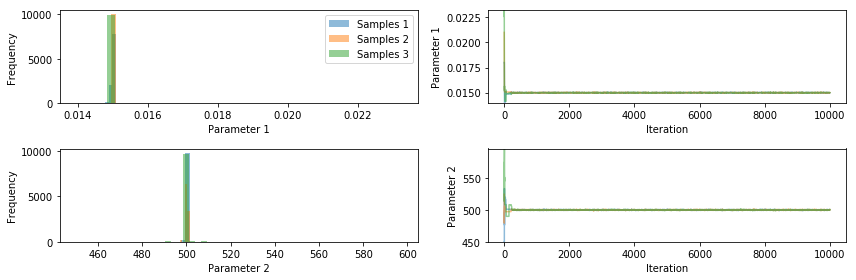

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

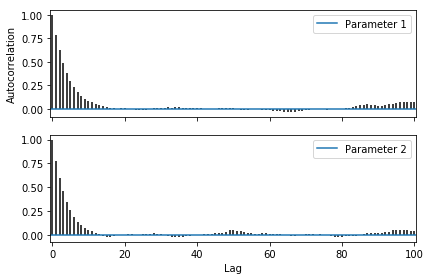

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

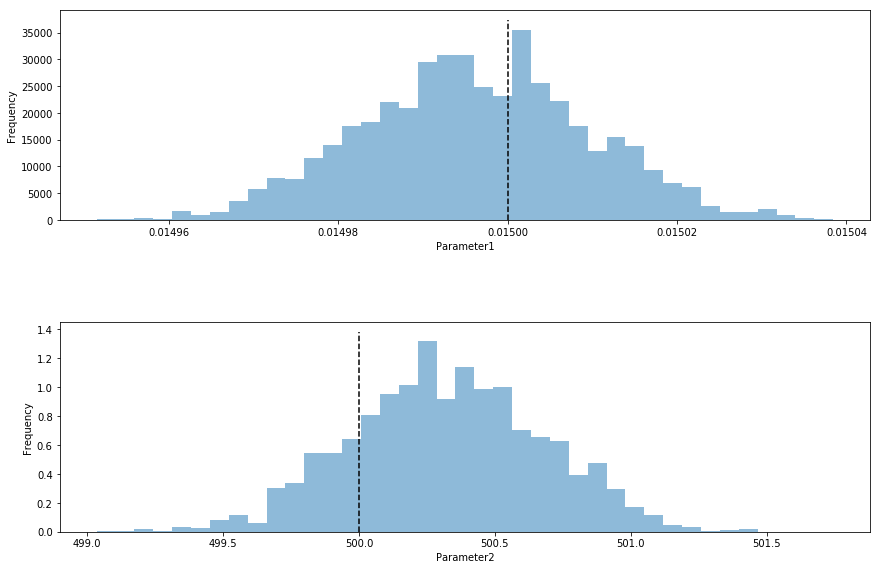

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

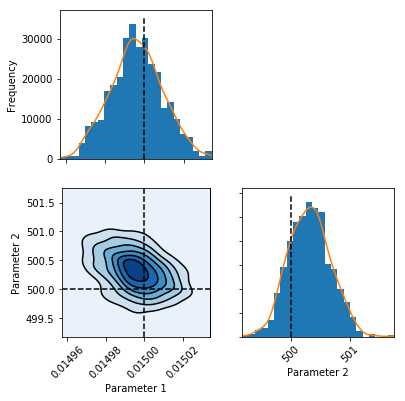

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

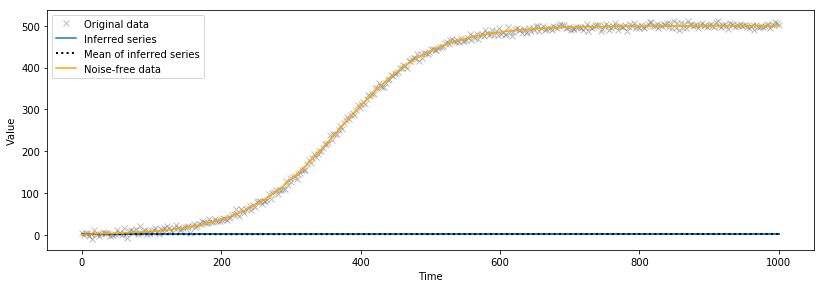

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1971.3468921599795
[0.72414058 1.0101612 ]
-1120659.4472704765


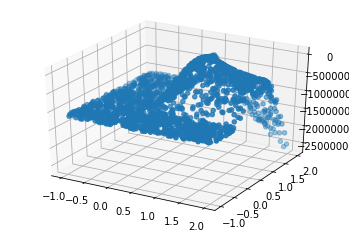

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[ 0.8016944  -0.34328154]
 [ 1.17232239  1.17792697]
 [ 0.2729802  -0.6951628 ]
 [ 0.91341335 -0.00665066]
 [-0.50797176  0.09559775]]


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [25]:
emu([0.015, 500])

array([[-71928260.]], dtype=float32)

In [26]:
log_likelihood([0.015, 500])

-1120659.4472704765

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


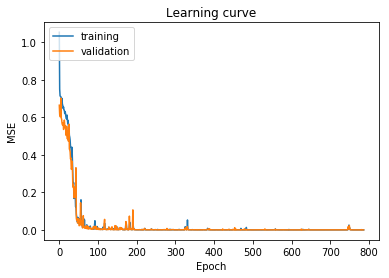

In [27]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


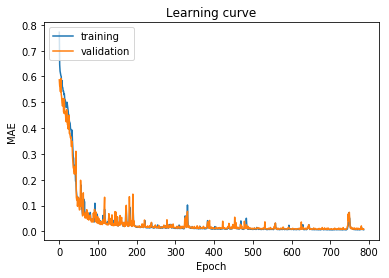

In [28]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

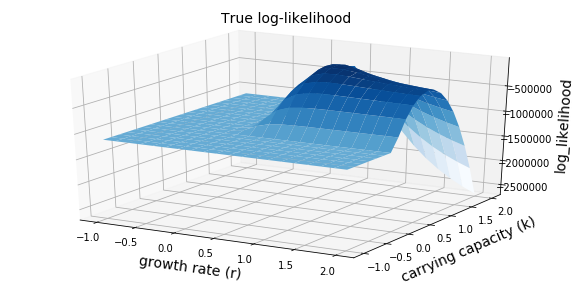

In [29]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

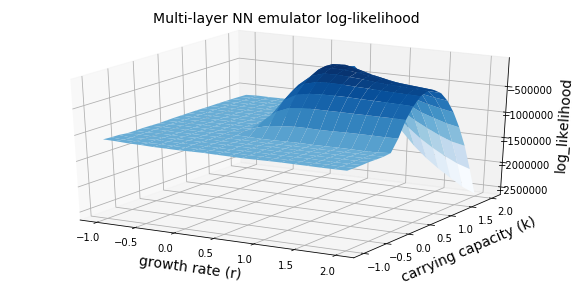

In [30]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

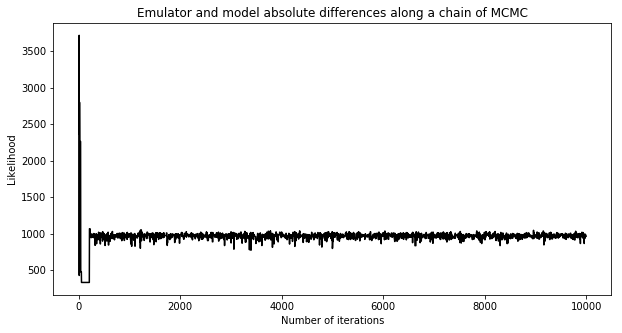

964.1368519707282

In [31]:
chain = chains_rescaled[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [32]:
print(emu_prediction)

[-23413.646  -23413.646  -23413.646  ...  -2176.7715  -2176.7715
  -2176.7715]


In [33]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [34]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[0.91838142 1.07536302]
-39539.71875


[1.28029075 1.29161898]
-381754.875


[1.17075323 1.13474082]
-178003.78125
accepted


1     6      0         0         0.5        0:00.0
[0.85432515 0.91495102]
-13775.46875
accepted


[1.0260893  1.10728009]
-94108.15625


[1.23943021 1.24023284]
-302817.09375


2     9      0.333     0         0.333      0:00.0
[0.8693946  0.91124586]
-16320.53125


[1.06007064 0.88255231]
-50576.65625
accepted


[1.19534122 1.21662963]
-255846.21875


3     12     0.25      0.25      0.25       0:00.0
[0.86530226 0.92435681]
-14954.96875


[1.11180594 0.90262463]
-60416.28125


[1.13342775 1.17577463]
-187864.34375


[0.81471396 0.88435967]
-12800.84375
accepted


[0.86191757 0.99206331]
-14223.34375
accepted


[1.09151979 1.12370135]
-136638.65625
accepted


[0.666

[0.66904495 1.03510221]
-6753.59375


[0.77861218 1.1526984 ]
-27141.59375


[0.73107605 0.96905287]
-3274.46875


[0.73658537 1.27316276]
-70206.71875


[0.70498651 1.1904857 ]
-30274.84375


[0.67474285 1.012567  ]
-5116.78125


[0.79121879 1.16208717]
-34766.78125


[0.74351447 1.05381712]
-2562.09375


[0.63601173 0.86023902]
-52442.40625


[0.65004231 0.90647966]
-31190.78125


[0.72567094 1.32603808]
-95162.09375


[0.67024104 0.99677955]
-6365.53125


[0.61296267 1.07844219]
-25425.28125


[0.53347326 0.88116208]
-121520.03125


[0.64152131 1.09662692]
-19264.59375


[0.71630658 1.09153384]
-9420.46875


[0.62353065 0.94108996]
-31700.65625


[0.51809917 1.08124772]
-96833.84375


[0.61142684 0.87526531]
-58132.28125


[0.67667129 0.94035201]
-12627.71875


[0.58643404 1.1109026 ]
-38507.78125


[0.57826521 1.10799693]
-42066.78125


[0.51586485 0.93876533]
-127648.28125


[0.59617931 1.03583333]
-32139.71875


[0.76753562 0.96273546]
-4119.09375


[0.65958393 1.07276999]
-10860


[0.75480657 1.11904135]
-15658.59375


[0.62553545 0.95324377]
-27483.53125


[0.62062858 1.01838463]
-18858.84375


[0.63659786 1.12249487]
-23931.09375


[0.74334324 0.95100565]
-4789.65625


[0.74625005 1.10813591]
-13349.53125


[0.79073359 0.97011663]
-5106.15625


[0.59461507 1.0781546 ]
-33316.53125


[0.78044524 0.89958086]
-10584.65625


[0.68567633 0.88644218]
-26214.96875


[0.69203916 0.92571827]
-13641.78125


[0.71251748 1.04997982]
-2734.46875


[0.79723638 1.05478991]
-7240.96875


[0.70835908 1.02758284]
286.34375


[0.66796773 1.08597456]
-10719.84375


[0.71898296 1.0567433 ]
-3345.90625


[0.58570444 1.25315193]
-62258.59375


[0.73162775 1.07102334]
-5714.40625


[0.557963   1.01274024]
-68121.15625


[0.80686893 1.09710519]
-16919.28125


[0.70405643 0.94101115]
-9343.53125


[0.64803869 1.09354866]
-16917.84375


[0.57359901 1.13209326]
-45402.15625


[0.75637335 1.15507719]
-23044.53125


[0.77651046 0.89676929]
-11440.34375


[0.78712141 0.93969436]
-7057.0937

[0.71194591 1.01476876]
827.53125


[0.7123056  1.01761356]
804.53125
accepted


[0.7099953  1.01345047]
826.34375


[0.71058894 1.01325376]
837.09375
accepted


[0.71361328 1.0186981 ]
783.34375


[0.71050698 1.01371464]
838.15625
accepted


[0.71160375 1.0164541 ]
821.03125


[0.71244907 1.01706955]
810.71875
accepted


[0.7099817  1.01349851]
828.53125


[0.71120026 1.01259817]
822.21875


[0.71281589 1.01655876]
811.59375
accepted


[0.71004649 1.01298518]
796.40625


[0.70865864 1.01084934]
437.71875


[0.71388749 1.01817494]
791.90625


[0.71116796 1.01404359]
834.90625


[0.70786578 1.0115237 ]
393.90625


[0.71304313 1.01650848]
808.03125


[0.71145375 1.0136808 ]
832.28125


[0.70933821 1.01193614]
618.21875


[0.71269124 1.01652936]
813.84375
accepted


[0.70994396 1.01348212]
822.53125


[0.71225143 1.01463709]
822.03125


[0.7121123  1.01765832]
804.53125


[0.7110692 1.0138861]
835.03125


[0.71184118 1.01521974]
828.65625


[0.71246008 1.01775629]
801.84375


[0.71073359 

[0.71023065 1.01415294]
837.90625


[0.71046008 1.01411497]
838.28125


[0.71026497 1.01411581]
838.46875


[0.71025886 1.01399184]
839.59375
accepted


[0.71005418 1.01377773]
840.03125
accepted


[0.71009851 1.01424669]
836.09375


[0.71014195 1.01369558]
840.03125
accepted


[0.71003614 1.01378103]
840.46875
accepted


[0.71024543 1.01309438]
830.78125


[0.71045245 1.01366779]
837.96875


320   963    0.118     0.109     0.174      0:01.9
[0.71017897 1.01403467]
838.96875


[0.71034194 1.01381795]
838.78125
accepted


[0.71018798 1.01401048]
839.15625


[0.71002108 1.01385797]
839.34375


[0.71045509 1.01396251]
838.40625
accepted


[0.71009965 1.01400609]
838.59375


[0.71016314 1.01390051]
839.96875
accepted


[0.71020284 1.01358576]
839.59375
accepted


[0.71020141 1.01359997]
839.78125
accepted


[0.70988389 1.01405678]
836.59375


[0.70997211 1.01314504]
799.40625


[0.71020844 1.01335315]
838.96875
accepted


[0.71025857 1.01388925]
839.15625


[0.70991262 1.01351082]
820.968

[0.71021434 1.01386262]
839.78125
accepted


[0.71030098 1.01311453]
838.40625
accepted


[0.70997849 1.01453337]
832.65625


[0.71011319 1.01396169]
838.78125


[0.70997591 1.01382972]
839.15625
accepted


[0.71034736 1.01335692]
838.59375


[0.71009077 1.01386141]
839.59375


[0.70973033 1.01404021]
834.03125


[0.71024035 1.01364498]
839.46875


[0.71059688 1.01375142]
837.28125


[0.71003581 1.0134314 ]
830.28125


[0.71001429 1.0131856 ]
808.03125


[0.71032911 1.01414918]
838.46875
accepted


[0.71012666 1.01388595]
839.78125
accepted


[0.71032507 1.01346211]
838.65625
accepted


[0.7102467  1.01426165]
837.03125


[0.71002698 1.01408331]
837.21875


[0.71024865 1.01416422]
837.78125


[0.71024938 1.01397273]
839.09375
accepted


[0.71015858 1.01381917]
839.65625
accepted


[0.71028693 1.01384851]
838.84375
accepted


[0.71033097 1.01431925]
837.09375


[0.71033766 1.01325762]
838.28125


[0.71046722 1.0135589 ]
837.71875


[0.70995867 1.0142584 ]
835.21875


[0.71010581 1.01366

[0.70968873 1.01377761]
809.21875


[0.71012882 1.01370617]
839.96875
accepted


[0.71035157 1.013569  ]
838.59375


[0.71047565 1.01303259]
837.21875


[0.70999487 1.01347963]
829.15625


[0.71018332 1.01372061]
839.46875
accepted


[0.70990459 1.01377922]
839.34375


[0.71026239 1.01364922]
839.34375


[0.71130712 1.01532805]
834.03125


[0.70950244 1.01432791]
822.53125


[0.71032711 1.01358772]
838.59375
accepted


[0.70986006 1.01331768]
798.71875


[0.70988542 1.01368427]
830.21875


[0.71025101 1.01361248]
839.15625
accepted


[0.70960217 1.01352511]
779.46875


[0.71038204 1.01378886]
838.59375


[0.71001066 1.01349827]
832.46875


[0.71020397 1.01373667]
839.34375
accepted


[0.70976501 1.0138708 ]
826.65625


[0.71042724 1.01340966]
837.59375


[0.70966181 1.01259715]
715.28125


480   1443   0.22      0.229     0.262      0:03.0
[0.71016522 1.0138937 ]
839.84375
accepted


[0.71067719 1.01314608]
836.34375


[0.71065452 1.01423794]
837.59375


[0.70981985 1.01412259]
835.531

[0.71051189 1.01437498]
837.59375


[0.70969136 1.01428103]
833.34375


[0.70989716 1.01358081]
824.21875


[0.71072955 1.01372084]
837.03125
accepted


[0.70980273 1.01424297]
834.65625


[0.70996999 1.01280707]
772.03125


[0.71064362 1.01297551]
834.65625


[0.71012831 1.01443223]
834.84375
accepted


[0.71034615 1.01388124]
839.09375
accepted


[0.71061023 1.01416329]
837.96875
accepted


[0.70996517 1.01347071]
824.28125


[0.71013455 1.01373541]
840.15625
accepted


[0.70962164 1.01394639]
812.09375


[0.70975212 1.01474515]
829.53125


[0.71070913 1.01452343]
837.28125


[0.71034498 1.01475472]
833.09375


[0.70961591 1.01409283]
821.65625


[0.71032938 1.01447033]
835.71875


[0.7101499  1.01442078]
834.84375


[0.70995612 1.01457469]
832.28125


[0.70960635 1.01325705]
760.78125


[0.71004159 1.01420382]
836.03125


[0.71007707 1.01435214]
835.03125
accepted


[0.71019594 1.01490236]
830.78125


[0.71075393 1.01471105]
836.21875


[0.70947747 1.01510661]
820.53125


[0.7097923

[0.71045289 1.01444292]
836.40625
accepted


[0.71025166 1.01376572]
839.15625
accepted


[0.70973887 1.01457765]
830.90625


[0.71099127 1.01474372]
836.40625
accepted


[0.71064027 1.01374041]
837.40625


[0.71099603 1.0140677 ]
835.53125


[0.71054422 1.0147729 ]
834.21875


[0.71018816 1.01287816]
806.09375


[0.71017455 1.01341531]
839.34375
accepted


[0.71181688 1.01580499]
828.71875


[0.71045771 1.01508707]
830.90625


[0.71007916 1.01386743]
839.65625
accepted


[0.71055549 1.01417076]
837.90625
accepted


[0.70989351 1.01330391]
801.78125


[0.70942256 1.01420211]
802.34375


[0.70932049 1.01217043]
637.09375


[0.7105213  1.01411296]
838.15625
accepted


[0.71055487 1.01341372]
837.28125


[0.71138965 1.01421737]
833.96875


[0.71041654 1.01409232]
838.78125
accepted


[0.70995992 1.01390508]
838.15625


[0.71118842 1.01479765]
835.59375


[0.71030606 1.01364952]
839.15625
accepted


[0.70989631 1.01371334]
833.84375


[0.71104247 1.01414731]
835.53125


[0.70994998 1.01393

[0.70996365 1.01423254]
835.59375
accepted


[0.71043158 1.01381315]
838.28125
accepted


[0.71125971 1.01475088]
835.40625


[0.70996826 1.01361544]
836.53125
accepted


[0.7102679  1.01370263]
838.78125
accepted


[0.71042205 1.01238746]
791.09375


[0.70999419 1.01406008]
837.46875
accepted


[0.70983345 1.01448073]
832.28125


[0.7107758  1.01441123]
837.40625


[0.71105142 1.01515749]
834.21875


[0.71031242 1.01492269]
831.40625


[0.70970145 1.01308144]
759.09375


[0.71116009 1.01425473]
835.40625


[0.71009014 1.01428548]
835.90625


[0.71068819 1.0134557 ]
836.59375


[0.7093725  1.01349827]
745.59375


[0.71068388 1.01395486]
837.21875


[0.71043935 1.0134621 ]
838.09375


720   2163   0.254     0.257     0.259362   0:04.3
[0.70912405 1.01388159]
737.15625


[0.71017992 1.01347752]
839.34375
accepted


[0.70952202 1.01272065]
707.03125


[0.70985916 1.0135842 ]
819.65625


[0.70986603 1.01330055]
798.03125


[0.70978896 1.01312857]
774.28125


[0.71075184 1.01559888]
827.656

[0.71013446 1.01394085]
839.34375
accepted


[0.71010388 1.01417557]
836.90625
accepted


[0.71135844 1.01351908]
831.28125


[0.70963554 1.0134907 ]
781.84375


[0.71082549 1.01383276]
836.40625
accepted


[0.71056206 1.0139983 ]
837.78125
accepted


[0.70955742 1.01354242]
774.28125


[0.71046604 1.01455943]
835.71875
accepted


[0.7100064  1.01433751]
834.71875


[0.71005905 1.01265245]
770.65625


[0.70959486 1.0147433 ]
827.46875


[0.71038866 1.01381652]
838.46875
accepted


[0.70903023 1.01276208]
645.46875


[0.71000681 1.01441692]
833.84375


[0.71012566 1.0137211 ]
840.28125
accepted


[0.71034519 1.01367527]
838.59375
accepted


[0.71065672 1.0159054 ]
824.28125


[0.71017051 1.01375311]
839.78125


[0.71091727 1.01387347]
836.21875


[0.7106665  1.01324864]
836.34375
accepted


[0.71039403 1.01388421]
838.78125


[0.71116317 1.01432169]
835.21875


[0.71101285 1.01468766]
836.40625
accepted


[0.71066719 1.01343729]
836.78125


[0.7102202  1.01336988]
839.15625
accepted


[

[0.71126042 1.01505874]
835.34375


[0.71016548 1.01271445]
789.21875


[0.71034562 1.01362203]
838.59375
accepted


[0.71105949 1.01473693]
836.03125


[0.71027562 1.01311409]
836.09375
accepted


[0.71041799 1.01372167]
838.59375
accepted


860   2583   0.247     0.26      0.258      0:05.0
[0.71037528 1.01491214]
831.59375


[0.70960953 1.01386244]
804.53125


[0.71052269 1.01371476]
837.59375
accepted


[0.71108916 1.01420293]
835.59375


[0.71006396 1.01392575]
838.84375
accepted


[0.71134218 1.01342754]
830.90625


[0.71098973 1.01540835]
831.28125


[0.71008348 1.01381921]
839.96875
accepted


[0.71097489 1.01283622]
827.96875


[0.71059769 1.01389778]
837.46875
accepted


[0.70980264 1.01350985]
806.09375


[0.71047386 1.01332863]
837.78125
accepted


[0.71097393 1.01418202]
835.84375


[0.7090159  1.01459307]
768.65625


[0.71063554 1.01300504]
834.84375


[0.71016127 1.01415302]
837.71875
accepted


[0.71031112 1.01187541]
731.46875


[0.71104573 1.01473808]
836.40625


[0.7

[0.71024454 1.01341858]
839.09375
accepted


[0.71064628 1.01273453]
831.65625


[0.7102071  1.01442399]
835.21875


[0.710379   1.01349219]
837.96875
accepted


[0.71038613 1.01511032]
830.03125


[0.71023529 1.01428057]
837.03125


[0.71062721 1.01304287]
835.59375


[0.71019389 1.01366931]
839.34375
accepted


[0.70975608 1.0143226 ]
833.53125


[0.71037381 1.01354501]
838.59375
accepted


[0.71003977 1.01354454]
839.78125
accepted


[0.71053844 1.01543914]
827.84375


[0.71147951 1.01356722]
830.53125


[0.71052277 1.01483798]
833.28125


[0.70988048 1.01369815]
830.40625


[0.71032224 1.01338869]
838.46875
accepted


[0.70991484 1.01379966]
839.15625
accepted


[0.710035  1.0143116]
835.15625


[0.7102952  1.01438101]
836.21875


[0.70974308 1.01426679]
833.46875


[0.71038834 1.01399694]
838.59375
accepted


940   2823   0.244     0.258     0.261424   0:05.4
[0.7095197  1.01256582]
694.34375


[0.71083582 1.01303402]
832.84375


[0.71018734 1.0126579 ]
786.96875


[0.71019726 1.0


[0.71027705 1.0142174 ]
837.71875


[0.7113147  1.01446321]
834.15625


[0.71103496 1.01348654]
835.15625


[0.7095918  1.01568391]
814.15625


[0.71052922 1.0135465 ]
837.78125
accepted


[0.71048818 1.01324895]
837.78125


[0.7099548  1.01244679]
739.53125


[0.71009723 1.01304167]
806.96875


[0.7102989  1.01369369]
838.84375


[0.70998042 1.01573226]
819.28125


[0.70936597 1.01325202]
727.21875


[0.71075621 1.0141615 ]
837.03125


[0.71123938 1.01471048]
835.21875


[0.71055144 1.01331543]
837.40625
accepted


[0.70977373 1.01344762]
797.71875


[0.71047479 1.0137104 ]
838.09375


[0.71094091 1.01449687]
836.78125
accepted


[0.7104044  1.01443112]
836.40625


[0.7097301  1.01164188]
639.65625


[0.71053673 1.01417254]
838.40625
accepted


[0.71001445 1.01323267]
811.71875


[0.71052192 1.01448428]
836.59375


[0.71070237 1.01459119]
837.21875


[0.70996104 1.01348569]
824.78125


[0.71091726 1.01459421]
836.78125


[0.71037502 1.01444972]
835.71875


[0.70982339 1.01314595]
779

[0.70949123 1.01425833]
816.03125


[0.70947379 1.0112804 ]
575.84375


[0.70931509 1.01304132]
704.96875


[0.71021677 1.01419604]
837.46875


[0.70942556 1.01078789]
525.46875


[0.70886661 1.01319243]
653.09375


[0.7096589  1.01328796]
770.15625


[0.7108643  1.01574193]
827.28125


[0.71018918 1.0142644 ]
836.59375
accepted


[0.70952268 1.01453006]
829.53125


[0.71022655 1.01293155]
815.15625


[0.70996846 1.01430448]
834.65625


[0.71005011 1.0134583 ]
834.53125


[0.71022697 1.01362079]
839.34375
accepted


[0.70996522 1.01412271]
836.21875
accepted


[0.71015553 1.01364058]
839.78125


[0.71048467 1.01431039]
838.40625
accepted


[0.71009019 1.01373612]
839.84375
accepted


[0.71023279 1.01361067]
839.15625


[0.710758   1.01506809]
833.09375


[0.7110613  1.01437884]
835.84375


[0.70961054 1.0139664 ]
811.96875


[0.71057178 1.01281484]
833.46875


[0.70998029 1.01379119]
839.78125
accepted


[0.71026741 1.01418757]
837.96875


[0.71009514 1.014163  ]
837.03125
accepted


[

[0.71062207 1.01406117]
837.78125
accepted


[0.71010035 1.01324513]
824.03125


[0.71053819 1.01396163]
837.78125
accepted


[0.7103557  1.01372983]
838.78125
accepted


[0.71194665 1.01608889]
824.59375


[0.71007293 1.01351399]
839.84375
accepted


[0.70988809 1.01358708]
823.53125


[0.71138756 1.01457615]
834.53125


[0.7102907  1.01403209]
839.65625


[0.70998628 1.01330906]
814.15625


[0.71105649 1.01379432]
835.15625


[0.70980703 1.01319182]
781.65625


[0.71049758 1.01374344]
838.15625
accepted


[0.71022042 1.01425835]
836.78125
accepted


[0.71044037 1.01349184]
837.96875


1160  3483   0.241     0.25      0.250646   0:06.6
[0.71078174 1.01443875]
837.40625
accepted


[0.70961437 1.01456874]
830.21875


[0.71090008 1.01358785]
835.71875


[0.71125754 1.01445794]
834.65625


[0.71038438 1.01397689]
838.78125
accepted


[0.71105905 1.01422449]
835.59375


[0.71086128 1.01376049]
836.21875


[0.71152504 1.01472199]
834.03125


[0.70904774 1.0131764 ]
677.59375


[0.71065154 1

[0.71150114 1.01508567]
834.53125


[0.71058086 1.01338376]
837.40625
accepted


1240  3723   0.24      0.25      0.249      0:07.1
[0.70988716 1.01329971]
800.65625


[0.71154739 1.01559112]
832.15625


[0.70936806 1.01093871]
532.15625


[0.71020774 1.01458537]
833.84375


[0.71039172 1.01395929]
838.65625
accepted


[0.71091611 1.01265786]
826.65625


[0.71003363 1.0151263 ]
827.15625


[0.71087374 1.01452382]
837.03125


[0.7097293  1.01204782]
675.90625


[0.71008344 1.01361054]
840.15625
accepted


[0.71016037 1.01338781]
839.59375
accepted


[0.70959709 1.01301885]
740.53125


[0.709947   1.01340067]
816.53125


[0.71131888 1.01421784]
834.46875


[0.71094595 1.01388758]
836.03125


[0.71043938 1.01345068]
837.96875


[0.71075912 1.01455425]
837.40625


[0.71195934 1.01379074]
823.40625


[0.70928489 1.01393204]
764.34375


[0.70982499 1.01275179]
748.78125


[0.70964441 1.01189402]
652.09375


[0.7097054  1.01355623]
795.96875


[0.70989707 1.01252912]
740.03125


[0.7103116  1



[0.71041297 1.0138704 ]
838.40625


[0.71058408 1.01289757]
834.34375


[0.71028895 1.01333074]
838.59375


[0.709845  1.0142997]
833.84375


[0.71060926 1.01290741]
833.96875


[0.70948173 1.01268487]
699.15625


[0.71028315 1.01436352]
836.40625


[0.71004669 1.01402915]
837.71875


[0.71064212 1.01379433]
837.59375


[0.71017349 1.01474801]
831.90625


[0.7103719 1.0133288]
838.40625
accepted


[0.71048472 1.0145687 ]
835.71875


[0.70965776 1.01446555]
831.21875


[0.71008342 1.01355756]
839.96875
accepted


[0.71028173 1.01378987]
839.15625


[0.71083815 1.01379488]
836.40625


[0.71017205 1.01309898]
821.46875


[0.71058915 1.01434884]
838.15625
accepted


[0.7098542  1.01452014]
832.15625


[0.70991706 1.0134686 ]
817.90625


[0.7105112  1.01413235]
838.78125
accepted


[0.71042153 1.01351324]
838.28125


[0.70991599 1.01409674]
836.40625


[0.7104233  1.01459696]
834.65625


[0.71001423 1.0135664 ]
837.96875


[0.71003563 1.01349714]
835.34375


[0.71029649 1.01397769]
839.28

[0.71050961 1.01482296]
833.46875


[0.70987543 1.01356389]
819.96875


[0.7107747  1.01308895]
833.96875


[0.7115189  1.01487064]
833.84375


[0.7104861  1.01410463]
838.46875
accepted


[0.71079223 1.01398258]
836.90625


[0.71028169 1.01358876]
838.96875
accepted


[0.71088844 1.01481927]
835.84375


[0.71022614 1.01290564]
812.96875


1400  4203   0.245     0.244     0.24       0:08.2
[0.70977604 1.01352539]
803.71875


[0.71043812 1.01367416]
838.40625
accepted


[0.71078142 1.01366754]
836.21875


[0.7114875  1.01460771]
834.03125


[0.71086753 1.01483835]
835.84375


[0.7108775 1.0138341]
836.21875


[0.71049555 1.01337531]
837.28125


[0.7101646  1.01300418]
812.65625


[0.70981118 1.01330627]
791.40625


[0.70992531 1.01294929]
777.53125


[0.70887412 1.01273119]
621.53125


[0.71023942 1.01386117]
839.59375
accepted


[0.71049701 1.01327075]
837.46875


[0.71060489 1.01451141]
836.90625


[0.71074422 1.01413473]
837.40625


[0.70990117 1.01326865]
799.78125


[0.71083267 1.0

[0.70969716 1.01286624]
741.28125


[0.70994146 1.01440414]
833.78125


[0.70933535 1.01356877]
745.59375


[0.71022532 1.01397621]
839.78125
accepted


[0.70986505 1.01402593]
836.34375
accepted


[0.71088627 1.01519253]
832.65625


[0.70979735 1.01356947]
809.71875


[0.71039978 1.01477779]
832.96875


[0.70991032 1.01323205]
798.53125


[0.70996022 1.01404503]
837.40625


[0.70965232 1.01333507]
773.09375


[0.70944305 1.01341294]
749.34375


[0.7094179 1.0146144]
826.34375


[0.71028079 1.01534076]
827.15625


[0.70986256 1.01378818]
834.46875


[0.70981936 1.01343026]
802.15625


[0.70956642 1.01406983]
812.90625


[0.70985552 1.01289996]
764.40625


[0.71031784 1.01379797]
839.15625
accepted


[0.70998065 1.01426605]
835.15625


[0.71025385 1.0141973 ]
837.96875


[0.71117163 1.01457853]
835.59375


[0.71110194 1.01558424]
830.40625


[0.70954788 1.01390222]
798.59375


[0.71041404 1.01318062]
837.78125


[0.70956321 1.01420858]
822.40625


[0.71070078 1.01442782]
837.46875


[0.

[0.70949859 1.0142368 ]
815.71875


[0.71040073 1.01415325]
838.78125


[0.71066456 1.01454838]
837.21875
accepted


[0.7100563  1.01388613]
839.78125


[0.70949468 1.01341927]
757.03125


[0.710647   1.01429609]
837.78125
accepted


[0.71028442 1.01281525]
812.96875


[0.71012672 1.01347699]
840.03125
accepted


[0.71145782 1.01546227]
833.65625


1580  4743   0.237     0.241     0.243      0:09.4
[0.71013039 1.01431232]
835.84375


[0.7105361  1.01348064]
837.78125


[0.71102364 1.01447697]
836.21875


[0.71035552 1.01429562]
837.59375


[0.71044969 1.01376917]
838.40625


[0.70892124 1.01237988]
602.28125


[0.71095322 1.01398712]
835.84375


[0.71000314 1.01350785]
832.09375


[0.71021277 1.0139659 ]
839.59375
accepted


[0.71008185 1.01261455]
769.71875


[0.70989626 1.01394856]
837.40625


[0.71109164 1.01519412]
834.15625


[0.70952182 1.01335571]
756.46875


[0.70989116 1.01345399]
813.59375


[0.7100407  1.01378684]
839.84375
accepted


[0.70972593 1.01314757]
767.65625


[0.7

[0.70994741 1.01291602]
777.84375


[0.71052851 1.01451816]
836.40625


[0.71044373 1.01447336]
836.34375
accepted


[0.71001252 1.01393792]
838.40625
accepted


[0.70999635 1.01305838]
795.34375


[0.71042799 1.01440426]
836.78125
accepted


[0.70953    1.01399037]
802.53125


[0.71019016 1.01359216]
839.46875
accepted


[0.71035    1.01395735]
838.96875
accepted


[0.70943614 1.01349559]
753.96875


[0.7097071  1.01348012]
791.09375


[0.71002073 1.01314677]
805.78125


[0.71020927 1.0147151 ]
832.34375


[0.70981218 1.01396707]
837.03125


[0.70961049 1.01318684]
755.96875


[0.71053499 1.01415141]
838.15625
accepted


[0.71010869 1.0137388 ]
840.15625
accepted


[0.71041415 1.01469356]
833.84375


[0.71067293 1.01461559]
836.71875


[0.70926793 1.01300574]
695.78125


1660  4983   0.242     0.235     0.241      0:09.7
[0.71067799 1.01302425]
834.84375


[0.7096212  1.01324181]
761.59375


[0.71042636 1.0140077 ]
838.78125


[0.7101567 1.0132214]
828.90625


[0.71041436 1.01428016]



[0.7109917  1.01433741]
836.40625


[0.71010788 1.01429429]
835.59375


[0.70989366 1.01369083]
831.78125


[0.71062757 1.0140784 ]
837.71875
accepted


[0.70974566 1.01289669]
750.28125


[0.70975565 1.01352015]
800.15625


[0.71088398 1.01411364]
836.40625


[0.71024837 1.01393764]
839.78125
accepted


[0.70980331 1.01373419]
822.53125


[0.71100834 1.01424268]
836.03125


[0.71167758 1.01440187]
831.90625


[0.70891928 1.01335169]
671.78125


[0.71068514 1.01391703]
837.03125
accepted


[0.71026177 1.01473911]
832.65625


[0.70987872 1.01302452]
777.53125


[0.71040842 1.01416887]
839.09375
accepted


[0.71032319 1.01384928]
838.78125


[0.7100234  1.01330713]
818.90625


[0.7101629  1.01385637]
839.78125
accepted


[0.71117853 1.01415589]
835.03125


[0.70990386 1.01361241]
827.53125


[0.71069068 1.0141802 ]
837.28125


[0.71097081 1.01499842]
834.90625


[0.70973469 1.01347647]
794.65625


[0.70977397 1.01316185]
775.15625


[0.70984897 1.01336054]
800.65625


[0.70963651 1.0137

[0.70949043 1.01323986]
743.46875


[0.71000301 1.01370068]
840.46875
accepted


[0.71110275 1.01456276]
835.71875


[0.70966073 1.01319215]
762.53125


[0.71030062 1.01362096]
838.78125


[0.71021681 1.0147187 ]
832.65625


1800  5403   0.233     0.235     0.242643   0:10.5
[0.7099125  1.01232486]
722.96875


[0.7099597  1.01329907]
810.03125


[0.71058601 1.01437589]
838.40625


[0.70990363 1.01323672]
797.40625


[0.71108255 1.01423219]
835.40625


[0.7098396  1.01336499]
799.46875


[0.71026257 1.01378575]
839.15625
accepted


[0.70981004 1.01349012]
805.90625


[0.71058653 1.01458979]
836.03125


[0.70992436 1.01368559]
836.03125


[0.7097868  1.01398138]
836.59375


[0.71125311 1.01578273]
829.34375


[0.71010028 1.0140959 ]
837.71875
accepted


[0.710196   1.01393097]
839.78125


[0.71076792 1.01356013]
836.21875


[0.71014507 1.01365984]
839.96875
accepted


[0.7100844 1.0141229]
837.21875


[0.71066693 1.0127527 ]
831.28125


[0.71011617 1.01398961]
839.09375


[0.70958504 1.0

840.28125
accepted


[0.71001023 1.01346269]
829.71875


[0.71033331 1.01374343]
838.96875


[0.70995709 1.01367821]
839.96875
accepted


[0.70965955 1.01331115]
772.03125


[0.71115601 1.01532455]
832.96875


[0.71075475 1.01431887]
837.59375


[0.71009298 1.01370265]
839.96875
accepted


[0.7089245  1.01279211]
632.78125


[0.70942201 1.01427725]
807.53125


[0.71021272 1.01352242]
839.46875
accepted


[0.70953934 1.01410949]
812.09375


[0.70970912 1.01366864]
804.40625


[0.70991648 1.01331349]
805.46875


[0.70980417 1.01300485]
766.03125


[0.71083793 1.01409355]
836.59375


[0.70963581 1.01332447]
770.03125


[0.71120168 1.01518665]
834.71875


1880  5643   0.234     0.232     0.242      0:10.9
[0.70954819 1.0129893 ]
732.03125


[0.7095069  1.01308521]
734.21875


[0.70945386 1.01329642]
742.65625


[0.70975847 1.01343162]
794.46875


[0.71021663 1.01404548]
838.96875
accepted


[0.7097261 1.0141403]
834.71875


[0.71081286 1.01452267]
836.78125


[0.71033833 1.0138977 ]
838.96

[0.70987268 1.01393319]
837.59375


[0.71085481 1.0147943 ]
836.03125


[0.70998985 1.01377605]
839.84375
accepted


[0.71099017 1.01433284]
836.59375


[0.71077051 1.01370594]
836.59375


[0.70989379 1.01352039]
819.09375


[0.70960789 1.01350005]
778.53125


[0.71051399 1.01350061]
837.96875


[0.71040423 1.01447311]
836.21875


[0.71034108 1.01447923]
835.84375


[0.71053749 1.01435269]
838.15625
accepted


[0.70971121 1.01298108]
752.34375


[0.70974618 1.01358703]
804.09375


[0.7111367  1.01399023]
834.71875


[0.70921086 1.01275895]
669.59375


[0.71030242 1.01370352]
839.46875
accepted


[0.71073954 1.01400957]
837.03125
accepted


[0.7101789  1.01408817]
838.28125


[0.7099695  1.01394954]
838.15625
accepted


[0.71063252 1.01421773]
837.78125
accepted


[0.71005864 1.01386827]
839.59375
accepted


[0.71064423 1.01495632]
833.28125


[0.71095288 1.01427288]
836.40625


[0.70954916 1.01368494]
783.40625


[0.70961767 1.01365652]
791.09375


[0.71015444 1.01409465]
838.09375
acc

[0.71083471 1.01372677]
836.03125


[0.71090247 1.01464239]
836.78125
accepted


[0.71042641 1.01419282]
838.59375
accepted


[0.71158006 1.01423939]
832.78125


[0.7118899  1.01605551]
825.15625


[0.70988433 1.01377515]
836.71875
accepted


[0.71058215 1.01307662]
836.78125


[0.71048827 1.01489135]
832.96875


[0.71035166 1.01379394]
838.84375
accepted


[0.70993294 1.0120564 ]
701.40625


[0.71205082 1.01554334]
825.15625


[0.71060913 1.01326344]
836.78125


[0.71064146 1.01324751]
836.78125


[0.71120001 1.01493005]
835.21875
accepted


[0.710078   1.01366255]
840.15625
accepted


[0.71066942 1.01303068]
835.15625


[0.71115328 1.01473085]
835.84375
accepted


[0.70987654 1.01377385]
835.34375


[0.71023996 1.01331761]
838.65625
accepted


[0.70999645 1.01454404]
832.84375


[0.70975278 1.01349479]
798.40625


[0.71032118 1.01262282]
799.90625


[0.71024833 1.01349546]
839.15625
accepted


[0.71031054 1.01292314]
824.96875


[0.70994072 1.01319736]
799.40625


[0.70991443 1.01313

[0.7112372  1.01560908]
830.71875


[0.71030333 1.01294747]
826.15625


[0.71060989 1.01254055]
827.53125


[0.71200377 1.01617921]
823.40625


2100  6303   0.239     0.238     0.246      0:12.0
[0.7104399  1.01233682]
788.84375


[0.7110142  1.01414754]
835.90625
accepted


[0.70845781 1.01440352]
673.96875


[0.71082004 1.01349871]
836.21875


[0.7106209  1.01556719]
827.34375


[0.71213195 1.01464635]
824.46875


[0.71040765 1.01363737]
838.40625


[0.71164915 1.01517177]
832.09375


[0.71026386 1.01506422]
829.53125


[0.71032689 1.01388005]
839.09375


[0.71086775 1.0127397 ]
828.40625


[0.71097084 1.01504988]
834.46875
accepted


[0.70830675 1.01301415]
558.71875


[0.71019088 1.01471105]
832.46875


[0.71144649 1.01500356]
834.46875
accepted


[0.70895311 1.01349836]
686.21875


[0.71151505 1.0135676 ]
830.09375


[0.7114905  1.01436823]
833.46875


[0.70946379 1.01340655]
752.09375


[0.71075323 1.01473397]
836.21875
accepted


[0.71096277 1.01402067]
836.09375
accepted


[0.7

[0.70960113 1.01257446]
705.65625


[0.71018036 1.01385176]
839.65625
accepted


[0.71004179 1.01469836]
831.40625


[0.71023787 1.01377924]
839.28125
accepted


[0.70972274 1.01353865]
797.03125


[0.71027929 1.01476124]
832.59375


[0.71018613 1.01357679]
839.34375
accepted


[0.70959571 1.01450276]
830.09375


[0.70956344 1.01274229]
714.09375


[0.70998822 1.01357104]
835.53125


[0.71051809 1.01498738]
832.09375


[0.71096618 1.01585873]
826.78125


[0.7103372  1.01437193]
836.78125


[0.71065879 1.01373459]
837.09375


[0.70967942 1.01273588]
728.40625


2180  6543   0.234     0.237     0.247      0:12.4
[0.71000652 1.01257392]
757.46875


[0.70997981 1.01441978]
833.65625


[0.71072409 1.01460987]
837.03125


[0.70979949 1.01290493]
757.65625


[0.70986757 1.01390749]
837.96875


[0.71005381 1.01434373]
834.90625


[0.70907527 1.01289528]
661.34375


[0.71090585 1.01406328]
836.03125


[0.71014241 1.01301482]
810.78125


[0.71088939 1.014392  ]
836.78125


[0.70984892 1.01413584

[0.71037082 1.01392348]
838.78125
accepted


[0.71026588 1.01361082]
839.15625
accepted


[0.71166174 1.01473087]
832.15625


[0.71013041 1.01451717]
833.84375


[0.71101443 1.01380359]
835.34375


[0.71112724 1.01583335]
827.96875


[0.71055161 1.01367834]
837.78125


[0.71035243 1.01342955]
838.78125


[0.71042983 1.01428287]
838.09375
accepted


[0.71038039 1.01390829]
838.84375
accepted


[0.71053818 1.01345435]
837.40625


[0.70945524 1.01302939]
723.28125


[0.71130817 1.01418606]
834.34375


[0.70966941 1.01293379]
743.09375


[0.70970552 1.01403645]
829.90625


[0.71004339 1.01363067]
840.15625
accepted


[0.70894127 1.01240433]
606.78125


[0.71086255 1.01510052]
833.09375


[0.70973791 1.01370489]
810.78125


[0.71008657 1.01321404]
819.59375


[0.70944497 1.01376717]
774.65625


2260  6783   0.238     0.235     0.241      0:12.7
[0.71038085 1.0138951 ]
838.84375


[0.7113647  1.01400529]
834.03125


[0.71137195 1.01432437]
833.84375


[0.70896662 1.01335415]
678.78125


[0.7

[0.70972745 1.01369842]
809.21875


[0.71141035 1.01530483]
835.34375


[0.71102128 1.01297743]
829.34375


[0.71018613 1.0137387 ]
839.59375
accepted


[0.70999986 1.01239382]
740.09375


[0.71088786 1.01351822]
835.59375


[0.71006074 1.01340234]
831.46875


[0.70946209 1.01386897]
784.21875


[0.70997243 1.01150616]
657.03125


[0.70947721 1.01273639]
702.59375


[0.71059705 1.01359089]
837.40625


[0.71120495 1.01219856]
817.28125


[0.70939728 1.01424187]
801.34375


[0.70954569 1.01231542]
677.90625


[0.71057697 1.01305437]
836.71875
accepted


[0.7099806  1.01409088]
837.03125


[0.71050426 1.01330989]
837.90625


[0.71073854 1.01162763]
760.96875


[0.71081859 1.01399856]
836.90625


[0.71070441 1.01199224]
789.90625


[0.71009729 1.01194056]
711.34375


[0.70952014 1.0137923 ]
787.28125


[0.71157451 1.01518952]
833.34375


[0.71085078 1.01307258]
832.78125


[0.70987801 1.01336638]
804.59375


[0.71034046 1.01336698]
838.78125


[0.71064093 1.01255012]
829.53125


[0.7098821

[0.70983752 1.01401835]
836.59375


[0.71150775 1.01476515]
833.96875


[0.71189929 1.01435925]
828.34375


[0.71002563 1.01357527]
840.46875
accepted


[0.71005552 1.01372994]
840.03125
accepted


[0.71127704 1.01318299]
828.40625


[0.70980859 1.01344145]
801.96875


[0.71027138 1.01392273]
839.15625
accepted


[0.71067698 1.01255602]
829.15625


[0.70990143 1.01281364]
763.46875


[0.71023354 1.0134491 ]
838.96875
accepted


[0.71120121 1.01419597]
834.71875
accepted


[0.70967525 1.01404937]
826.96875


[0.71194283 1.01427804]
827.34375


[0.71015168 1.01374742]
839.34375
accepted


[0.71035502 1.01401134]
839.15625


[0.71154477 1.01438018]
833.46875


[0.7106177  1.01319285]
836.90625


[0.70984391 1.01359199]
817.71875


[0.71022681 1.01376341]
839.15625
accepted


[0.70984801 1.01437998]
833.46875


[0.71033975 1.01432331]
837.21875


[0.71132891 1.01495481]
835.03125


[0.71092737 1.01306455]
831.65625


[0.71050482 1.01370288]
837.96875


[0.70986389 1.01367133]
826.59375


[

[0.71024425 1.01378843]
839.09375
accepted


[0.71081069 1.0134946 ]
836.40625


[0.71018406 1.01389601]
839.78125
accepted


[0.71020894 1.01389093]
839.96875
accepted


[0.71003884 1.01340367]
828.40625


[0.71089404 1.01528528]
831.78125


[0.71082744 1.01397473]
836.59375


[0.71014776 1.01311856]
819.84375


[0.71068881 1.01401473]
837.21875


[0.70988887 1.01368616]
831.09375


[0.7106205  1.01335679]
837.21875


[0.71066277 1.01344142]
836.90625


[0.71067849 1.0145253 ]
837.59375


[0.71109447 1.0136667 ]
834.65625


[0.70967027 1.01420595]
833.53125


[0.70955547 1.0143617 ]
831.65625


[0.71022906 1.01338791]
838.96875
accepted


[0.71077533 1.01434933]
836.90625


[0.71072984 1.01404935]
837.03125


[0.71098128 1.01366768]
835.40625


[0.70948278 1.01514372]
820.09375


[0.70992596 1.01383699]
838.96875
accepted


[0.70986357 1.01278566]
756.53125


[0.70951845 1.01443698]
830.53125


[0.71006484 1.01356686]
840.15625
accepted


[0.71035996 1.01386168]
838.59375


[0.7100541

836.03125


[0.71062337 1.01351873]
837.21875


[0.70931116 1.01345892]
734.09375


[0.70953612 1.01342351]
762.78125


[0.71116902 1.01419772]
835.03125


[0.71050359 1.01298798]
836.21875


[0.71008295 1.0129569 ]
798.71875


[0.71085177 1.01406104]
836.53125


[0.71075894 1.01525273]
831.09375


[0.70934775 1.014288  ]
797.21875


[0.71055052 1.01427178]
838.09375


[0.71073881 1.01438571]
837.28125
accepted


[0.71029589 1.01313596]
838.40625


[0.71057106 1.01332489]
837.40625
accepted


[0.71034637 1.01424515]
837.59375
accepted


[0.71062424 1.01414418]
837.71875


[0.71085294 1.01299609]
832.09375


[0.70969181 1.01298376]
750.15625


[0.70996272 1.01372845]
840.15625
accepted


[0.71064331 1.01378126]
837.40625
accepted


[0.71081485 1.01494138]
834.53125


[0.70940123 1.0138089 ]
771.71875


[0.71110441 1.0140404 ]
835.34375


[0.70990677 1.01492178]
828.21875


[0.7097466  1.01350286]
798.03125


[0.71013677 1.01451908]
834.03125


[0.710596   1.01473978]
835.21875


[0.7099

[0.71124285 1.01365771]
833.96875


[0.71000133 1.01386126]
839.09375


[0.71082072 1.01461562]
837.40625


2640  7923   0.24      0.228     0.238546   0:14.6
[0.70915303 1.01198645]
600.09375


[0.7100497  1.01381136]
839.59375
accepted


[0.70851575 1.01181151]
504.40625


[0.71000397 1.01233424]
735.15625


[0.70974463 1.0134843 ]
796.40625


[0.71065994 1.0146291 ]
836.34375


[0.70923035 1.01225969]
632.59375


[0.71105686 1.01422358]
835.53125


[0.70893913 1.01172502]
550.65625


[0.71074663 1.01363453]
836.34375
accepted


[0.71024127 1.01447145]
835.21875


[0.70991151 1.01281386]
764.84375


[0.71084053 1.0147802 ]
836.40625
accepted


[0.70966225 1.01449818]
830.90625


[0.7093057  1.01268693]
676.09375


[0.71169918 1.01431192]
831.65625


[0.70943509 1.01272664]
696.09375


[0.71038645 1.0138865 ]
838.96875
accepted


[0.71008028 1.013782  ]
840.53125
accepted


[0.71010712 1.01457092]
832.96875


[0.71067505 1.01384789]
837.78125


[0.71126929 1.01496374]
835.59375


[0.7


[0.71061237 1.01239478]
814.96875


[0.71024066 1.01392869]
839.34375
accepted


[0.7109746  1.01411366]
836.03125


[0.71013273 1.01393953]
839.59375
accepted


[0.71048014 1.01465468]
834.71875


[0.71003474 1.01333021]
822.21875


[0.71025663 1.01390822]
839.34375
accepted


[0.71019026 1.01376463]
839.59375
accepted


[0.70978928 1.01317711]
778.09375


[0.7097008  1.01398427]
825.59375


[0.71027673 1.01427711]
837.03125


[0.71117846 1.01412864]
834.71875


[0.71089506 1.01482532]
835.59375


[0.70966165 1.01405759]
825.78125


[0.7089923  1.01358978]
698.34375


[0.71035082 1.01409962]
839.15625
accepted


[0.71007959 1.0143898 ]
834.71875


[0.70998128 1.01357852]
835.03125


[0.70998969 1.01356454]
834.90625


[0.71002538 1.01407188]
837.40625


[0.70976137 1.01333547]
786.90625


[0.71065528 1.01339436]
837.03125


[0.71074776 1.01364338]
836.71875


[0.71080654 1.01436228]
837.21875


[0.71034555 1.0137678 ]
838.84375
accepted


[0.70982728 1.01367085]
820.96875


[0.709840

[0.71082979 1.0123353 ]
824.03125


[0.71072682 1.01283252]
831.65625


[0.7107067  1.01435498]
837.40625


[0.7110254  1.01374639]
835.21875


[0.71123005 1.01239244]
819.15625


[0.70984989 1.01257866]
738.03125


[0.7102118 1.0135607]
839.34375


[0.71085594 1.01301571]
832.09375


[0.71012161 1.01375902]
839.65625


2800  8403   0.237     0.231     0.236      0:15.4
[0.7098877  1.01354313]
820.34375


[0.71048787 1.01240765]
800.78125


[0.71027931 1.01393665]
839.09375


[0.7096376  1.01374199]
799.96875


[0.71097576 1.01451879]
836.21875
accepted


[0.71079149 1.01389287]
836.78125


[0.71090861 1.01445784]
836.78125
accepted


[0.71107968 1.01519282]
833.46875
accepted


[0.71023611 1.01375552]
839.46875
accepted


[0.7101662  1.01361467]
839.59375
accepted


[0.71119958 1.01492718]
835.53125
accepted


[0.70997204 1.013217  ]
805.21875


[0.70926635 1.01290027]
688.03125


[0.71158082 1.01603629]
826.59375


[0.7100799  1.01330269]
825.78125


[0.70977841 1.01335056]
790.71875

[0.71035165 1.01409224]
838.96875
accepted


[0.71078594 1.0135888 ]
836.21875


[0.7100325  1.01427515]
835.53125


[0.71023836 1.0137377 ]
839.28125
accepted


[0.71010529 1.01372113]
839.65625
accepted


[0.71074846 1.01417621]
837.21875


[0.70969608 1.01332389]
777.71875


[0.71016582 1.01463723]
833.09375


[0.71087177 1.014897  ]
835.40625


[0.71003648 1.01420581]
836.09375


[0.71027176 1.01409684]
838.84375
accepted


[0.71012278 1.01424153]
836.21875
accepted


[0.71017036 1.01307058]
818.65625


[0.71007192 1.01499807]
829.03125


[0.70957926 1.0135471 ]
777.71875


[0.70913909 1.0135629 ]
717.84375


[0.70950536 1.01343983]
760.21875


[0.70957249 1.01379493]
794.46875


2880  8643   0.237     0.232     0.237      0:15.7
[0.71056683 1.01423404]
838.40625
accepted


[0.7096803  1.01381377]
810.90625


[0.71004934 1.01423727]
836.09375
accepted


[0.70961843 1.01347027]
777.71875


[0.71048942 1.01519075]
830.09375


[0.71025    1.01456236]
834.21875
accepted


[0.71024581 1

[0.71026775 1.01342677]
838.78125
accepted


[0.71076229 1.01469017]
836.78125


[0.7102056  1.01378722]
839.59375
accepted


[0.71061247 1.01345806]
837.40625


[0.71055724 1.01413608]
838.09375


[0.71051898 1.01381698]
837.78125


[0.71074617 1.01342697]
836.40625


[0.70988047 1.01315404]
788.15625


[0.7106511  1.01427562]
837.40625


[0.7109617  1.01347304]
835.84375


[0.71027533 1.0138501 ]
839.15625
accepted


[0.71017914 1.01474687]
831.90625


[0.71042578 1.01405052]
838.96875
accepted


[0.70927219 1.01278244]
679.65625


[0.71084128 1.01393397]
836.59375


[0.71029884 1.01397117]
839.34375
accepted


[0.71070271 1.01446504]
837.78125


[0.71029803 1.01356798]
838.78125
accepted


[0.71010611 1.01407258]
837.78125


[0.7104686  1.01414356]
838.40625
accepted


[0.70972085 1.01233685]
700.90625


[0.71037341 1.01387134]
838.65625


[0.71099001 1.01520701]
833.09375


[0.71040051 1.01350201]
838.15625
accepted


[0.71103428 1.01448301]
836.21875


[0.71053564 1.01414699]
838.

[0.7106126  1.01446036]
837.40625
accepted


[0.71074876 1.01561198]
827.53125


[0.71029935 1.01396698]
839.28125
accepted


[0.71067163 1.01354035]
836.59375


[0.71033876 1.0144117 ]
836.03125


[0.70953427 1.01305391]
735.40625


[0.71052165 1.01470838]
834.46875


[0.70937747 1.0132685 ]
729.96875


[0.71128988 1.01517803]
835.21875


[0.71061855 1.01464709]
835.84375


[0.71034765 1.01268127]
808.21875


[0.71086504 1.01322969]
834.65625


[0.71056894 1.01403659]
837.90625
accepted


[0.70941185 1.01281707]
700.21875


[0.71027215 1.0135283 ]
838.84375
accepted


[0.7114419  1.01420724]
833.78125


[0.71028318 1.01364378]
839.09375


[0.71112335 1.01393315]
835.15625


[0.7107183  1.01413122]
837.28125
accepted


[0.70999804 1.01387519]
838.96875


[0.70985218 1.01383197]
836.21875


[0.71191376 1.01506972]
827.71875


[0.7102347  1.01385992]
839.34375


[0.71129277 1.01363634]
833.84375


[0.71102094 1.01398631]
835.84375


[0.70992111 1.01306518]
786.40625


[0.70968257 1.01272

[0.71046853 1.01260246]
815.90625


[0.71057188 1.01444059]
837.28125


[0.7096407  1.01380656]
804.90625


[0.71018438 1.01220592]
745.59375


[0.71052587 1.01335325]
837.59375
accepted


[0.71038608 1.01409912]
839.09375
accepted


[0.71025064 1.01421349]
837.46875
accepted


[0.71042283 1.01353189]
838.40625
accepted


[0.70941301 1.01418172]
799.65625


[0.71042045 1.01363124]
838.40625
accepted


[0.71037839 1.0136363 ]
838.15625
accepted


[0.7112077  1.01462042]
835.34375


[0.71001645 1.01373578]
840.34375
accepted


[0.71023709 1.01391706]
839.59375
accepted


[0.71043976 1.01462707]
835.03125


[0.70889945 1.01278678]
628.96875


[0.70954623 1.01182978]
633.84375


[0.71054289 1.01377301]
837.96875
accepted


[0.71000619 1.01340732]
824.59375


[0.7109869  1.01549509]
830.40625


[0.711185   1.01439089]
835.40625


[0.71020827 1.0145873 ]
833.78125


[0.71010239 1.01363176]
839.96875
accepted


[0.71083555 1.01434493]
836.59375


[0.71070234 1.01411453]
837.09375


[0.7104655

[0.70964097 1.01329519]
768.65625


[0.71033109 1.01421937]
838.28125
accepted


[0.71042719 1.01303334]
837.40625


3180  9543   0.236     0.24      0.238      0:17.2
[0.71081854 1.0145401 ]
837.40625


[0.71042365 1.01428451]
837.78125


[0.71001984 1.013348  ]
821.46875


[0.70953383 1.01286049]
720.03125


[0.70985739 1.01339236]
804.28125


[0.71012731 1.01272842]
785.78125


[0.7103078  1.01395303]
839.28125


[0.71056208 1.01455791]
836.40625


[0.71092161 1.01340855]
835.40625


[0.71010027 1.01486902]
829.90625


[0.7096841 1.0141291]
833.84375


[0.71063106 1.01273577]
832.09375


[0.71003526 1.01456314]
833.28125


[0.71065029 1.01507781]
832.15625


[0.71045929 1.01325368]
837.59375
accepted


[0.71082592 1.01444855]
837.03125


[0.71005196 1.01495095]
829.40625


[0.71073218 1.01367996]
836.78125
accepted


[0.70947713 1.01381275]
782.28125


[0.71021287 1.01284233]
806.09375


[0.71103753 1.01313253]
831.21875


[0.71046963 1.01395749]
838.46875


[0.70916618 1.01455427]


accepted


[0.71059128 1.01304255]
836.03125


[0.71035634 1.01459339]
834.65625


[0.70960236 1.01283358]
726.53125


[0.71063598 1.01472507]
835.03125


[0.70963527 1.01361923]
790.90625


[0.71055688 1.01348848]
837.59375
accepted


[0.71077541 1.01493107]
834.21875


3260  9783   0.232444  0.238     0.238      0:17.6
[0.71002736 1.0134414 ]
830.09375


[0.71065053 1.01295129]
834.21875


[0.71052645 1.013223  ]
837.40625


[0.71068541 1.01425811]
837.21875


[0.71046641 1.01319941]
837.40625
accepted


[0.7100203  1.01330509]
818.09375


[0.70989854 1.01426672]
834.71875


[0.71053773 1.01344873]
837.59375
accepted


[0.71010835 1.01260025]
771.84375


[0.70999331 1.01364413]
840.53125
accepted


[0.71048082 1.01281998]
834.71875


[0.71041907 1.01513119]
829.71875


[0.70986283 1.01362671]
822.84375


[0.71084734 1.01377107]
836.09375


[0.70952344 1.01300887]
730.53125


[0.71001267 1.01459878]
832.28125


[0.71045274 1.01307074]
837.78125
accepted


[0.71174384 1.01383141]
829.3

[0.71040611 1.0136901 ]
838.28125


[0.70978177 1.01482958]
828.71875


[0.71006728 1.01462669]
832.28125


[0.71010325 1.01403051]
838.28125


[0.7102496  1.01317231]
837.03125


[0.70904354 1.01281509]
650.90625


[0.7102478  1.01390539]
839.59375
accepted


[0.71067112 1.01423256]
837.59375


[0.70993556 1.01336148]
811.96875


[0.71040262 1.01409505]
838.84375


[0.7100785  1.01369377]
840.34375
accepted


[0.70982952 1.01342562]
803.15625


[0.71107434 1.01418271]
835.84375


[0.71026723 1.01265075]
795.53125


[0.70999117 1.01464722]
831.90625


[0.70991078 1.01381513]
838.96875


[0.70980301 1.01368938]
819.28125


[0.70874282 1.01501079]
756.28125


3340  10023  0.231     0.238     0.239      0:18.0
[0.71059348 1.01482977]
833.96875


[0.70972822 1.01436984]
832.34375


[0.71135506 1.01461496]
834.46875


[0.71003997 1.01357278]
840.15625
accepted


[0.71011815 1.01288236]
797.09375


[0.71080068 1.0143305 ]
837.09375


[0.70979623 1.01272873]
743.28125


[0.71001459 1.01421716

[0.71030271 1.01326507]
838.40625
accepted


[0.71116795 1.01413634]
834.84375
accepted


[0.71043616 1.01318108]
837.59375
accepted


[0.71063673 1.01218543]
798.90625


[0.71079139 1.01340411]
836.09375
accepted


[0.71014177 1.01285188]
797.71875


[0.71035725 1.01318171]
837.96875
accepted


[0.71107035 1.01318237]
831.46875


[0.71047641 1.01333585]
837.46875
accepted


[0.71031354 1.01413191]
838.78125
accepted


[0.71036445 1.01268818]
811.21875


[0.71085888 1.01337003]
836.09375


[0.71019092 1.01468817]
832.65625


[0.71043329 1.01225166]
780.09375


[0.71091616 1.01402528]
836.03125


[0.71008602 1.01298514]
801.15625


[0.70931428 1.01169814]
593.90625


[0.70992288 1.01397374]
837.90625
accepted


[0.70975843 1.01356036]
803.71875


[0.71116645 1.01412502]
835.03125
accepted


[0.7101397  1.01418594]
836.90625
accepted


[0.71018643 1.0133955 ]
839.46875
accepted


[0.71061309 1.01399901]
837.40625
accepted


[0.71032704 1.01470541]
833.53125


[0.71000576 1.01283598]
779.

[0.70926295 1.01299231]
694.21875


[0.7100391  1.01224425]
731.46875


[0.71130132 1.01316915]
827.71875


[0.71087853 1.0135516 ]
836.03125


[0.70991244 1.01395409]
837.46875


[0.70984064 1.01338291]
801.34375


[0.71068222 1.01408111]
837.40625
accepted


[0.71091904 1.01365366]
835.59375


[0.71007457 1.0131586 ]
813.84375


[0.7111989  1.01313919]
829.15625


[0.71008293 1.01309295]
809.40625


[0.71013089 1.01334785]
836.03125


[0.710794   1.01304308]
833.46875


[0.70949506 1.01390754]
791.59375


[0.71043081 1.01340591]
837.90625


[0.7116811  1.01438467]
831.90625


[0.71003734 1.01364345]
840.15625
accepted


[0.7100202 1.0148011]
830.28125


[0.7105143  1.01566122]
825.59375


[0.70995663 1.01345908]
822.21875


[0.71030698 1.0132955 ]
838.28125
accepted


[0.7106288  1.01477532]
834.84375


[0.71102767 1.01385543]
835.21875


[0.7098595  1.01262396]
742.84375


[0.71086313 1.01457268]
837.03125
accepted


[0.71068745 1.0135494 ]
836.71875


[0.70974612 1.01423488]
834.03

[0.71000761 1.01333762]
819.28125


[0.71048293 1.01458219]
835.71875


[0.7107162  1.01478928]
835.03125


[0.71045488 1.01366093]
838.15625
accepted


[0.70954963 1.0138489 ]
795.15625


[0.71055094 1.01439882]
837.90625
accepted


[0.71058301 1.01431187]
838.28125
accepted


[0.71074759 1.01434291]
837.40625


[0.71052957 1.0153664 ]
828.34375


[0.71045449 1.01404061]
838.78125
accepted


[0.7102601  1.01407822]
838.78125
accepted


[0.71082691 1.01472198]
836.78125


[0.71085039 1.01378913]
836.40625


[0.71009929 1.01257798]
768.84375


[0.71026363 1.01450701]
834.84375


[0.71094568 1.01467347]
836.78125


[0.71064993 1.01394356]
837.21875


[0.70976415 1.013837  ]
824.09375


[0.71047503 1.01355566]
837.78125


[0.7095814  1.01296818]
734.59375


[0.7106616  1.01466397]
836.09375


[0.71166362 1.01476695]
832.15625


[0.70934104 1.01404406]
779.78125


[0.710829   1.01418096]
836.78125


[0.71061239 1.01418084]
837.96875
accepted


[0.70936667 1.01462743]
822.84375


[0.7110879

[0.70972389 1.01389219]
822.65625


[0.71125408 1.01427712]
834.65625


[0.70909897 1.01307876]
677.59375


[0.7097908  1.01360953]
811.71875


[0.70980586 1.01298793]
765.53125


[0.71002892 1.01369831]
840.28125
accepted


[0.70994123 1.01357257]
829.71875


[0.70920791 1.01339636]
715.28125


[0.70940063 1.0143446 ]
808.84375


[0.70997297 1.01376321]
839.96875
accepted


[0.70994496 1.01440193]
833.84375


[0.70998404 1.01500059]
828.21875


[0.71018295 1.0137614 ]
839.59375
accepted


[0.71062128 1.01291729]
833.78125


[0.71016793 1.01401983]
838.84375


[0.71000549 1.01507113]
827.71875


[0.7106264  1.01382535]
837.40625
accepted


[0.71073408 1.01384934]
836.90625


[0.71083617 1.01385291]
836.59375


[0.71052769 1.01249578]
813.59375


[0.70957866 1.0138504 ]
799.21875


[0.7102262 1.0138378]
839.65625
accepted


[0.71004756 1.01243801]
749.96875


[0.70867683 1.01252909]
579.40625


[0.71017644 1.01336049]
838.96875


[0.7105727  1.01324716]
837.03125
accepted


[0.70986145 

837.21875


[0.71092991 1.01419048]
836.21875


[0.71086996 1.01361808]
835.90625


3720  11163  0.228     0.236     0.235      0:19.8
[0.71085829 1.01481968]
835.84375


[0.70953775 1.0129352 ]
726.40625


[0.71007974 1.0143891 ]
834.46875


[0.71037597 1.01391539]
838.78125
accepted


[0.71113201 1.01436238]
835.40625


[0.71112729 1.01392721]
835.03125


[0.71026068 1.01364538]
839.15625
accepted


[0.70886531 1.01241946]
597.84375


[0.71024984 1.01345447]
838.84375
accepted


[0.71041549 1.01340173]
837.71875
accepted


[0.71092475 1.01494472]
835.03125


[0.70956558 1.0126072 ]
703.65625


[0.70998568 1.01398181]
838.09375
accepted


[0.71080038 1.015736  ]
827.15625


[0.70946466 1.01396168]
791.34375


[0.7093793  1.01440295]
809.40625


[0.71045406 1.01367381]
838.09375
accepted


[0.71057819 1.01358802]
837.59375
accepted


[0.71011556 1.01423302]
836.21875
accepted


[0.7084699  1.01177495]
495.34375


[0.71008979 1.01392916]
839.34375
accepted


[0.70983669 1.01420636]
834.

[0.70976633 1.01388069]
827.84375


[0.71073694 1.01478288]
835.34375


[0.70982314 1.01368449]
821.53125


[0.71016526 1.0134385 ]
839.34375
accepted


[0.71002787 1.01359193]
840.15625
accepted


[0.71015174 1.01414197]
837.40625


[0.71090122 1.01281021]
829.15625


[0.71018528 1.01403818]
838.78125


[0.71072371 1.01336204]
836.59375


3800  11403  0.23      0.236     0.233      0:20.2
[0.70990949 1.01432355]
834.03125


[0.7096247  1.01357415]
785.96875


[0.70970024 1.01337987]
783.03125


[0.71060686 1.01305388]
835.90625


[0.71041747 1.01413571]
839.15625
accepted


[0.70961087 1.0135515 ]
782.65625


[0.71024692 1.01365857]
839.34375
accepted


[0.71071229 1.01410858]
837.21875


[0.70996703 1.01443951]
833.78125


[0.71040876 1.01349787]
838.15625


[0.710989   1.01428581]
836.09375


[0.70917278 1.01338753]
709.46875


[0.71008891 1.01359766]
839.96875
accepted


[0.71036483 1.01416277]
838.59375
accepted


[0.7095762 1.0139574]
806.46875


[0.70960258 1.01426411]
832.09375

[0.70988562 1.01354344]
819.84375


[0.70874212 1.01392864]
683.90625


[0.71153135 1.01461604]
833.28125


[0.71029523 1.01413877]
838.15625


[0.71013049 1.01320355]
824.59375


[0.71055878 1.01493741]
832.65625
accepted


[0.71042629 1.01327678]
837.46875


[0.71053411 1.0144707 ]
836.90625
accepted


[0.71076913 1.01592641]
824.90625


[0.70972721 1.01362974]
804.28125


[0.71227277 1.01527404]
821.65625


[0.71055015 1.01576047]
824.96875


[0.71030603 1.01367742]
838.96875


[0.71032505 1.01566478]
824.71875


[0.71034585 1.01473721]
833.65625
accepted


3880  11643  0.229     0.237     0.234      0:20.6
[0.7098174  1.01381525]
829.90625


[0.71078403 1.01540253]
829.71875


[0.71104652 1.01481656]
836.09375
accepted


[0.70961539 1.0138653 ]
805.40625


[0.70974347 1.01398972]
832.09375


[0.71131073 1.01510521]
835.59375
accepted


[0.71023852 1.01360127]
839.09375


[0.71145196 1.01693543]
815.53125


[0.71117238 1.01544871]
831.90625


[0.70968061 1.01420202]
833.65625


[0.7

[0.71024907 1.01432183]
836.53125


[0.70945883 1.01328948]
742.46875


[0.71077565 1.01363962]
836.21875


[0.70912807 1.01165313]
567.09375


[0.70957116 1.01319297]
750.96875


[0.70974862 1.0136172 ]
806.46875


[0.70957102 1.01269802]
711.46875


[0.70960301 1.0124933 ]
699.53125


[0.7105516  1.01325124]
837.59375


[0.7092664  1.01280775]
680.84375


[0.70984327 1.01332216]
797.03125


[0.71062749 1.01436965]
837.96875


[0.71095781 1.01390654]
836.03125


[0.71108904 1.01542992]
831.78125


[0.71076086 1.01316507]
835.53125


[0.71106826 1.0144966 ]
835.71875


[0.710747   1.01330522]
836.21875


[0.71034316 1.01446843]
835.59375


[0.7103457  1.01554328]
825.90625


[0.70935885 1.01237403]
658.15625


[0.71016922 1.01404999]
838.40625
accepted


[0.70865293 1.01181446]
522.28125


[0.7101586  1.01391438]
839.96875


3960  11883  0.228     0.238     0.235      0:21.0
[0.70971596 1.01394532]
825.46875


[0.70924581 1.01317392]
705.03125


[0.70948317 1.01328384]
745.90625


[0.7

[0.71026163 1.01338883]
838.84375
accepted


[0.71128073 1.01436378]
834.65625


[0.71016341 1.01422831]
837.03125


[0.71026419 1.0139351 ]
839.15625
accepted


[0.71126448 1.01555201]
831.59375


[0.70911287 1.01407145]
748.40625


[0.7099162 1.0140399]
836.78125


[0.71110577 1.01459573]
835.59375


[0.71022788 1.01438982]
835.53125


[0.70997706 1.01359046]
835.53125


[0.70948882 1.01415395]
808.21875


[0.71037508 1.01510583]
829.71875


[0.710231   1.01459817]
833.84375


[0.71089291 1.01494633]
834.84375


[0.71004847 1.01413758]
836.78125


[0.71000264 1.01455857]
832.65625


[0.70911526 1.01452602]
779.03125


[0.71015812 1.01427953]
836.40625
accepted


[0.71049411 1.01428069]
838.59375
accepted


[0.70887585 1.01319092]
654.71875


[0.70954188 1.0136142 ]
777.40625


[0.71084768 1.01391486]
836.34375


[0.71056279 1.01423742]
838.15625
accepted


[0.70990101 1.01454448]
832.09375


[0.71070511 1.01477656]
835.15625


[0.71070653 1.01404427]
837.03125


[0.70981762 1.0143345



[0.71055384 1.01467715]
835.40625


[0.71104743 1.01527205]
832.65625


[0.70970555 1.01337321]
783.03125


[0.71102574 1.01392462]
835.59375


[0.70974065 1.0144223 ]
832.28125


[0.71005954 1.01311386]
807.84375


[0.71039149 1.01410213]
838.59375
accepted


[0.71048432 1.0144822 ]
836.59375
accepted


[0.71019787 1.01383238]
839.34375
accepted


[0.70994486 1.01411772]
836.53125


[0.71003114 1.01424645]
836.03125


[0.71074742 1.0133099 ]
836.21875


[0.71018447 1.01387996]
840.03125
accepted


[0.7105022 1.0153073]
828.90625


[0.70955142 1.01307067]
738.84375


[0.7097319  1.01405734]
835.34375


[0.71129057 1.0153645 ]
833.34375


[0.71047366 1.01303508]
837.59375
accepted


[0.71030582 1.01378867]
839.15625
accepted


[0.70962991 1.01268044]
717.65625


[0.70943023 1.01229027]
660.84375


[0.7105054  1.01439206]
837.59375


[0.71001649 1.01523936]
826.28125


[0.711461   1.01346776]
829.59375


[0.71045001 1.0143685 ]
837.09375


[0.71089128 1.01491248]
834.84375


[0.7111171

[0.7111911 1.0136067]
834.46875


[0.71013866 1.01381813]
839.96875
accepted


[0.7094112  1.01364656]
761.40625


[0.71081434 1.01347615]
836.03125


[0.71120995 1.01373858]
833.84375


[0.71039256 1.01411544]
838.96875


[0.71068309 1.01361653]
836.78125
accepted


[0.70999992 1.01492257]
828.90625


[0.71026144 1.01383987]
839.46875
accepted


[0.71082987 1.01306496]
833.28125


[0.71064327 1.01410552]
837.78125


[0.7104455  1.01435574]
837.59375


[0.71030757 1.01336625]
838.96875
accepted


[0.71049517 1.01382325]
837.90625


[0.71118824 1.01321384]
829.84375


[0.70974914 1.01440743]
832.34375


[0.71055036 1.01441736]
837.46875


[0.71009871 1.01370667]
839.96875
accepted


[0.7104726 1.0131599]
837.59375
accepted


[0.71036413 1.01477781]
832.78125


[0.71036292 1.01421841]
838.46875
accepted


[0.70998305 1.01348092]
827.34375


[0.7096328  1.01329279]
767.21875


[0.71031248 1.01405776]
838.96875
accepted


[0.71121614 1.01350994]
833.34375


[0.70897436 1.01318837]
667.8437

[0.70914655 1.01349974]
714.03125


[0.70992709 1.01451846]
832.34375


[0.70971559 1.01359613]
800.34375


[0.71028836 1.01320754]
838.40625


[0.7103602  1.01311674]
838.15625
accepted


[0.71091079 1.01479993]
836.59375


[0.71042856 1.01461464]
835.34375


[0.71066993 1.01338723]
836.90625


[0.71005574 1.01403759]
837.78125
accepted


[0.7106493  1.01325704]
836.78125


[0.71064536 1.01394653]
837.78125


[0.70942938 1.01477378]
824.21875


[0.71029929 1.01340334]
838.40625


[0.71034712 1.01279304]
818.28125


[0.71027739 1.01457317]
834.34375


[0.70987103 1.01445052]
832.59375


[0.71029963 1.01298985]
829.15625


[0.71010224 1.01417438]
836.78125
accepted


[0.71044262 1.01383173]
838.59375


[0.71069878 1.01285258]
832.28125


[0.70972182 1.01455267]
830.90625


[0.71002273 1.01350146]
834.21875


[0.71009867 1.01289625]
795.65625


[0.7097793  1.01353826]
805.09375


[0.71060368 1.01494593]
833.15625


[0.71048847 1.01261832]
819.96875


[0.70971909 1.01465521]
829.84375


[

[0.71089331 1.01363604]
835.84375


[0.71032761 1.01372171]
838.96875
accepted


[0.71049653 1.01390266]
838.15625
accepted


4340  13023  0.229     0.231     0.234      0:22.8
[0.71096722 1.01224078]
820.84375


[0.71085019 1.01379929]
836.09375


[0.71024068 1.01469209]
832.84375


[0.71045295 1.01350313]
837.90625
accepted


[0.71034039 1.0149066 ]
831.28125


[0.70998862 1.01279617]
773.96875


[0.71075064 1.01334477]
836.09375


[0.71037287 1.01380471]
838.65625
accepted


[0.71086624 1.01390067]
836.40625
accepted


[0.70950907 1.01301512]
728.96875


[0.71070007 1.01335434]
836.34375


[0.71114193 1.01444923]
835.21875


[0.71034327 1.0138746 ]
838.96875
accepted


[0.71057085 1.01228116]
799.40625


[0.71076413 1.01336287]
836.21875


[0.71035469 1.01423371]
837.78125


[0.71057262 1.01410404]
838.15625
accepted


[0.71104829 1.01382962]
835.40625
accepted


[0.70965159 1.01261624]
715.46875


[0.71039246 1.01438895]
836.59375


[0.71090828 1.01299691]
831.40625


[0.7094022  1

[0.70972608 1.01242997]
709.96875


[0.71037362 1.01422998]
838.59375
accepted


[0.71030555 1.01288578]
821.53125


[0.71056957 1.0151856 ]
830.40625


[0.71012586 1.0145874 ]
833.09375


[0.71029749 1.01378098]
838.96875
accepted


[0.71032582 1.01314483]
838.09375


[0.71079943 1.01475735]
836.40625


[0.71018952 1.0137523 ]
839.65625
accepted


[0.71091163 1.01420736]
836.40625


[0.70986639 1.01498263]
827.84375


[0.710191   1.01379968]
839.96875
accepted


[0.71029234 1.01411077]
838.59375
accepted


[0.7100661  1.01419585]
836.40625
accepted


[0.71062042 1.01346396]
837.03125


[0.71029607 1.01396478]
839.15625
accepted


[0.71028003 1.01445807]
835.53125


4420  13263  0.229     0.232     0.234      0:23.2
[0.70942314 1.01388373]
780.46875


[0.7092143 1.0132402]
705.34375


[0.71049154 1.01495237]
832.09375


[0.7098997  1.01479295]
829.53125


[0.71002796 1.01327032]
816.53125


[0.70995391 1.01389196]
838.59375
accepted


[0.71084459 1.01434391]
836.90625


[0.71024416 1.0

[0.70956821 1.01380061]
794.34375


[0.71006176 1.0127249 ]
777.15625


[0.70997045 1.01445971]
833.15625


[0.7103563  1.01338996]
838.59375


[0.70993707 1.01305366]
787.46875


[0.70946501 1.01386341]
784.59375


[0.7106378  1.01464088]
835.90625


[0.71014705 1.01391315]
839.84375
accepted


[0.70978833 1.01366035]
814.84375


[0.71031567 1.0139191 ]
839.34375
accepted


[0.71044796 1.01440774]
837.09375


[0.7102032  1.01391331]
839.46875
accepted


[0.71121096 1.01406245]
834.53125


[0.71006313 1.01486538]
830.09375


[0.7099147  1.01382982]
838.46875


[0.71015285 1.01424606]
836.40625


[0.70995279 1.01303149]
787.65625


[0.71039758 1.0147892 ]
832.84375


[0.70974088 1.01346628]
794.28125


[0.70965994 1.01480597]
827.34375


[0.71013588 1.01392332]
839.46875
accepted


4500  13503  0.228     0.232     0.234      0:23.6
[0.7105274  1.01307035]
836.90625


[0.70972444 1.01379094]
815.53125


[0.70897896 1.01295593]
652.09375


[0.70971946 1.01325936]
775.84375


[0.7114382 1.

[0.70985301 1.01356886]
817.78125


[0.71103868 1.01382984]
835.03125


[0.71039265 1.01295784]
837.90625
accepted


[0.70958517 1.01276982]
719.15625


[0.71137007 1.01410293]
834.03125


[0.71019823 1.0135675 ]
839.28125
accepted


[0.70905661 1.01390934]
728.78125


[0.71131533 1.01431259]
834.34375


[0.71054654 1.01310161]
837.28125
accepted


[0.70978337 1.01348214]
801.34375


[0.7102064  1.01285002]
806.09375


[0.71041067 1.01321177]
837.78125
accepted


[0.71109093 1.01363795]
834.71875


[0.71027521 1.01275543]
806.28125


[0.71006436 1.01319484]
815.15625


[0.70949593 1.01366781]
774.84375


[0.71107193 1.01268039]
824.96875


[0.71054826 1.01337252]
837.21875


[0.7098227  1.01254614]
732.03125


[0.70985773 1.01249517]
731.84375


[0.71102721 1.01330933]
833.65625


[0.7101934  1.01257561]
780.46875


[0.71011104 1.01298396]
804.53125


[0.71062773 1.01363177]
836.90625


[0.71011106 1.0143302 ]
835.84375


[0.71099178 1.01331582]
834.34375


[0.71029585 1.01348855]
838.

[0.71039417 1.01373865]
838.78125
accepted


[0.7108658  1.01434663]
837.03125


[0.71015932 1.01325467]
832.09375


[0.70974829 1.01307832]
764.71875


[0.71061112 1.01286526]
833.46875


[0.71057124 1.01284415]
834.03125


[0.71118039 1.01446717]
835.40625


[0.7111993 1.0144965]
835.40625


[0.71015945 1.01331558]
837.40625


[0.71043618 1.01406193]
838.59375
accepted


[0.71119007 1.01371165]
834.34375


[0.7101344  1.01389544]
839.96875
accepted


[0.71054382 1.01426172]
838.40625
accepted


[0.71132092 1.01394714]
834.46875


[0.71047007 1.013139  ]
837.21875


[0.71081258 1.01474404]
835.90625


[0.71063879 1.01358139]
837.03125


[0.71022109 1.01343747]
838.96875
accepted


[0.71099181 1.01433868]
836.03125


[0.71014691 1.01375047]
839.59375
accepted


[0.70994544 1.01386268]
838.78125
accepted


[0.70970209 1.01341249]
785.09375


[0.70993121 1.01263058]
752.71875


[0.70975311 1.01370908]
813.46875


[0.71075534 1.01344028]
836.21875


[0.71117112 1.01454694]
835.21875


[0.

[0.71062969 1.01371636]
837.21875


[0.71010847 1.01449878]
833.84375


[0.71038301 1.01411883]
838.84375
accepted


[0.71034145 1.01282071]
820.28125


[0.7101381  1.01417166]
837.21875


[0.71046296 1.01462395]
835.03125


[0.71004305 1.01431038]
835.03125


[0.71075599 1.01293763]
832.78125


[0.71039522 1.01409663]
838.96875
accepted


[0.7106806  1.01337911]
836.59375


[0.71061491 1.01323509]
836.78125


[0.71009789 1.01379824]
839.84375
accepted


[0.71013616 1.01476253]
831.65625


[0.71044153 1.0132036 ]
837.78125


[0.70970833 1.01341839]
786.96875


[0.70940885 1.0129352 ]
709.40625


[0.71061936 1.01348251]
837.21875


[0.71039154 1.0138667 ]
838.59375
accepted


[0.71051894 1.01429065]
838.46875
accepted


[0.71012328 1.01355209]
839.78125
accepted


[0.71075372 1.01413368]
837.21875


[0.7109085  1.01386977]
835.84375


[0.71026779 1.01383223]
839.34375
accepted


[0.7103732  1.01283048]
824.90625


[0.71038432 1.01412441]
838.84375
accepted


[0.70953594 1.01361478]
776.

[0.71064861 1.01335784]
836.78125


[0.70989009 1.01382914]
838.78125
accepted


[0.71009696 1.01508056]
828.15625


[0.71029159 1.01264709]
798.40625


[0.70997751 1.01387972]
838.65625
accepted


[0.71053705 1.01360308]
837.78125
accepted


[0.71019675 1.0130219 ]
818.40625


[0.71038423 1.01365993]
838.59375
accepted


[0.71078602 1.01358287]
836.59375


[0.71015125 1.01304162]
813.96875


[0.71040529 1.01386292]
838.78125
accepted


[0.7097042  1.01260007]
721.03125


[0.71051858 1.01331897]
837.46875
accepted


[0.71103697 1.01435325]
835.84375


[0.71025657 1.01299695]
824.21875


[0.710791   1.01286531]
831.09375


[0.71036273 1.01352454]
838.59375
accepted


[0.70995077 1.0127321 ]
763.15625


[0.71026573 1.01324359]
838.78125
accepted


[0.7095753  1.01347484]
772.21875


[0.71000431 1.01338496]
822.40625


[0.70996909 1.01319294]
802.53125


[0.71117529 1.0132739 ]
831.09375


[0.71037443 1.01367432]
838.59375
accepted


[0.71024229 1.01369878]
839.46875
accepted


[0.7102954

[0.71060041 1.01464071]
836.03125


[0.71018308 1.01430465]
836.03125


[0.70991154 1.0145047 ]
832.65625


4880  14643  0.228027  0.234     0.234      0:25.5
[0.70963553 1.01415552]
828.71875


[0.7103869  1.01421424]
838.40625


[0.70989312 1.01375292]
836.40625


[0.70988667 1.0129635 ]
773.40625


[0.71010975 1.01366152]
839.78125


[0.71058627 1.0141427 ]
837.78125
accepted


[0.71016219 1.01372092]
839.59375
accepted


[0.70996997 1.01385799]
838.96875


[0.71020287 1.01365807]
839.15625
accepted


[0.71055311 1.01448434]
837.03125


[0.70937462 1.01331287]
732.65625


[0.7104784  1.01387112]
838.40625


[0.71010334 1.01291267]
797.78125


[0.70979604 1.01264993]
736.84375


[0.70954305 1.01291558]
725.53125


[0.71062135 1.01377309]
837.28125


[0.71017184 1.01326954]
834.84375


[0.71002148 1.01397327]
838.40625
accepted


[0.71012405 1.01401836]
838.59375


[0.70963745 1.01238278]
695.03125


[0.70951093 1.01347033]
762.96875


[0.70991764 1.01289759]
772.59375


[0.71041166 1

[0.70976513 1.01287059]
750.71875


[0.71005688 1.01377573]
840.34375
accepted


[0.7102052  1.01399787]
838.96875
accepted


[0.70958519 1.01184137]
639.65625


[0.71060045 1.01399507]
837.90625


[0.71040085 1.01435614]
837.09375


[0.70982822 1.01256502]
734.28125


[0.71035928 1.01492973]
831.46875


[0.71064014 1.01426496]
837.59375
accepted


[0.70984869 1.01266288]
744.84375


[0.7106529  1.01368285]
837.03125


[0.71054977 1.01314886]
837.03125
accepted


4960  14883  0.23      0.232816  0.235      0:25.9
[0.71107958 1.01362006]
834.71875


[0.71097122 1.01376044]
835.53125


[0.71101166 1.01294885]
828.90625


[0.71014779 1.0126008 ]
776.71875


[0.7093958  1.01400022]
784.21875


[0.7097242  1.01178257]
651.65625


[0.71084917 1.01392541]
836.40625


[0.71070687 1.01363388]
837.09375


[0.71093006 1.01305081]
831.46875


[0.71050475 1.01260277]
820.34375


[0.71031835 1.01397717]
839.09375
accepted


[0.71044727 1.01234561]
790.21875


[0.7101569  1.01345423]
839.34375
accept

[0.71078172 1.01491223]
834.53125


[0.70969835 1.014011  ]
827.53125


[0.7107667 1.0133451]
836.40625


[0.70929061 1.01354331]
737.15625


[0.71018841 1.01353381]
839.34375
accepted


[0.70955478 1.01313739]
744.34375


[0.71072023 1.0142693 ]
837.21875


[0.70985476 1.01364381]
822.90625


[0.7101036  1.01405444]
837.96875


[0.71041274 1.0143529 ]
837.03125


[0.7104992  1.01308556]
836.90625


[0.7106823  1.01347777]
836.90625


5040  15123  0.229     0.235     0.235      0:26.2
[0.71054624 1.01465795]
835.21875


[0.71028379 1.01387102]
839.96875
accepted


[0.71039145 1.01277827]
822.53125


[0.71034583 1.01429729]
837.40625
accepted


[0.71006951 1.01426327]
836.03125


[0.71041467 1.01301563]
837.21875


[0.71093177 1.01418572]
836.34375


[0.71032879 1.01365676]
838.59375


[0.71029298 1.01384386]
839.09375
accepted


[0.70999907 1.01514415]
827.15625


[0.71086742 1.01480902]
835.90625


[0.71018315 1.01440785]
835.40625


[0.71118056 1.01584074]
828.34375


[0.71124531 1.0

[0.70918837 1.01237587]
636.40625


[0.71054358 1.01391439]
837.78125
accepted


[0.71042067 1.0132218 ]
837.90625
accepted


[0.71123811 1.01448836]
835.03125


[0.71012877 1.0139601 ]
839.15625
accepted


[0.71027512 1.0130034 ]
827.15625


[0.71015226 1.01434898]
835.59375


[0.71027913 1.01459662]
834.03125


[0.71023588 1.01275765]
801.53125


[0.71094874 1.01496477]
835.40625


[0.71058952 1.01451785]
836.59375


[0.71078756 1.0134872 ]
836.40625
accepted


[0.7112371  1.01414517]
835.03125


[0.70989491 1.01377924]
838.40625


[0.71060439 1.013369  ]
836.59375
accepted


[0.71068111 1.01374301]
836.90625


[0.70997424 1.01451812]
832.96875


[0.7103083  1.01327089]
838.28125
accepted


[0.70929658 1.01387058]
761.15625


[0.71026025 1.01362693]
838.78125


[0.70984432 1.01376542]
830.28125


5120  15363  0.229     0.234     0.234      0:26.6
[0.70902366 1.01366699]
708.09375


[0.71093227 1.01360405]
835.59375


[0.71023352 1.01267537]
794.28125


[0.71000338 1.01426321]
835.593

[0.70963517 1.01357614]
787.78125


[0.70952043 1.01290871]
721.71875


[0.70990055 1.01342409]
812.21875


[0.71044796 1.01475418]
833.65625


[0.71006383 1.01378401]
840.34375
accepted


[0.71032685 1.01263753]
801.96875


[0.71045402 1.01373161]
838.15625
accepted


[0.71014672 1.01472981]
832.46875


[0.71046754 1.01359823]
838.15625


[0.70994078 1.01474649]
830.09375


[0.70940611 1.01342881]
745.15625


[0.71063976 1.01441589]
837.96875
accepted


[0.71011993 1.01337485]
837.03125
accepted


[0.7099184  1.01451431]
832.65625


[0.7100624 1.0147795]
830.90625


[0.71081305 1.01380553]
836.40625


[0.71016226 1.01307019]
817.59375


[0.71068214 1.01379611]
837.28125
accepted


[0.70995759 1.01357266]
831.96875


[0.7097702  1.01378361]
821.46875


[0.71076459 1.01389276]
837.03125


[0.7100948  1.01345513]
839.59375
accepted


[0.70965936 1.01352744]
787.96875


[0.7106711  1.01348555]
837.21875
accepted


[0.71049036 1.01378091]
838.09375


[0.7106085  1.01450327]
837.28125
accep

[0.71138239 1.01415756]
833.84375


[0.70921887 1.01338608]
716.28125


[0.71173872 1.01541375]
830.71875


[0.71019083 1.01431246]
836.40625


[0.71055895 1.01339994]
837.21875


[0.71129308 1.01613219]
826.09375


[0.7103991  1.01378838]
838.59375
accepted


[0.70952072 1.01268306]
703.84375


[0.71214795 1.01452219]
823.78125


[0.71100703 1.01358344]
835.40625


[0.71075098 1.01289624]
832.28125


[0.71155557 1.01670854]
818.21875


[0.71161051 1.01333596]
825.59375


[0.71078942 1.01268454]
828.71875


[0.71092806 1.0156229 ]
828.90625


[0.71057267 1.01342926]
837.46875


[0.70999039 1.0129907 ]
789.34375


[0.71119451 1.0154441 ]
832.28125


[0.70969126 1.01288409]
741.90625


[0.71122959 1.01403743]
834.65625


[0.71193553 1.01548801]
827.15625


[0.71032693 1.01329678]
838.59375
accepted


[0.70984808 1.01282571]
757.65625


[0.71089833 1.01483679]
835.90625
accepted


[0.7093523  1.01313715]
717.28125


[0.71052669 1.01463617]
835.03125


[0.7111402 1.014818 ]
835.71875
accep

[0.7107734  1.01440668]
837.21875


[0.7096044  1.01283392]
726.90625


[0.71070955 1.01453769]
837.28125
accepted


[0.71022154 1.01403504]
839.15625
accepted


[0.70921467 1.01408936]
764.71875


[0.71090475 1.01442398]
836.78125
accepted


[0.71044914 1.01317509]
837.78125
accepted


[0.71000001 1.01372463]
840.34375
accepted


[0.7109841  1.01391468]
835.84375


[0.71039143 1.01334149]
837.96875
accepted


[0.7096071  1.01287311]
730.46875


[0.71088992 1.01574158]
827.46875


[0.71039295 1.01384858]
838.84375
accepted


[0.70923305 1.01253454]
654.90625


[0.70990733 1.01401517]
837.09375
accepted


[0.71084261 1.01484896]
835.34375


[0.70883628 1.01339804]
662.34375


[0.70954788 1.01362815]
778.90625


[0.71015902 1.01297065]
809.34375


[0.70892379 1.01216742]
585.71875


[0.71008806 1.01380804]
840.34375
accepted


[0.71000328 1.01260393]
759.40625


[0.71119619 1.01412713]
835.15625


[0.71130489 1.01422362]
834.84375


[0.71108884 1.01464085]
835.40625


[0.71041811 1.01494


[0.71137119 1.01380591]
833.65625


[0.71039835 1.01430948]
837.46875
accepted


[0.71018442 1.01229442]
753.71875


[0.71028124 1.01415159]
838.59375
accepted


[0.71026125 1.01459644]
834.03125


[0.71000078 1.01350696]
831.65625


[0.71015638 1.01414962]
837.46875
accepted


[0.71023602 1.01435163]
836.03125


[0.71028639 1.01367821]
838.96875
accepted


[0.70995363 1.01350356]
825.40625


[0.71041828 1.01401537]
838.65625
accepted


[0.71065728 1.0137455 ]
837.21875


[0.71002934 1.01394619]
838.59375
accepted


[0.71012911 1.01269489]
783.03125


[0.71046226 1.0145001 ]
836.03125


[0.70931219 1.01357546]
742.28125


[0.7103948  1.01442043]
836.78125


[0.71041018 1.01257887]
806.65625


[0.71023773 1.01320845]
838.40625
accepted


[0.71035608 1.01399314]
838.96875
accepted


[0.71063881 1.01404993]
837.59375
accepted


[0.71091276 1.01258032]
825.96875


[0.71112427 1.01386323]
834.84375


[0.71128245 1.01390152]
834.21875


[0.7096445  1.01299825]
745.21875


[0.71052388 1.0139

[0.70939464 1.01303274]
715.71875


[0.71049013 1.01414324]
838.40625


[0.71062818 1.01370233]
837.21875
accepted


[0.70894366 1.01248674]
613.59375


[0.710964   1.01491006]
835.40625


[0.71103458 1.01365608]
835.34375


[0.70920069 1.0133927 ]
714.28125


[0.70986005 1.01325629]
793.40625


[0.71004949 1.01398038]
838.15625
accepted


[0.70929236 1.01336474]
725.15625


[0.71017252 1.01297254]
811.59375


[0.71033196 1.01454865]
834.84375


[0.70962037 1.01448084]
830.90625


[0.71010234 1.01359516]
839.96875
accepted


[0.71014863 1.01345489]
839.59375
accepted


[0.71127267 1.01396106]
834.46875


[0.71055911 1.01429424]
838.09375


[0.71043202 1.01392098]
838.28125


[0.71080697 1.01382333]
836.40625


[0.7098961  1.01349766]
817.71875


[0.71079208 1.01327716]
836.03125


[0.70925683 1.01237352]
645.15625


[0.70992858 1.01281834]
767.65625


[0.70932546 1.01313   ]
712.71875


[0.71018697 1.0133625 ]
838.78125


[0.70961262 1.0126538 ]
713.53125


[0.70973929 1.0139601 ]
829.

[0.71061064 1.01350662]
837.03125


[0.71053374 1.01456327]
836.34375


[0.70965306 1.01379382]
805.59375


[0.70998107 1.01393357]
838.15625


[0.70983929 1.01353507]
813.15625


[0.70963767 1.01307518]
750.15625


[0.70960208 1.01364935]
788.65625


[0.71147953 1.01446927]
833.96875


[0.70990078 1.01432285]
834.46875


5580  16743  0.227     0.231     0.237      0:28.9
[0.70985571 1.01344158]
808.03125


[0.71067389 1.01410597]
837.59375
accepted


[0.70893123 1.0131217 ]
657.21875


[0.71034537 1.01396253]
838.78125
accepted


[0.71077964 1.01342272]
836.53125


[0.71034352 1.0136372 ]
838.84375
accepted


[0.7089916  1.01405588]
729.28125


[0.71151784 1.01439969]
833.34375


[0.71089627 1.0143719 ]
836.40625


[0.71051795 1.01381795]
838.09375


[0.71060137 1.01411877]
837.46875
accepted


[0.71092998 1.01291423]
829.71875


[0.71073479 1.01374133]
836.90625


[0.71059886 1.01433085]
837.78125
accepted


[0.71100973 1.01441258]
836.09375


[0.71000651 1.01371793]
840.34375
accept

[0.71055009 1.01383143]
837.96875


[0.7102178  1.01380718]
839.46875
accepted


[0.71030046 1.01279218]
812.59375


[0.71033518 1.01382862]
839.15625
accepted


[0.70994245 1.01420035]
835.84375


[0.71046998 1.01337667]
837.96875


[0.71065864 1.01386924]
837.03125
accepted


[0.70983017 1.01389473]
837.71875


[0.71042365 1.01441428]
837.09375


[0.71059706 1.01300713]
835.15625


[0.71062741 1.01420664]
837.78125


[0.70945194 1.01294645]
716.28125


[0.71087932 1.01377427]
836.09375
accepted


[0.71027156 1.01413329]
838.59375
accepted


[0.70935005 1.01221757]
644.46875


[0.71019802 1.01370303]
839.34375
accepted


[0.71030965 1.01417041]
838.15625


[0.7097558  1.01363533]
808.71875


[0.71054959 1.01462727]
835.84375


[0.71013239 1.01416494]
837.40625
accepted


[0.70961936 1.0126335 ]
712.71875


[0.71020508 1.01324748]
837.59375


[0.71064089 1.01485864]
834.34375


[0.7107163  1.01397826]
837.03125


[0.7099848  1.01232109]
731.84375


[0.71005897 1.01304829]
802.71875


[

[0.70960395 1.01353843]
780.90625


[0.71030684 1.01220118]
760.21875


[0.70979405 1.01474271]
829.71875


[0.71097342 1.01380396]
835.84375


[0.71032107 1.01391801]
839.15625
accepted


[0.70966349 1.01351484]
787.34375


[0.71033324 1.01302616]
836.59375


[0.70936432 1.01351275]
745.59375


[0.71056428 1.01229842]
800.59375


[0.71008356 1.01314995]
813.96875


[0.71129137 1.01310558]
827.03125


[0.70991768 1.01320169]
796.71875


[0.71058719 1.0137139 ]
837.46875


[0.71019422 1.01304384]
819.78125


[0.70987601 1.01386363]
838.15625


[0.71006623 1.0129193 ]
793.28125


[0.71011677 1.01339536]
837.78125


[0.7103794  1.01370644]
838.59375


[0.7101995  1.01425167]
837.03125


[0.71000239 1.0141629 ]
836.40625


[0.70951482 1.01344135]
761.40625


[0.70965521 1.01334897]
774.09375


[0.71065106 1.01453372]
837.09375


[0.70984233 1.01264313]
742.28125


[0.71063262 1.01345591]
837.09375


[0.71021946 1.01386533]
839.59375
accepted


[0.71007651 1.01390229]
839.15625
accepted


[

[0.71039883 1.01333276]
838.15625


[0.70995498 1.01363885]
836.78125


[0.71027018 1.0128694 ]
815.84375


[0.71011898 1.01315785]
819.09375


[0.70979177 1.0130497 ]
768.28125


[0.70984158 1.01337481]
800.46875


[0.70978011 1.01398661]
836.71875


[0.71070033 1.0137438 ]
836.78125


[0.70998612 1.01391956]
838.59375


[0.71027291 1.01351105]
839.15625


[0.7102207  1.01437854]
835.84375


[0.71017894 1.01332591]
838.96875


[0.71009803 1.01349677]
839.65625


[0.70966941 1.01356257]
791.34375


[0.70985313 1.0137336 ]
829.34375


[0.70886551 1.01254165]
607.09375


[0.71007766 1.0133707 ]
831.21875


[0.71040035 1.01392026]
838.78125


[0.70974546 1.01305951]
762.78125


[0.71002895 1.01393503]
838.65625
accepted


[0.70965139 1.01290173]
738.34375


[0.70955644 1.01395283]
803.40625


[0.71061964 1.01435338]
838.40625
accepted


[0.70969649 1.01450935]
831.09375


[0.70986889 1.01376001]
833.15625


[0.71080217 1.01413493]
836.90625
accepted


[0.70976571 1.01274065]
740.03125


[

accepted


[0.70947664 1.01320936]
739.53125


[0.71019479 1.01468822]
832.65625


[0.70944537 1.01391636]
785.53125


[0.70994226 1.01396022]
837.90625


[0.70984608 1.01329868]
795.03125


[0.70957748 1.01316735]
749.65625


[0.71029188 1.01356994]
839.15625
accepted


[0.70955468 1.01246172]
690.65625


[0.70955195 1.01317046]
747.03125


[0.71071008 1.01322896]
836.59375


[0.7108713  1.01401116]
836.59375


5900  17703  0.228     0.23      0.234      0:30.5
[0.71127203 1.01340544]
831.46875


[0.71016058 1.01330493]
836.78125


[0.71031753 1.01401151]
839.28125


[0.7098914  1.01271969]
755.09375


[0.71015886 1.01318909]
826.96875


[0.71008487 1.01334692]
830.28125


[0.71002887 1.01292126]
788.78125


[0.71017003 1.01315089]
825.15625


[0.7093003  1.01351759]
736.78125


[0.71058206 1.01298152]
835.40625


[0.71099989 1.01363051]
835.21875


[0.71011064 1.01320683]
822.21875


[0.7094784  1.01284774]
711.34375


[0.71002863 1.01453374]
833.15625


[0.70983136 1.01267283]
743.2

[0.7096321  1.01413628]
827.03125


[0.71014135 1.01248262]
765.53125


[0.71016868 1.01388266]
840.03125
accepted


[0.70985231 1.01362529]
821.84375


[0.71105904 1.01269126]
825.40625


[0.7102233  1.01339449]
838.96875
accepted


[0.70904209 1.01366727]
710.84375


[0.7111944  1.01340286]
832.28125


[0.71002092 1.01398076]
837.78125


[0.70982533 1.01410898]
835.84375


[0.70971958 1.01343676]
789.71875


[0.71020415 1.01299426]
817.28125


[0.71048534 1.01350199]
837.78125


[0.70978507 1.0125522 ]
727.71875


[0.70954623 1.01343538]
765.53125


[0.70960124 1.01354381]
780.96875


[0.7109139  1.01334566]
835.34375


[0.71034708 1.01328703]
838.59375
accepted


[0.71006148 1.01470701]
831.78125


[0.71016607 1.01279127]
795.84375


[0.71003364 1.01346244]
832.65625


[0.7096044  1.01332304]
765.59375


[0.71014415 1.01235691]
754.21875


[0.71031629 1.01271388]
807.53125


[0.71013108 1.01424424]
836.34375


[0.70982871 1.01261949]
738.71875


[0.71003162 1.01261586]
764.03125


[

[0.71096996 1.01464328]
836.21875


[0.70958935 1.0135904 ]
782.15625


[0.7101916  1.01426672]
836.78125


[0.71050645 1.01447387]
837.03125


[0.71061746 1.01445862]
837.78125


[0.71025162 1.0128995 ]
816.15625


[0.7099715  1.01421645]
835.40625


[0.70971932 1.01349788]
793.78125


[0.71037909 1.01429563]
837.40625
accepted


[0.71052467 1.01396943]
837.90625


[0.71007944 1.0132839 ]
824.46875


[0.71069266 1.01456184]
836.78125
accepted


[0.70941326 1.01248249]
674.03125


[0.70959135 1.01392945]
806.84375


[0.7103607 1.0141941]
838.46875
accepted


[0.7097699  1.01372274]
816.84375


[0.70949066 1.01309199]
732.65625


[0.70952594 1.01366097]
778.34375


[0.70996199 1.0135357 ]
828.90625


[0.70977027 1.01319177]
776.71875


[0.71110036 1.0144769 ]
835.40625


[0.7102422  1.01380504]
839.15625
accepted


[0.70919908 1.01376912]
740.59375


[0.71043239 1.01501956]
831.21875


[0.70991477 1.01299688]
780.09375


[0.71026189 1.01364172]
839.28125
accepted


[0.71068636 1.0139532

[0.71026931 1.0141571 ]
838.15625


[0.71077769 1.01376898]
836.59375


[0.71025977 1.01305518]
829.21875


[0.71025573 1.01397606]
839.34375


[0.71005198 1.01314045]
809.40625


[0.70994777 1.01361405]
833.65625


[0.71021259 1.01330462]
838.96875
accepted


[0.71079924 1.01531705]
830.71875


[0.71005846 1.01399814]
838.40625


[0.71002184 1.01375899]
840.65625
accepted


[0.70981482 1.01286088]
756.28125


[0.70994177 1.01346986]
821.46875


[0.71000063 1.0141272 ]
836.78125


[0.71124748 1.01409467]
834.84375


[0.71060456 1.01374105]
837.90625


[0.70970662 1.01397455]
825.78125


[0.71006534 1.0132238 ]
817.28125


[0.71053172 1.01394167]
837.96875


6120  18363  0.228     0.233     0.234      0:31.7
[0.71026169 1.01383234]
839.34375
accepted


[0.71010162 1.01386288]
839.59375
accepted


[0.71024935 1.01364909]
839.34375
accepted


[0.71042622 1.01374486]
838.40625
accepted


[0.70974157 1.01410033]
835.03125


[0.71012595 1.01344685]
839.78125
accepted


[0.71118251 1.01383302

[0.71096802 1.0127771 ]
827.53125


[0.71002794 1.01424863]
835.59375


[0.70963078 1.01403879]
819.96875


[0.71042577 1.0138639 ]
838.40625
accepted


[0.71029325 1.01337313]
838.59375


[0.71040809 1.01457903]
834.84375


[0.70991029 1.01299856]
779.46875


[0.71013833 1.01356246]
839.84375
accepted


[0.70967346 1.01392606]
817.90625


[0.71067907 1.01433662]
837.59375
accepted


[0.71025626 1.01331561]
838.78125


[0.71021668 1.0139129 ]
839.65625
accepted


[0.71138527 1.01554472]
832.46875


[0.71061803 1.01432403]
837.78125


[0.71027004 1.01444173]
835.71875


[0.710957   1.01452732]
836.59375
accepted


[0.71034694 1.0143256 ]
837.40625


[0.71034177 1.01354962]
838.84375
accepted


[0.71112446 1.0143426 ]
835.34375
accepted


[0.70975905 1.01418543]
834.53125


[0.71016874 1.0135215 ]
839.59375
accepted


[0.71145619 1.01485663]
834.15625


[0.70987226 1.01259014]
741.96875


[0.71041206 1.01438617]
837.03125


[0.71051693 1.01426588]
838.28125
accepted


[0.71015384 1.01282

[0.71028695 1.01474383]
832.84375


[0.7098146  1.01304962]
770.90625


[0.71187764 1.01502646]
828.34375


[0.71068222 1.01385497]
837.40625


[0.71028379 1.01380865]
838.84375
accepted


[0.7123045  1.01502348]
821.21875


[0.71000159 1.01345103]
827.53125


[0.71079133 1.01303459]
833.28125


[0.71146176 1.01352982]
830.40625


[0.71006033 1.01433604]
835.03125


[0.71082159 1.0136119 ]
836.21875


[0.71062032 1.01275714]
832.34375


[0.71026738 1.01348018]
838.78125


[0.71030673 1.01464754]
833.84375


[0.71082613 1.01458587]
837.03125
accepted


[0.71084081 1.01408334]
836.78125


[0.7099201  1.01404685]
836.71875


[0.710257   1.01403722]
839.34375
accepted


[0.70927469 1.01377738]
751.71875


[0.71051889 1.01416808]
838.65625
accepted


[0.71026976 1.0143902 ]
836.03125


[0.71059078 1.01453244]
836.71875


[0.71036142 1.01360501]
837.96875


[0.70988932 1.01365128]
828.53125


[0.70950923 1.01313051]
738.15625


[0.71039349 1.01359941]
838.09375
accepted


[0.70919559 1.01354


[0.71017661 1.01367555]
839.59375
accepted


[0.71108148 1.01377843]
834.65625


[0.71140819 1.01467795]
834.46875


[0.7102578  1.01368474]
839.28125
accepted


[0.71051815 1.0137131 ]
838.15625


[0.71004352 1.01440749]
834.21875


[0.71055474 1.0140915 ]
837.96875
accepted


[0.71062288 1.0125946 ]
830.28125


[0.71090224 1.01420044]
836.40625


[0.70979012 1.01321366]
781.34375


[0.70984959 1.01362979]
821.46875


[0.71044811 1.01504026]
830.96875


[0.71164501 1.01415456]
833.09375


[0.71126817 1.0148524 ]
835.15625


[0.7105612  1.01415884]
838.40625
accepted


[0.71122334 1.01473408]
835.21875


[0.7099377  1.01361263]
832.46875


[0.709759   1.01424552]
833.84375


[0.71025847 1.01430487]
836.59375
accepted


[0.71079413 1.01379758]
836.40625


[0.70982772 1.01443009]
832.84375


[0.71049811 1.01486922]
833.15625


[0.71038854 1.01399298]
838.59375


[0.70974349 1.01474909]
829.15625


[0.70943403 1.01428862]
810.03125


[0.71028918 1.01445979]
835.40625


[0.71091478 1.0135

[0.71020201 1.01386598]
839.78125


6420  19263  0.23      0.233     0.235      0:33.2
[0.71063214 1.01455956]
836.78125


[0.71050655 1.01390606]
838.46875


[0.70969515 1.01372883]
806.84375


[0.7109065  1.01355775]
835.40625


[0.70972084 1.01315451]
767.46875


[0.70960377 1.01243906]
695.28125


[0.71021959 1.01317737]
833.84375


[0.70976823 1.01342091]
794.84375


[0.70976145 1.01356411]
804.59375


[0.70977463 1.01395032]
833.84375


[0.71016862 1.0136115 ]
839.34375
accepted


[0.71113688 1.01436122]
835.21875


[0.70980634 1.01405172]
836.03125


[0.70960998 1.01319212]
756.15625


[0.7104024  1.01278383]
824.28125


[0.71022495 1.01366661]
839.15625
accepted


[0.71015123 1.013325  ]
836.78125


[0.71017838 1.0140604 ]
838.46875


[0.71034166 1.01403696]
838.96875
accepted


[0.70900418 1.01334931]
683.59375


[0.71017151 1.01360195]
839.59375


[0.71040679 1.01345341]
838.15625
accepted


[0.71040817 1.01405149]
838.96875


[0.71103047 1.01410289]
835.53125


[0.71039653 1



[0.70996137 1.01429364]
835.21875


[0.71018705 1.01352192]
839.46875
accepted


[0.71114828 1.01415696]
834.90625


[0.70960062 1.01336434]
767.78125


[0.71063474 1.01342269]
837.21875


[0.71159172 1.01371151]
830.71875


[0.7097748  1.01468304]
829.84375


[0.71019878 1.01391514]
839.46875
accepted


[0.70978531 1.01351002]
804.09375


[0.70977305 1.01305132]
765.78125


[0.70931403 1.01448921]
805.90625


[0.71101899 1.01416523]
835.84375
accepted


[0.70987987 1.01383633]
838.78125


[0.71013083 1.01382221]
839.96875
accepted


[0.71085265 1.01552896]
829.15625


[0.71034838 1.01475625]
833.09375


[0.71017338 1.01359602]
839.59375
accepted


[0.71110429 1.01331602]
832.28125


[0.71052158 1.01382955]
838.09375


6500  19503  0.231     0.234     0.235      0:33.6
[0.71011931 1.0131118 ]
815.53125


[0.71055134 1.01400373]
838.09375
accepted


[0.70960517 1.01314241]
751.34375


[0.70912585 1.01251096]
639.28125


[0.70959033 1.01427125]
830.78125


[0.71062066 1.01415553]
837.9

[0.71039688 1.01396939]
838.84375


[0.71052258 1.01366252]
837.78125
accepted


[0.7101134  1.01382231]
839.78125
accepted


[0.71011704 1.0136504 ]
839.34375
accepted


[0.71103057 1.01403246]
835.40625


[0.70929959 1.01341075]
729.28125


[0.70990738 1.01305644]
783.84375


[0.71082417 1.01255458]
826.96875


[0.7096819  1.01366262]
800.28125


[0.71091873 1.0132344 ]
833.96875


[0.71032674 1.01293507]
828.15625


[0.71077637 1.01422489]
837.03125


[0.71114692 1.01422876]
835.34375


[0.71062659 1.01382565]
837.28125
accepted


[0.7097706  1.01364242]
811.21875


[0.71077339 1.01368814]
836.78125


[0.711429   1.01493185]
835.03125


[0.7097057  1.01352451]
793.96875


[0.70993619 1.01414957]
835.84375


[0.71054033 1.01433105]
838.40625
accepted


[0.71030097 1.01371458]
838.78125


[0.71030929 1.01409534]
838.65625


[0.71027314 1.01470635]
833.15625


[0.71012958 1.01450878]
833.84375


[0.70922247 1.01400283]
759.71875


[0.7105071  1.01490926]
833.09375


[0.70989637 1.01385

[0.71000985 1.01334546]
820.09375


[0.7107735  1.01441884]
837.46875


[0.71006493 1.01238349]
747.40625


[0.71015664 1.01428653]
836.21875


[0.70968405 1.01373186]
805.71875


[0.71051214 1.01435607]
837.78125
accepted


[0.70993097 1.0135497 ]
825.90625


[0.71059616 1.01399981]
837.71875


[0.71062764 1.01493392]
833.34375


[0.71046008 1.01399763]
838.40625
accepted


[0.7100367  1.01359763]
839.84375
accepted


[0.71062666 1.01386997]
837.78125
accepted


[0.71090053 1.01455078]
837.03125


[0.71078729 1.01404116]
837.03125


[0.71053946 1.01425033]
837.96875
accepted


[0.70910539 1.01333532]
696.78125


[0.70940182 1.01320883]
729.09375


[0.71012319 1.01408759]
837.96875
accepted


[0.71016753 1.01324752]
832.84375


[0.70873355 1.01363536]
662.90625


[0.71025956 1.0134326 ]
838.84375
accepted


[0.71024117 1.01363594]
839.15625
accepted


[0.7099974  1.01367307]
840.65625
accepted


[0.7102435  1.01340332]
839.15625
accepted


[0.70928256 1.01335207]
722.65625


[0.7095430

accepted


[0.709728   1.01388007]
822.15625


6720  20163  0.23      0.234     0.234      0:34.7
[0.7100833  1.01353714]
839.96875
accepted


[0.70968179 1.01324948]
770.03125


[0.71065026 1.01342499]
836.90625


[0.70954464 1.01386614]
795.65625


[0.70893449 1.01271333]
628.46875


[0.70966458 1.01426131]
833.28125


[0.71005151 1.01288744]
788.96875


[0.70961241 1.01315198]
753.28125


[0.71011261 1.01407069]
837.78125


[0.71050458 1.01415181]
838.28125
accepted


[0.71024731 1.01349615]
838.96875
accepted


[0.71052947 1.01359414]
837.78125


[0.71065643 1.01468513]
835.84375


[0.71019722 1.01354925]
839.15625
accepted


[0.70928751 1.01386633]
759.78125


[0.71078661 1.01385966]
836.90625


[0.70954178 1.01305639]
736.59375


[0.70978671 1.01401237]
836.21875


[0.71094164 1.01579476]
827.15625


[0.7112085  1.01377711]
834.65625


[0.71036697 1.01431139]
837.40625
accepted


[0.71076677 1.01399292]
836.59375


[0.70983182 1.01357326]
814.53125


[0.71020308 1.01395622]
839.5

[0.7099087  1.01446329]
832.65625


[0.71229999 1.01547812]
820.53125


[0.71113989 1.01358108]
834.65625


[0.71083616 1.01425306]
836.90625


[0.71213809 1.01535076]
823.78125


[0.71004036 1.01424596]
835.84375


[0.71004271 1.01496666]
829.15625


[0.7107655  1.01483994]
835.15625
accepted


[0.70973394 1.01381438]
818.28125


[0.70986479 1.01339238]
805.09375


[0.71092368 1.01498853]
834.34375


[0.71015375 1.01368955]
839.59375
accepted


[0.71099917 1.0145159 ]
836.21875


[0.71114581 1.016016  ]
826.59375


[0.7100484  1.01395448]
838.59375
accepted


[0.71002679 1.01410768]
837.03125


[0.71118764 1.01529703]
833.46875


[0.70925295 1.01299476]
693.34375


6800  20403  0.23      0.235     0.236      0:35.1
[0.71030245 1.01422287]
837.78125


[0.71105318 1.01546149]
831.09375


[0.71018816 1.01408268]
838.40625
accepted


[0.7108442 1.0141266]
836.40625
accepted


[0.71069712 1.0147629 ]
834.90625
accepted


[0.71014368 1.01347155]
839.34375
accepted


[0.71081237 1.01334851]


[0.71056753 1.01303977]
836.59375


[0.71120725 1.01459573]
835.21875


[0.7100311  1.01351342]
836.40625


[0.70903183 1.01235132]
613.84375


[0.71022306 1.01413951]
837.59375


[0.71023131 1.01372876]
839.34375
accepted


[0.71123314 1.01479806]
835.53125


[0.71023842 1.01381583]
839.15625
accepted


[0.71033808 1.01255173]
795.46875


[0.709289   1.01312809]
706.90625


[0.710779   1.01546489]
829.21875


[0.7106579  1.01376454]
837.28125


[0.71033729 1.01501283]
830.53125


[0.70987526 1.01398815]
837.21875


[0.71048178 1.01387669]
838.28125


[0.7107182  1.01467635]
836.34375
accepted


[0.71007548 1.01264698]
772.21875


[0.71047606 1.01337701]
837.78125


[0.71009933 1.01347835]
839.65625
accepted


[0.70977029 1.01342981]
796.15625


[0.71013574 1.01356887]
839.65625
accepted


[0.70966981 1.01273157]
726.90625


[0.71080591 1.01487057]
835.03125


[0.70978823 1.01305863]
768.65625


[0.71007329 1.01332208]
826.34375


[0.71052237 1.01490784]
832.28125


[0.71051056 1.01415

832.59375


[0.71142642 1.01415193]
833.65625


[0.7113429  1.01291876]
824.78125


[0.71062971 1.01320688]
836.59375


[0.71173023 1.01412249]
831.28125


[0.7097691  1.01255558]
725.90625


[0.71018049 1.0134948 ]
839.34375
accepted


[0.71133203 1.0137437 ]
833.84375


[0.7109578  1.01297042]
830.09375


[0.70964846 1.01329591]
769.15625


[0.71147859 1.01364251]
831.40625


[0.71060892 1.01266135]
830.71875


[0.71067639 1.01361869]
836.78125


[0.71064205 1.01443296]
837.78125
accepted


[0.71087002 1.01285642]
829.90625


[0.71047925 1.01431254]
838.28125


[0.71035865 1.01419425]
838.46875
accepted


[0.71102219 1.01232174]
821.21875


[0.71013825 1.01455561]
833.46875


[0.7101391  1.01437401]
835.21875


[0.71091643 1.01327381]
834.46875
accepted


[0.71069213 1.01356478]
837.21875


[0.7111908  1.01411901]
834.21875


[0.71106189 1.01304636]
829.71875


[0.71048375 1.01348011]
837.78125


[0.71004694 1.01459753]
832.46875


[0.71013228 1.01393864]
839.34375
accepted


[0.7099

[0.70961001 1.01309825]
748.65625


[0.71082794 1.01496316]
834.21875


[0.70978377 1.01329197]
786.65625


[0.71047234 1.01379487]
837.96875


[0.70960796 1.01408178]
819.65625


[0.70982262 1.01486244]
828.65625


[0.71032343 1.01434502]
836.90625


[0.7101626  1.01591398]
819.96875


[0.7101062  1.01421078]
836.71875


[0.70960884 1.01293541]
735.46875


[0.71058288 1.0134465 ]
837.21875


[0.70946074 1.01343956]
753.71875


[0.70963053 1.01276751]
724.96875


[0.70955669 1.0143381 ]
830.53125


[0.70941483 1.01331529]
738.53125


[0.70879331 1.0125701 ]
599.03125


[0.71105784 1.01494406]
835.84375


[0.71020611 1.01441042]
835.21875


[0.70990838 1.01297967]
777.84375


[0.7107258  1.01383071]
837.03125
accepted


[0.7102297  1.01316653]
834.46875


[0.71018805 1.01313884]
826.59375


[0.71081627 1.01403625]
836.78125
accepted


[0.71009207 1.01408257]
837.71875
accepted


[0.71018784 1.01385113]
839.78125
accepted


[0.7105341 1.0141059]
838.28125
accepted


[0.70978325 1.0149142

[0.71108255 1.0139588 ]
835.34375


[0.71026738 1.01492722]
830.71875


[0.71045955 1.01361912]
837.90625
accepted


[0.71069899 1.01520605]
831.21875


[0.71047882 1.01409666]
838.59375
accepted


[0.71089954 1.01343625]
835.59375


[0.71040575 1.01473639]
833.78125


[0.71022281 1.01441531]
835.21875


[0.7096873  1.01318676]
765.78125


[0.7103593  1.01305047]
838.40625
accepted


[0.71143881 1.0141606 ]
833.65625


[0.71025383 1.01319332]
838.59375
accepted


[0.71063925 1.01337346]
836.78125


[0.71096224 1.01421579]
835.90625


[0.71058439 1.01466252]
835.21875


[0.70969695 1.01304146]
755.28125


[0.709811   1.01407083]
835.59375


[0.71066349 1.01296872]
834.34375


[0.71024395 1.01271239]
798.59375


[0.71088961 1.01418246]
836.40625


[0.7104831  1.01315858]
837.59375
accepted


[0.70996384 1.0125283 ]
747.78125


[0.71110469 1.01388124]
835.03125


[0.71007365 1.01299369]
800.46875


[0.71102085 1.01290159]
828.34375


[0.70933862 1.0124526 ]
661.71875


[0.71079934 1.01320

[0.71105964 1.01548688]
830.90625


[0.70957532 1.01349266]
773.28125


[0.71055687 1.01398373]
838.15625


[0.71136494 1.01432151]
834.15625


[0.70990078 1.01522762]
825.40625


[0.71019881 1.01335867]
839.15625
accepted


7180  21543  0.229     0.236     0.234      0:36.9
[0.71039695 1.014309  ]
837.59375
accepted


[0.70953241 1.01561334]
814.34375


[0.71088497 1.01383494]
836.53125
accepted


[0.71047187 1.01477872]
833.34375


[0.70983011 1.01270541]
745.84375


[0.7115996  1.01384757]
832.15625


[0.71102296 1.01593225]
826.78125


[0.71059957 1.01473346]
834.84375


[0.71052816 1.01336999]
837.40625
accepted


[0.71077712 1.01468784]
836.53125
accepted


[0.70927516 1.01345776]
729.09375


[0.71023396 1.01195551]
729.28125


[0.71119806 1.01466471]
835.40625
accepted


[0.71113328 1.01428995]
835.15625


[0.70996611 1.01239623]
736.15625


[0.71110289 1.01406709]
835.15625
accepted


[0.70992087 1.01309512]
788.65625


[0.71097491 1.01334423]
834.53125


[0.71131988 1.01405334

[0.71078261 1.01387717]
836.71875


[0.71050545 1.0144958 ]
836.71875


[0.71096587 1.01466312]
836.71875


[0.7104863  1.01373308]
837.96875


[0.7103241  1.01242645]
782.65625


[0.71029528 1.01421304]
837.78125


[0.70956095 1.01418925]
821.03125


[0.70947134 1.01347413]
757.84375


[0.70998223 1.01336453]
818.28125


[0.71068084 1.01389543]
837.46875


[0.70992236 1.01418792]
836.03125


[0.70989806 1.01305267]
782.28125


7260  21783  0.231     0.234     0.235      0:37.3
[0.70962355 1.0142742 ]
833.09375


[0.70961423 1.0129326 ]
736.15625


[0.71023135 1.01262554]
789.15625


[0.71037284 1.014289  ]
837.59375


[0.71072489 1.0144575 ]
837.40625


[0.70990323 1.0138556 ]
838.28125


[0.70982342 1.01279393]
751.84375


[0.71034468 1.01493559]
831.28125


[0.71008556 1.01351292]
840.15625
accepted


[0.71082316 1.01479519]
835.90625


[0.71076116 1.01345645]
836.53125


[0.70925693 1.0127563 ]
675.59375


[0.70956351 1.01366461]
783.90625


[0.70979621 1.01437834]
833.09375


[0.7

[0.71068699 1.01443386]
837.78125


[0.71026313 1.01261614]
792.46875


[0.71145145 1.01334409]
827.96875


[0.71069811 1.01349163]
837.03125


[0.71016735 1.01443039]
834.65625


[0.71080824 1.0148868 ]
835.03125


[0.71047261 1.01379009]
838.15625


[0.71040493 1.01449888]
835.71875


[0.71069096 1.01379906]
837.21875
accepted


7340  22023  0.23      0.234     0.235      0:37.7
[0.71029618 1.01300206]
829.71875


[0.71055602 1.0150485 ]
831.90625


[0.71002586 1.01383303]
839.59375
accepted


[0.71047502 1.01458464]
835.40625


[0.70909383 1.01371457]
721.59375


[0.70976392 1.01383352]
824.03125


[0.70972861 1.01393971]
826.78125


[0.71017063 1.01402692]
838.78125
accepted


[0.71034633 1.01434831]
836.90625
accepted


[0.71094654 1.01385459]
835.90625


[0.71028524 1.01523413]
827.96875


[0.71049396 1.01476357]
833.96875


[0.71045543 1.01412613]
838.59375


[0.71012005 1.01319069]
821.71875


[0.71129422 1.01334913]
830.21875


[0.71045461 1.01414453]
838.46875


[0.71033421 1



[0.71008534 1.01332201]
828.15625


[0.71105924 1.0135043 ]
834.90625


[0.70938169 1.01320962]
726.59375


[0.71027839 1.01324678]
838.59375


[0.71074046 1.01277281]
830.90625


[0.71040893 1.01434194]
837.59375


[0.71027661 1.01349094]
838.78125
accepted


[0.71098165 1.01435309]
836.34375


[0.70907644 1.01337401]
695.53125


[0.71029696 1.01252946]
788.34375


[0.70971272 1.01413423]
834.84375


[0.7106479 1.0122874]
809.53125


[0.71012109 1.01345402]
839.34375
accepted


[0.71035718 1.01517099]
829.21875


[0.71026561 1.01408876]
838.59375


[0.70934574 1.01289369]
698.15625


[0.7101804  1.01354319]
839.34375
accepted


[0.71039767 1.01366102]
838.40625
accepted


7420  22263  0.231     0.233     0.235      0:38.1
[0.71005042 1.01322268]
815.53125


[0.70955747 1.01385038]
796.40625


[0.7114513  1.01358865]
831.46875


[0.71018691 1.01404556]
838.46875
accepted


[0.71085985 1.01319289]
834.46875


[0.70961959 1.01353809]
782.84375


[0.7095856  1.01458026]
829.71875


[0.7

821.21875


[0.70962861 1.01366912]
793.46875


[0.71126794 1.01460694]
834.84375


[0.71055688 1.01357576]
837.40625
accepted


[0.70878503 1.01379155]
681.03125


[0.71061428 1.01352411]
837.03125
accepted


[0.71095783 1.01424332]
836.03125


[0.71006105 1.01399656]
838.09375


[0.71072144 1.01280593]
831.46875


[0.7098831  1.01356445]
821.21875


[0.7103155  1.01492409]
831.09375


[0.71141959 1.01414499]
833.78125


[0.71079539 1.01398611]
836.53125


[0.71053435 1.01352935]
837.71875


[0.70867743 1.01225162]
560.28125


[0.71065622 1.01502757]
832.46875


[0.70969912 1.01314576]
763.71875


[0.70947358 1.01373544]
776.53125


[0.71099594 1.01316525]
832.09375


[0.7100349 1.0138721]
839.28125
accepted


[0.71185965 1.01382384]
826.46875


[0.71110259 1.01443768]
835.40625
accepted


[0.71029649 1.01420413]
837.78125


[0.71090074 1.01321107]
834.03125


[0.71119726 1.01411066]
834.84375
accepted


[0.7101392  1.01375063]
839.96875
accepted


[0.71003237 1.01285325]
783.84375




[0.71037114 1.01350014]
838.59375
accepted


[0.71031021 1.01439611]
836.21875


[0.71020107 1.01544771]
825.59375


[0.70994475 1.0132316 ]
802.90625


[0.71070635 1.01355883]
836.59375


[0.70962634 1.01329835]
766.46875


[0.71066738 1.01308354]
835.84375


[0.71069034 1.01428862]
837.59375


[0.71074152 1.01326556]
836.34375
accepted


[0.71077584 1.01382851]
836.59375


[0.70997278 1.01387887]
838.78125
accepted


[0.71152493 1.01472425]
833.96875


[0.71075474 1.013721  ]
836.59375


[0.71054693 1.01377545]
837.90625
accepted


[0.71113139 1.01297894]
828.03125


[0.71021556 1.01414835]
837.71875
accepted


[0.71032102 1.01510369]
829.84375


[0.71071335 1.01333059]
836.59375
accepted


[0.71000421 1.01444827]
833.65625


[0.71008214 1.01367097]
839.96875
accepted


[0.71096762 1.01450761]
836.40625


[0.71071845 1.01497701]
833.46875


[0.70961699 1.01384314]
804.09375


[0.71084915 1.01424987]
836.90625
accepted


[0.71024602 1.01449208]
834.84375


[0.71088506 1.01467553]
837.

[0.71122477 1.01541032]
832.84375


[0.71064481 1.01390581]
837.21875


[0.70891752 1.0126972 ]
625.21875


[0.71008016 1.014386  ]
834.65625


[0.71070801 1.01472005]
835.90625


[0.71007275 1.0127481 ]
780.59375


[0.71172876 1.01676627]
816.53125


[0.71055125 1.01380758]
837.90625
accepted


[0.71118065 1.01419614]
834.84375


[0.71082701 1.01432259]
836.78125
accepted


[0.71023862 1.01296548]
819.46875


[0.71054456 1.01376792]
837.96875
accepted


[0.7107768  1.01438346]
837.21875
accepted


[0.71045453 1.01415795]
838.46875
accepted


[0.71096348 1.01513366]
833.65625


[0.71044296 1.01463288]
835.15625


[0.71047179 1.01389571]
837.96875


[0.7111095  1.01317759]
830.90625


[0.71088128 1.01381629]
836.09375


[0.71007957 1.01379111]
840.03125
accepted


[0.71053292 1.0133263 ]
837.71875
accepted


[0.71008847 1.0144972 ]
833.84375


[0.71070174 1.013827  ]
837.03125
accepted


[0.71049968 1.01339106]
837.78125
accepted


[0.70983881 1.01371616]
825.96875


[0.71064596 1.01350

[0.71041956 1.01514814]
829.90625


[0.71048515 1.01489471]
832.84375


[0.71045612 1.01371001]
837.96875
accepted


[0.71017694 1.01398953]
839.15625
accepted


[0.71055648 1.01329018]
837.03125
accepted


[0.70921899 1.01346587]
721.90625


[0.70955307 1.01420223]
820.65625


[0.71059368 1.01281326]
833.28125


[0.71096016 1.01409498]
836.21875


[0.71034686 1.01502685]
830.28125


[0.71088738 1.01304789]
831.96875


[0.71003999 1.01323905]
815.46875


[0.70948668 1.01331956]
748.78125


[0.7109175  1.01314012]
832.34375


[0.71031507 1.01315463]
838.40625
accepted


[0.71027015 1.01413539]
838.28125


[0.71042256 1.01210172]
765.40625


[0.70956236 1.0134446 ]
768.09375


[0.7112827  1.01450351]
834.90625


[0.71086482 1.0144467 ]
836.59375
accepted


[0.71004999 1.01242742]
749.46875


[0.71124261 1.01453413]
835.15625


[0.71096223 1.01288409]
829.15625


[0.709459   1.01314134]
732.40625


[0.70888399 1.01368249]
688.53125


[0.71184546 1.01403471]
828.90625


[0.70933208 1.01321

821.46875


[0.71162649 1.0149176 ]
832.96875


[0.70927091 1.01366883]
743.46875


[0.71027167 1.01307593]
832.46875


[0.71060302 1.01356507]
837.28125


[0.70978641 1.01358158]
809.40625


[0.71124187 1.01370436]
833.96875
accepted


[0.70966019 1.01250424]
707.59375


[0.70958531 1.01383005]
798.96875


7800  23403  0.231     0.233688  0.235      0:39.9
[0.71195071 1.01387524]
824.40625


[0.70928075 1.01411818]
776.34375


[0.71002    1.01529342]
825.96875


[0.7113996  1.01436131]
833.78125


[0.70949177 1.01330659]
748.84375


[0.711038   1.01366644]
835.03125


[0.71212531 1.01338313]
814.34375


[0.70963916 1.01340541]
776.34375


[0.71003967 1.01378457]
840.15625
accepted


[0.71048238 1.01317309]
837.40625
accepted


[0.70933827 1.01414921]
786.46875


[0.71031282 1.01464317]
834.03125


[0.70989254 1.01220852]
710.46875


[0.70958362 1.01418281]
823.59375


[0.70918191 1.01457154]
791.71875


[0.71057267 1.01265948]
831.65625


[0.71049832 1.01374808]
837.96875


[0.7104937



[0.71105621 1.01294701]
828.65625


[0.71080136 1.01531306]
830.90625


[0.71000126 1.01399729]
837.96875
accepted


[0.70985444 1.01366292]
824.59375


[0.71048008 1.01470939]
834.34375


[0.70988645 1.01381935]
838.59375
accepted


[0.71106487 1.01313882]
831.09375


[0.70973365 1.01431243]
833.28125


[0.7096784  1.01381982]
811.03125


[0.71038741 1.0131712 ]
837.96875
accepted


[0.71078529 1.01404509]
836.78125
accepted


[0.7096717  1.01380253]
808.84375


[0.71035073 1.01411464]
839.15625
accepted


[0.7103452 1.013534 ]
838.15625
accepted


[0.70992451 1.0134846 ]
820.28125


[0.71116936 1.01470172]
835.40625


[0.70986531 1.01385066]
838.28125
accepted


[0.7091056  1.01563971]
807.15625


[0.7110152  1.01413747]
836.03125


[0.70942354 1.0145836 ]
826.96875


[0.71026843 1.01529342]
827.46875


[0.70978131 1.01414266]
835.15625


[0.71005682 1.01360747]
840.34375
accepted


7880  23643  0.231062  0.234     0.234      0:40.3
[0.7099492  1.01333037]
811.28125


[0.70988034 1

[0.70984221 1.01343577]
805.90625


[0.71002806 1.01382317]
839.78125
accepted


[0.70969988 1.01314054]
763.65625


[0.70993498 1.01374277]
839.84375
accepted


[0.70997809 1.01368821]
840.53125
accepted


[0.70991657 1.01390254]
838.15625


[0.7095827  1.01382833]
798.53125


[0.70975597 1.01308514]
766.40625


[0.71086835 1.01432344]
836.59375


[0.70947349 1.0132459 ]
741.90625


[0.71007268 1.01336806]
830.03125


[0.70964312 1.01327524]
767.09375


[0.70932325 1.01321707]
718.84375


[0.70967384 1.01385326]
812.78125


[0.70974672 1.01318929]
773.90625


[0.70988199 1.01383745]
838.40625


[0.70990581 1.01402566]
837.21875


[0.70994787 1.01358809]
831.46875


[0.70977976 1.01334786]
790.40625


[0.71054854 1.01413663]
838.15625


[0.71103309 1.01542786]
831.09375


[0.71037389 1.01400127]
838.96875


[0.70994921 1.01349032]
824.03125


[0.71034784 1.01351138]
838.40625


7960  23883  0.23      0.234     0.234      0:40.7
[0.71027393 1.01355786]
838.96875
accepted


[0.70999396 1

[0.71055393 1.01271745]
832.65625


[0.7106687  1.01319577]
837.09375


[0.71017544 1.01443633]
835.21875


[0.71075061 1.01364705]
836.78125


[0.70959851 1.0139791 ]
811.40625


[0.70926173 1.01420508]
778.90625


[0.71125677 1.01375747]
834.21875


[0.70934782 1.01259404]
674.40625


[0.70992055 1.01528957]
824.78125


[0.71061412 1.01458494]
836.21875


[0.71017034 1.01240109]
761.28125


[0.71067812 1.01368861]
836.59375


[0.71039181 1.01310149]
837.59375


[0.71061835 1.01306481]
836.21875


[0.70948574 1.01426532]
815.53125


[0.71001588 1.01459092]
832.46875


[0.71001004 1.01351018]
833.34375


[0.71073007 1.01458871]
837.28125


[0.71070207 1.01394863]
836.78125
accepted


[0.71053877 1.01393133]
837.78125


[0.71031928 1.01485284]
831.78125


[0.71070418 1.01366578]
836.71875
accepted


[0.71056631 1.01369217]
837.71875


[0.70957843 1.01310913]
745.21875


[0.70986606 1.01402989]
836.71875
accepted


[0.71040893 1.01332559]
838.15625


[0.71034344 1.01274388]
813.59375


[

[0.71003482 1.01394203]
838.78125
accepted


[0.7098816  1.01280192]
760.21875


[0.70948313 1.01326201]
744.34375


[0.7098641  1.01373871]
831.28125


[0.71043442 1.01417887]
838.59375


[0.71140513 1.01357912]
831.40625


[0.71033711 1.01407824]
839.09375
accepted


[0.71055339 1.01478981]
833.96875


[0.71084459 1.01378477]
836.59375


[0.71063144 1.01380932]
837.21875


[0.71037028 1.01447444]
835.84375


[0.71040881 1.01331168]
838.09375
accepted


[0.70945208 1.01500913]
821.65625


[0.70993443 1.01410201]
836.53125


[0.7104119  1.01341926]
838.15625
accepted


[0.7105089  1.01475138]
834.03125


[0.71028571 1.01428952]
837.09375


[0.7101126  1.01321091]
822.65625


[0.70948975 1.01411577]
806.09375


[0.7108483  1.01458513]
836.78125


[0.7098485  1.01288663]
762.78125


[0.71051032 1.01425139]
838.65625
accepted


[0.71023197 1.01350334]
839.59375


[0.70961643 1.0132368 ]
760.46875


[0.71148339 1.01438929]
833.53125


[0.71015108 1.01326695]
832.28125


[0.71037472 1.01376

accepted


[0.70971929 1.01262876]
725.15625


[0.70978658 1.01382565]
826.34375


[0.7094107  1.01288287]
705.46875


[0.71065571 1.01280651]
832.15625


[0.70985718 1.01346072]
809.40625


[0.71112832 1.01406258]
835.03125
accepted


[0.71060384 1.01346194]
837.21875
accepted


[0.71021762 1.01363266]
839.34375


[0.71106517 1.01365961]
835.03125
accepted


[0.71019474 1.01329436]
839.15625
accepted


[0.70966233 1.01259036]
715.03125


[0.71049143 1.01294456]
836.21875
accepted


[0.71035891 1.01380211]
838.78125
accepted


[0.71049519 1.01392591]
838.15625


[0.70996347 1.0117399 ]
676.78125


[0.710264   1.01339789]
839.28125
accepted


[0.71024313 1.01376781]
839.59375


[0.71011688 1.01374422]
839.96875
accepted


[0.7098599  1.01382775]
836.78125


[0.70932348 1.01326178]
722.21875


[0.71080455 1.01376165]
836.59375


[0.71030006 1.01414448]
838.78125
accepted


[0.7098129  1.01373353]
824.03125


[0.71068875 1.01442606]
837.59375


[0.70981328 1.01431967]
833.46875


[0.70890

[0.71029002 1.01306468]
833.84375


[0.70940058 1.01431614]
807.09375


[0.71021147 1.01311198]
827.53125


[0.70962946 1.01240117]
695.40625


[0.71082195 1.01390622]
836.40625


[0.70989635 1.01351473]
818.78125


[0.71064113 1.01324847]
836.78125


[0.7101832  1.01420975]
837.21875


[0.71041642 1.01383719]
838.40625
accepted


[0.71039147 1.01412672]
838.96875


[0.71057358 1.01431293]
838.40625


[0.71045596 1.01275049]
827.71875


[0.70997167 1.01414151]
836.40625


[0.71000484 1.01366305]
840.53125
accepted


[0.71005137 1.01375579]
840.53125
accepted


[0.70926385 1.01306066]
699.15625


[0.71116806 1.01345315]
833.15625


[0.7098539  1.01508775]
826.59375


[0.70920798 1.01406528]
762.09375


[0.71018286 1.01342901]
839.15625


[0.7097551  1.01399203]
833.96875


[0.71008429 1.01318563]
817.09375


[0.71005226 1.01303154]
800.65625


[0.7104965  1.01363793]
838.15625


[0.71015772 1.01329589]
835.21875


[0.71025785 1.01399994]
839.59375


[0.70978074 1.0144136 ]
832.46875


[

accepted


[0.70924021 1.01230697]
637.71875


[0.71041726 1.01369584]
837.96875


[0.71048047 1.01363689]
837.96875
accepted


[0.71026171 1.01319618]
838.59375


[0.70974881 1.01439724]
832.46875


[0.71051143 1.01332763]
837.21875
accepted


[0.71064571 1.0144037 ]
837.78125
accepted


[0.71052151 1.01350033]
837.71875
accepted


[0.71055361 1.01355123]
837.59375
accepted


[0.71037775 1.01475971]
833.28125


[0.71063965 1.01339587]
837.28125
accepted


[0.7104782  1.01434296]
837.90625
accepted


[0.71086742 1.013786  ]
836.40625


[0.71097363 1.01273402]
827.15625


[0.71018937 1.01549198]
825.28125


[0.71013517 1.01393501]
839.28125
accepted


[0.71200812 1.01541621]
826.34375


[0.71023062 1.01402162]
839.15625
accepted


[0.70986565 1.01390817]
837.78125


[0.71111423 1.01364831]
834.65625


[0.70989906 1.01411095]
836.21875


[0.70993369 1.0133961 ]
814.46875


[0.71129747 1.01398187]
834.21875


[0.71048098 1.014529  ]
836.03125


[0.71032811 1.01376864]
838.84375
accepted



[0.70940262 1.01450043]
819.78125


[0.71098798 1.01502852]
834.84375


[0.70955082 1.01272446]
710.59375


[0.71016115 1.01349151]
839.84375
accepted


[0.70996136 1.01256005]
750.65625


[0.71022873 1.01354482]
838.96875


[0.71040374 1.01247217]
796.40625


[0.71040598 1.01430058]
837.46875


[0.71022691 1.01340621]
838.65625


[0.71010686 1.01332734]
831.09375


[0.70986927 1.01407454]
836.59375


[0.70981178 1.01374624]
824.59375


[0.71004568 1.01390055]
839.15625


[0.71101576 1.01445948]
835.90625


[0.71059548 1.01342466]
837.03125


[0.71001656 1.01319538]
809.03125


[0.71016827 1.01445035]
834.65625


[0.709757   1.01417101]
835.03125


[0.71019263 1.01429181]
836.40625


[0.71049706 1.01422103]
838.40625
accepted


[0.71001576 1.01384975]
839.34375


[0.7104355 1.0141267]
838.84375


[0.71053191 1.01433878]
838.09375


[0.70931335 1.01428904]
792.28125


[0.70978642 1.01359317]
810.03125


[0.71048788 1.01371363]
837.96875


[0.70968382 1.01388534]
816.34375


[0.71099464 

[0.71086005 1.01413071]
836.71875


[0.7102418  1.01419258]
838.09375


[0.71035708 1.01242728]
786.78125


8500  25503  0.232     0.23      0.232      0:43.3
[0.71069078 1.01394741]
837.03125
accepted


[0.70942467 1.01334218]
741.46875


[0.71113759 1.0133387 ]
832.28125


[0.71081454 1.01374931]
836.59375
accepted


[0.71010411 1.01358855]
839.78125
accepted


[0.71129692 1.01414311]
834.65625


[0.71102387 1.01452238]
835.90625
accepted


[0.71081208 1.01435374]
837.03125


[0.71145249 1.01389496]
833.34375
accepted


[0.71163816 1.01557398]
832.28125


[0.71038808 1.01378659]
838.59375


[0.7116196  1.01413975]
832.84375


[0.71028355 1.01254818]
788.78125


[0.70969779 1.01383063]
814.28125


[0.71160826 1.01406033]
832.46875


[0.71052834 1.01393049]
837.90625
accepted


[0.71091441 1.01407683]
836.21875


[0.71256674 1.0139496 ]
809.34375


[0.70974522 1.01273835]
737.34375


[0.7093412  1.01283611]
693.03125


[0.71163629 1.0147412 ]
832.65625


[0.71012163 1.01410842]
837.468


[0.71032004 1.01295888]
829.34375


[0.70973667 1.01376159]
814.71875


[0.70991045 1.01419763]
835.21875


[0.71134724 1.01448027]
834.46875


[0.71063758 1.01320819]
837.03125


[0.71084265 1.01510131]
833.34375


[0.71052599 1.01382315]
837.78125
accepted


[0.71105082 1.01318018]
831.59375


[0.71052402 1.01461365]
835.21875


[0.71060403 1.01425246]
837.96875
accepted


[0.71015209 1.01380527]
839.96875
accepted


8580  25743  0.234     0.23      0.233      0:43.7
[0.71035731 1.01343333]
838.59375
accepted


[0.71089779 1.01363832]
835.84375


[0.71018294 1.01415347]
837.21875


[0.71136543 1.01489732]
834.71875


[0.71018145 1.01381954]
839.65625
accepted


[0.71019982 1.01327128]
838.65625


[0.70977215 1.01215974]
691.28125


[0.70972451 1.01316721]
769.03125


[0.70996908 1.01400023]
837.71875


[0.7101228  1.01305137]
811.28125


[0.71100879 1.0144542 ]
836.03125


[0.71041373 1.01438112]
837.03125


[0.71058228 1.01338275]
837.28125
accepted


[0.70991729 1.01397469]
837.21



[0.71106656 1.01444882]
835.84375


[0.71015479 1.01444714]
834.53125


[0.71006045 1.01211329]
722.21875


[0.71012    1.01324527]
826.34375


[0.70941235 1.01487102]
822.90625


[0.70994628 1.01250404]
743.53125


[0.71113377 1.01441242]
835.34375


[0.71056012 1.01342117]
837.46875


[0.71005108 1.01329487]
821.46875


[0.71116851 1.01491759]
835.84375


[0.70923715 1.01375253]
745.21875


[0.71028587 1.01245172]
779.90625


[0.71125146 1.01396242]
834.46875


[0.71025141 1.01314607]
835.84375


[0.70940024 1.01315854]
725.21875


[0.71064303 1.01426463]
837.40625


[0.70986518 1.01379351]
835.21875


[0.70958594 1.01373925]
792.59375


[0.70999162 1.01350785]
830.53125


[0.70983474 1.0135114 ]
811.03125


8660  25983  0.235     0.23      0.233      0:44.1
[0.71063383 1.01228182]
807.09375


[0.71100358 1.01391036]
835.71875


[0.71048348 1.01423541]
838.78125


[0.70915096 1.01225268]
621.53125


[0.7116974  1.01471983]
831.65625


[0.70997004 1.01403596]
837.28125


[0.71058755

[0.70995201 1.01448767]
833.28125


[0.70994855 1.01319015]
799.65625


[0.71007086 1.0135605 ]
839.96875


[0.7106624  1.01554987]
827.65625


[0.7099997  1.01401623]
837.59375
accepted


[0.71067274 1.01421462]
837.78125


[0.71055453 1.01476894]
834.53125


[0.70925195 1.01391252]
758.03125


[0.7102947  1.01420566]
837.96875


[0.71009715 1.01349538]
839.59375
accepted


[0.71050975 1.01428392]
838.40625
accepted


[0.70971828 1.0132672 ]
776.34375


[0.70997763 1.01333597]
814.96875


[0.7105797  1.01474424]
834.71875


[0.71033457 1.01420793]
838.09375


[0.71014616 1.01388953]
839.84375
accepted


[0.71049039 1.01456385]
836.03125


[0.71035818 1.01377943]
838.96875
accepted


[0.7105456  1.01363645]
837.78125


[0.71113895 1.01449659]
835.34375


[0.71017212 1.01341988]
839.34375
accepted


[0.71005365 1.01486044]
830.09375


[0.7102135  1.01462176]
833.46875


[0.71047312 1.01321768]
837.71875


8740  26223  0.235     0.230866  0.232      0:44.4
[0.71031566 1.01415546]
838.156

[0.71024632 1.01374072]
839.15625
accepted


[0.71026847 1.01433475]
836.53125


[0.71060798 1.01402375]
837.96875
accepted


[0.71030865 1.01384088]
839.15625
accepted


[0.71067047 1.01452826]
837.21875


[0.71073562 1.01409953]
837.03125
accepted


[0.71042387 1.01348547]
838.15625


[0.71104507 1.01439844]
836.03125


[0.71116262 1.01381755]
834.46875


[0.70990483 1.01353337]
821.46875


[0.71024006 1.01324535]
838.84375
accepted


[0.71056937 1.01327025]
837.09375
accepted


[0.7103057  1.01399459]
838.96875
accepted


[0.7096524  1.01385026]
809.90625


[0.70993978 1.01403296]
837.21875
accepted


[0.71114021 1.01415276]
835.03125


[0.71000502 1.01228874]
731.03125


[0.7096169  1.01508866]
822.84375


[0.708655   1.01350712]
642.84375


[0.71083453 1.01397027]
836.40625


[0.71003374 1.0136075 ]
840.28125
accepted


[0.71046599 1.01244452]
801.53125


[0.71126236 1.01344928]
831.96875


[0.70978466 1.01429132]
833.84375


[0.7098848  1.01416026]
835.59375


[0.7098718  1.01321

[0.71095761 1.01351136]
835.40625


[0.7097203 1.0134543]
790.71875


[0.71050173 1.01405574]
837.96875


[0.71014446 1.0138591 ]
839.78125
accepted


[0.71084112 1.01427364]
836.59375


[0.71063435 1.01374035]
837.40625


[0.71049359 1.01368578]
838.09375
accepted


[0.70961852 1.01375847]
798.40625


[0.71036487 1.01399032]
839.15625
accepted


[0.71087672 1.01266114]
827.71875


[0.70973646 1.01358384]
802.15625


[0.710181   1.01382233]
839.78125
accepted


[0.71077358 1.01417739]
837.03125


[0.70904202 1.01229472]
610.71875


[0.71055472 1.01437949]
837.96875
accepted


[0.70989655 1.0124832 ]
735.78125


[0.71029458 1.01364482]
838.96875


[0.70993309 1.01523024]
825.78125


[0.71021304 1.013388  ]
839.28125
accepted


[0.70886526 1.01430729]
727.53125


[0.71138999 1.01430473]
834.21875


[0.71053764 1.01362871]
837.40625


[0.70972809 1.01349919]
795.28125


[0.71119304 1.01405154]
834.84375


[0.71070446 1.01388374]
836.90625


[0.71029839 1.01334028]
838.59375
accepted


[0.

[0.70914471 1.0126226 ]
650.28125


[0.71002508 1.01436925]
834.84375


[0.71023407 1.01301348]
822.71875


[0.71052791 1.01540723]
828.15625


[0.70888153 1.01262437]
615.15625


[0.70972588 1.01441339]
832.09375


[0.71061624 1.01453753]
836.71875
accepted


[0.70928561 1.01380786]
755.59375


[0.70963462 1.01436458]
831.90625


[0.71065438 1.01515244]
831.46875


[0.71001578 1.0143412 ]
834.65625


[0.71020227 1.01492311]
830.71875


[0.71101911 1.01431812]
835.84375


[0.7096973  1.01401721]
827.53125


[0.709795   1.01341996]
798.28125


[0.70977447 1.0135858 ]
807.84375


[0.71006315 1.01432151]
835.03125


[0.7105464  1.01426818]
838.15625


[0.71061559 1.01439255]
838.09375
accepted


[0.70881423 1.0137984 ]
685.53125


[0.71060606 1.01447061]
837.40625


[0.71141904 1.01494713]
834.53125


[0.71013777 1.01429477]
836.09375


[0.70949539 1.01504457]
821.65625


[0.71056756 1.01525953]
829.71875


[0.71007248 1.01323767]
819.65625


[0.70965638 1.0139056 ]
813.78125


[0.7103746

[0.71171205 1.01531573]
831.28125


[0.71041258 1.01352082]
838.40625
accepted


[0.71024772 1.01368071]
839.59375
accepted


[0.71002782 1.01420827]
836.09375


[0.71018381 1.01328946]
838.15625
accepted


[0.71079302 1.01350516]
836.34375


[0.71058588 1.01308445]
836.59375


[0.71052631 1.01332193]
837.40625
accepted


[0.71037721 1.01439277]
836.53125


[0.71008601 1.01364341]
840.03125
accepted


[0.71100973 1.01334553]
834.21875


[0.71026479 1.01509129]
829.03125


[0.70969686 1.01371058]
805.59375


[0.71090053 1.01387799]
836.21875


[0.71058622 1.01383642]
837.90625
accepted


[0.71035289 1.01358296]
838.40625


[0.71041703 1.01308945]
837.46875
accepted


[0.71057364 1.01311977]
837.03125


[0.71015734 1.01375483]
839.96875
accepted


[0.71053615 1.01422303]
838.15625
accepted


[0.71130984 1.01407621]
834.03125


[0.71005629 1.01252083]
758.03125


[0.71035415 1.01557809]
825.15625


[0.71064814 1.01415064]
837.59375
accepted


[0.71020829 1.01413571]
837.96875


[0.7112092

[0.70976824 1.01428808]
833.46875


[0.71045618 1.01353335]
837.96875


[0.71064043 1.01422471]
837.59375


9120  27363  0.234     0.231     0.232      0:46.3
[0.71056651 1.0133523 ]
837.28125
accepted


[0.7099568  1.01375273]
839.78125


[0.71107569 1.01477465]
836.21875


[0.71018878 1.01327409]
837.59375
accepted


[0.70956045 1.01365269]
782.53125


[0.71024658 1.01468128]
832.96875


[0.70991315 1.01301594]
781.65625


[0.71038272 1.01292954]
835.03125


[0.71015092 1.0141201 ]
837.71875


[0.7095744  1.01256025]
700.84375


[0.70965577 1.01399194]
820.28125


[0.71025227 1.01408932]
838.84375
accepted


[0.7098882 1.0141142]
836.34375


[0.70982656 1.01378165]
828.71875


[0.70977866 1.01446446]
832.28125


[0.70980006 1.01306301]
770.34375


[0.71044826 1.01379571]
838.40625


[0.71014575 1.0140861 ]
838.09375
accepted


[0.71049767 1.01332423]
837.46875
accepted


[0.71032025 1.01378042]
838.84375


[0.71004497 1.01387035]
839.34375
accepted


[0.71117571 1.01335752]
831.65625

[0.70986841 1.01414288]
835.59375


[0.71046787 1.01353672]
837.96875


[0.70997931 1.01340458]
821.03125


[0.71035585 1.01409102]
838.96875
accepted


[0.71016215 1.01381274]
839.59375


[0.70958576 1.01312381]
747.03125


[0.71002689 1.01378309]
839.96875
accepted


[0.71061511 1.01367701]
837.46875


[0.71038734 1.0130257 ]
837.71875


[0.71032809 1.01313455]
838.59375


[0.70976915 1.01332968]
787.78125


[0.70927934 1.01336545]
723.28125


[0.71018332 1.01483398]
831.46875


[0.7094891  1.01302952]
727.90625


[0.71000872 1.01306641]
797.59375


[0.71068572 1.01478952]
835.03125


[0.71049452 1.0137324 ]
838.15625


[0.70956587 1.01371322]
787.78125


9200  27603  0.233     0.231     0.232      0:46.7
[0.70924834 1.01230265]
638.09375


[0.70985456 1.01452927]
832.09375


[0.71062753 1.0145293 ]
837.21875


[0.71001684 1.01335836]
822.21875


[0.71018721 1.013368  ]
839.34375
accepted


[0.71049057 1.01409473]
838.15625


[0.71013392 1.01337966]
839.09375
accepted


[0.71035673 1

837.21875


[0.70998866 1.01281185]
774.96875


[0.70982808 1.01446235]
832.59375


[0.71031775 1.01379253]
839.09375
accepted


[0.70948961 1.01218399]
659.34375


[0.71021056 1.01324069]
837.96875
accepted


[0.71059513 1.01484981]
833.96875


[0.71080393 1.01350507]
836.40625
accepted


[0.71017564 1.01402487]
838.59375
accepted


[0.71071151 1.01430252]
837.59375


[0.71074985 1.01425901]
837.21875
accepted


[0.70981291 1.01322309]
784.90625


[0.71048504 1.01450329]
836.34375


[0.71096001 1.01419808]
835.90625


[0.71061083 1.01421003]
837.71875


[0.71023905 1.0142353 ]
837.40625
accepted


[0.71040888 1.01397394]
838.84375
accepted


[0.71056893 1.01303404]
835.90625


[0.71058792 1.01401654]
837.96875
accepted


[0.70997903 1.01310392]
796.84375


[0.70908002 1.01261654]
641.65625


[0.71114292 1.01374726]
834.84375


[0.71121234 1.01446002]
835.21875


[0.71020197 1.0142729 ]
836.40625


[0.71134035 1.01403255]
833.78125


[0.71106432 1.01400813]
835.40625


9280  27843  0.2



[0.71054426 1.01355387]
837.40625
accepted


[0.71118005 1.01330962]
831.28125


[0.70995663 1.01248352]
742.84375


[0.71076937 1.01396075]
837.03125
accepted


[0.71137287 1.01372108]
833.65625


[0.71002755 1.01222388]
727.90625


[0.71026324 1.0142314 ]
837.46875
accepted


[0.71048581 1.01345431]
837.90625


[0.71065312 1.01289217]
833.09375


[0.71129658 1.0139959 ]
834.21875


[0.71085986 1.01366155]
836.03125


[0.71123397 1.01370063]
834.15625


[0.7099939  1.01381271]
839.59375
accepted


[0.70999051 1.01341462]
823.21875


[0.71057385 1.01304938]
836.09375


[0.70977843 1.01445766]
831.90625


[0.71081394 1.01334768]
836.09375


[0.71047212 1.01414768]
838.78125
accepted


[0.70993147 1.01504345]
827.34375


[0.71030682 1.01378971]
838.96875
accepted


[0.71126651 1.01470862]
835.03125


[0.71020438 1.01366964]
839.34375
accepted


[0.70955129 1.013341  ]
759.21875


[0.7105653  1.01419087]
838.09375
accepted


[0.70989793 1.0130759 ]
784.21875


[0.70969675 1.01286074]
74

834.65625


[0.71129615 1.01517304]
835.21875
accepted


[0.71022257 1.01441459]
835.34375


[0.71045344 1.01377968]
838.59375
accepted


[0.71162006 1.01544527]
832.65625


[0.710644  1.0153417]
829.40625


[0.71047846 1.01373658]
838.15625


[0.71115885 1.01515686]
834.53125


[0.71044815 1.01444121]
836.78125


[0.71055495 1.01436399]
838.09375


[0.71044229 1.01440647]
837.03125
accepted


[0.71119212 1.01386087]
834.65625


[0.70997907 1.0144826 ]
833.09375


[0.71134954 1.01438336]
834.34375


[0.71001017 1.01452031]
832.65625


[0.71072621 1.01259938]
828.90625


[0.71067462 1.01363199]
837.21875
accepted


[0.710977   1.01463059]
836.40625


[0.71046622 1.01356553]
837.78125


[0.71066747 1.01388123]
837.46875
accepted


[0.71010523 1.01317179]
818.46875


[0.71042073 1.01246376]
797.53125


[0.71033841 1.01384349]
838.96875
accepted


[0.70961182 1.01410767]
822.21875


[0.71038406 1.01421132]
838.59375
accepted


[0.71006541 1.01455571]
832.78125


[0.71048398 1.01520225]
829

[0.7102752  1.01363375]
839.28125
accepted


[0.71116525 1.01423623]
835.03125


[0.71052683 1.01448266]
836.71875
accepted


[0.71064784 1.01329938]
836.59375


[0.71109311 1.01455271]
835.90625


[0.70990182 1.01419528]
835.59375


[0.71112841 1.01334546]
832.46875


[0.70995488 1.01233651]
729.46875


[0.71076848 1.01479735]
835.40625
accepted


[0.70974743 1.01364819]
808.46875


[0.71086709 1.0147547 ]
836.53125
accepted


[0.71078075 1.01443257]
837.21875
accepted


[0.71041945 1.01384197]
838.15625
accepted


[0.70966142 1.01365548]
797.03125


[0.71079567 1.01462769]
837.21875
accepted


[0.71027724 1.01418084]
838.15625
accepted


[0.71077041 1.01496162]
834.03125


[0.71094477 1.01492561]
835.21875


[0.70992087 1.01373795]
839.15625
accepted


[0.71095684 1.01373117]
835.59375


[0.71071281 1.01515941]
831.65625


[0.71006363 1.01367844]
840.34375
accepted


[0.7108341  1.01422062]
836.78125
accepted


[0.71077492 1.01530509]
830.71875


[0.71036636 1.01395776]
838.96875


[

[0.71167934 1.01608637]
825.59375


[0.70972982 1.01378426]
815.53125


[0.71041954 1.01374321]
838.59375
accepted


[0.7105858  1.01422089]
837.96875
accepted


[0.70972268 1.01333326]
781.59375


[0.70937955 1.01270496]
687.34375


[0.70992061 1.01337452]
811.21875


[0.71030128 1.01462406]
833.96875


[0.71078013 1.01344616]
836.09375


[0.71068519 1.01445454]
837.96875
accepted


[0.70963097 1.01349406]
781.34375


[0.71052252 1.01442267]
837.40625
accepted


[0.71042889 1.01367351]
838.40625
accepted


[0.71030807 1.01392719]
838.96875
accepted


[0.71126679 1.01557137]
831.46875


[0.71182325 1.01596852]
826.59375


[0.7100063  1.01439431]
834.21875


[0.71090479 1.01536085]
830.90625


[0.71029569 1.01373865]
839.15625
accepted


[0.70978444 1.01365005]
813.78125


[0.71034209 1.01425401]
837.96875
accepted


[0.71063523 1.01400492]
837.40625


[0.70937896 1.01314491]
721.40625


[0.71040748 1.01412829]
838.84375
accepted


[0.7098632  1.01282002]
759.40625


[0.71023356 1.01391

837.40625
accepted


[0.71010519 1.01411256]
837.90625


[0.7098794  1.01430965]
834.03125
accepted


[0.71063456 1.01282558]
832.84375


[0.70998355 1.01346084]
826.09375


[0.71005326 1.01437988]
834.34375
accepted


[0.71045015 1.01302141]
837.40625
accepted


[0.71053163 1.01319794]
837.03125


[0.70953204 1.01446405]
830.53125


[0.71039405 1.01381659]
838.96875
accepted


[0.70974601 1.01356469]
802.53125


[0.70953205 1.013817  ]
790.34375


[0.70996069 1.01397828]
837.78125


[0.71056661 1.01400202]
837.96875


[0.70936471 1.01413694]
789.90625


[0.71033726 1.01371213]
838.65625


[0.70955758 1.01268716]
708.96875


[0.70967941 1.01399894]
824.28125


[0.71065232 1.01422075]
837.78125
accepted


[0.71007193 1.0144159 ]
834.34375


[0.70932652 1.01425033]
791.59375


[0.71171104 1.01547292]
831.09375


[0.71044779 1.01388466]
838.40625


[0.70950523 1.0142363 ]
816.59375


[0.71020233 1.01433848]
836.09375


[0.71043633 1.01359797]
838.28125


[0.71015421 1.01528176]
826.96875



[0.71002157 1.01441818]
834.03125


[0.71037669 1.01396236]
838.84375
accepted


[0.70999147 1.01292224]
783.84375


[0.70985641 1.01403293]
836.34375


[0.71069778 1.01380174]
837.03125
accepted


[0.70968552 1.01349415]
788.65625


[0.7098798  1.01453599]
831.96875


[0.71043668 1.01334085]
838.15625
accepted


[0.70955751 1.01317362]
747.78125


[0.71026281 1.01387151]
839.46875


[0.71054597 1.01291775]
835.21875


[0.71048092 1.01466331]
834.84375


[0.70948433 1.01301919]
726.15625


[0.71032303 1.01368072]
838.96875
accepted


[0.71000813 1.01312162]
801.96875


[0.71004789 1.01333954]
824.78125


[0.71081802 1.0143269 ]
837.09375


[0.71016783 1.01268764]
787.09375


[0.70918098 1.01408277]
759.03125


[0.71027005 1.01336057]
838.96875
accepted


[0.71065613 1.01469793]
835.59375


[0.71057244 1.01408064]
837.90625


[0.71046365 1.01267409]
821.71875


[0.70915164 1.01318015]
692.03125


[0.71032062 1.0142927 ]
836.90625


[0.71084724 1.0137726 ]
836.21875


[0.71004318 1.0142

[0.70982233 1.01350019]
808.15625


[0.71019069 1.01371056]
839.78125
accepted


[0.7103042  1.01341446]
838.46875


[0.71064016 1.01427093]
837.71875


[0.71044664 1.01454164]
835.71875


[0.7099332  1.01334061]
809.71875


[0.71040321 1.01371404]
838.59375
accepted


[0.70983665 1.01321234]
786.96875


[0.71000777 1.01377177]
840.15625
accepted


[0.71011123 1.01290184]
797.71875


[0.71009708 1.01359791]
839.96875
accepted


[0.71014144 1.01432183]
835.84375


[0.71034296 1.01375047]
838.65625
accepted


[0.70956407 1.01363568]
781.84375


[0.71046357 1.01437365]
837.59375


[0.70977218 1.0137482 ]
818.90625


[0.70981994 1.01306004]
772.59375


[0.70994266 1.01344133]
819.15625


[0.71083494 1.01382452]
836.53125
accepted


[0.70946971 1.01371047]
774.09375


[0.70962259 1.0138967 ]
808.46875


[0.71146435 1.01276685]
820.46875


[0.70991023 1.01415747]
836.03125


[0.71017281 1.01370132]
839.78125
accepted


[0.71046799 1.0135855 ]
838.15625
accepted


[0.71086472 1.01475645]
836.

[0.71106954 1.01373298]
834.90625


[0.71034872 1.0138665 ]
839.15625
accepted


[0.71074405 1.01382264]
837.03125


[0.71010309 1.01350419]
839.59375
accepted


[0.71041877 1.01385059]
838.59375


[0.70900887 1.01380304]
714.59375


9900  29703  0.232     0.234     0.229      0:50.0
[0.70935302 1.01331798]
729.96875


[0.71077366 1.01427663]
837.46875


[0.70968793 1.01356789]
794.84375


[0.70973083 1.01301075]
757.15625


[0.71044952 1.01531485]
828.15625


[0.70994969 1.01392076]
838.15625


[0.70940522 1.01336471]
740.78125


[0.71072794 1.013503  ]
836.59375


[0.70957992 1.01316503]
749.96875


[0.71113474 1.01489709]
835.90625


[0.71055718 1.01378416]
837.71875


[0.70985711 1.01298506]
771.59375


[0.71021725 1.01351584]
839.34375


[0.71056103 1.01479033]
834.34375


[0.70976775 1.01391098]
829.90625


[0.7095331 1.01429  ]
824.28125


[0.71108951 1.01407019]
835.40625


[0.70957173 1.01313345]
746.59375


[0.70993221 1.0130717 ]
788.15625


[0.71008797 1.0141513 ]
837.21875

[0.70957247 1.01339209]
765.90625


[0.71116705 1.01327232]
830.78125


[0.71036482 1.01395611]
838.65625


[0.71110288 1.01522022]
833.46875


[0.71094947 1.01457697]
836.71875


[0.70971004 1.01391191]
821.90625


[0.71082902 1.01378209]
836.40625


[0.71063994 1.01390243]
837.28125
accepted


[0.7104904 1.0145442]
836.03125


[0.7098155  1.01416815]
835.03125


[0.71096961 1.01472486]
836.40625
accepted


[0.70930015 1.01361178]
743.46875


[0.70977998 1.01417018]
834.46875


[0.71038197 1.0146864 ]
834.03125


[0.71029635 1.01409605]
839.09375


[0.7108035  1.01396701]
837.03125
accepted


[0.71092816 1.01460341]
836.78125
accepted


[0.71057781 1.01506194]
831.90625


[0.71064001 1.0138302 ]
837.40625
accepted


[0.71032034 1.01553653]
825.59375


[0.71018042 1.01381016]
839.59375
accepted


[0.7103485  1.01328358]
838.46875
accepted


[0.71092545 1.01488219]
835.59375


[0.71034129 1.01333967]
837.78125


9980  29943  0.231     0.234     0.228      0:50.5
[0.71050359 1.0137597 ]


In [35]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

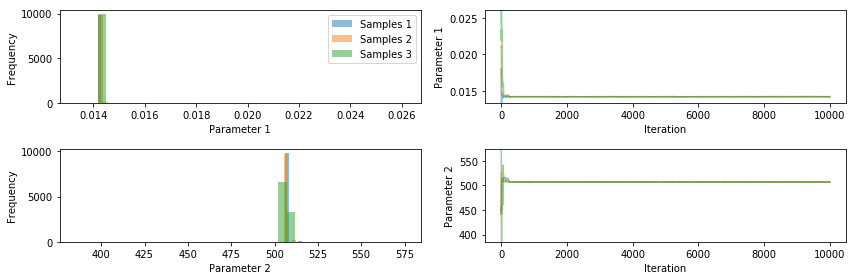

In [36]:
pints.plot.trace(chains_emu)
plt.show()

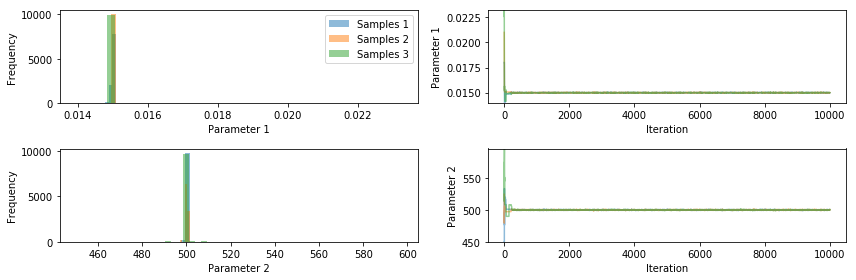

In [37]:
pints.plot.trace(chains)
plt.show()

In [38]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

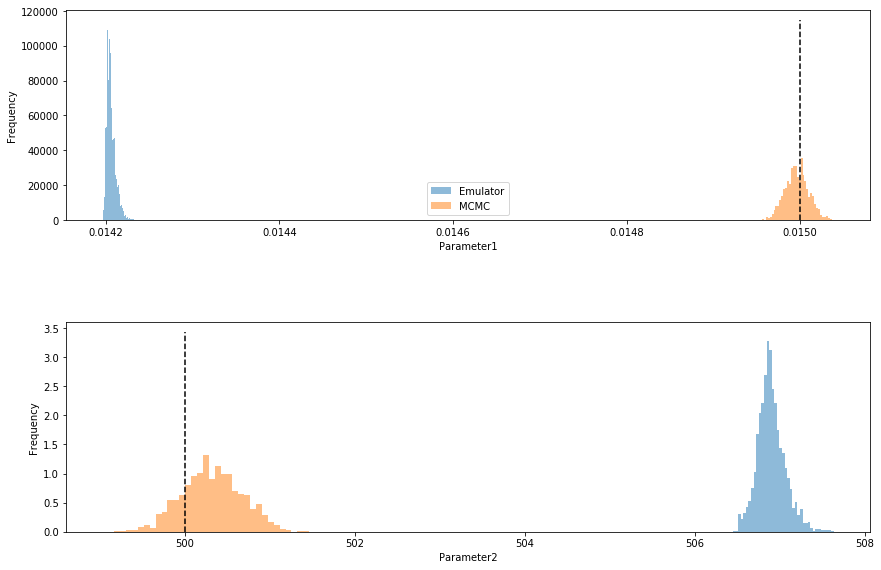

In [39]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

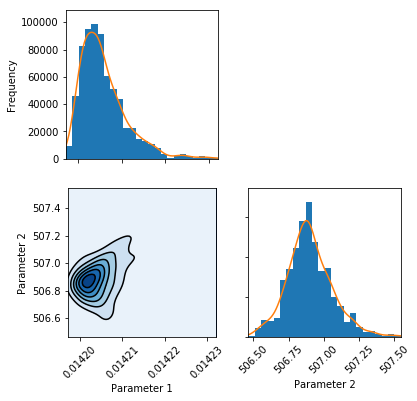

In [40]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

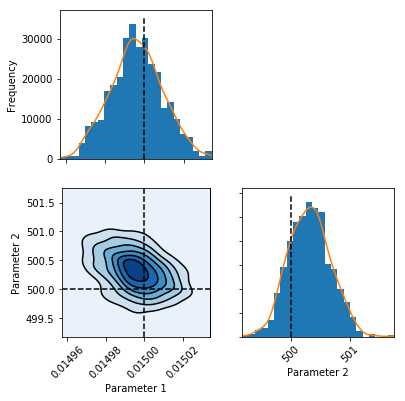

In [41]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

In [42]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

NameError: name 'chain_emu_rescaled' is not defined

In [ ]:
chain_emu

In [ ]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

In [ ]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters),# * 0.9,
    np.array(start_parameters),# * 1.05, #1.1
    np.array(start_parameters),# * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=emu)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [ ]:
metropolis_chains.shape

In [ ]:
metropolis_chains[0][:10]

In [ ]:
emulated_chains[0][:10]